## Домашнее здание №2 / Link Prediction

### Фамилия Имя / Группа

----
План выполнения домашнего задания:

1. Краткий обзор исходных данных
2. Генерация дополнительных данных
3. Создание матрицы признаков для ребер
4. Настройка модели и валидация качества модели
5. Отправка результатов в контест на Kaggle

----

В данном домашнем задании вам предстоит построить классификатор, который бы предсказывал наличие или отсутствия ребра в графе между двумя вершинами. Никакой дополнительной информации о вершинах, кроме ее соседей нет, поэтому вам придется создавать вектор признаков для каждой пары вершин на основе топологии графа.

Вершины графа - товары интернет магазина, наличие ребра символизируют о высокой частоте совместной покупки данных товаров вместе. Например если в нашем графе присутствую вершины молоко и хлеб и данные товары часто покупаются вместе, то между данными вершинами будет ребро. Если в нашем графе есть вершины молоко и кроссовки, то между данными вершинами ребра не будет. 

В данном датасете уровень относительной частоты по которому решается есть ребро между вершинами или его нет был определен за нас. Сам датасет был получен краулингом сайта Amazon.com в марте 2003 года, парсилась секция "Люди которые купили данный продукт, также преобретали это..."

Мотивация данного задания: Расширить список блока рекомендаций, за счет товаров которые с высокой вероятность могут оказаться в одной корзине покупателя.

----
Для создания модели и работы с данными мы будем использовать пакет GraphLab, структуры данных SFrame и SGraph идеально подходят для работы с графами. Распределенное хранение данных и применения функций для расчета метрик отдельных вершин сильно облегчают работу с графом.

Библиотека платная, но лицензия для академических целей получается в течении 5 минут, чтобы установить пакет следуйте шагам на сайте - https://turi.com/download/academic.html

----

Описание файлов:

1. the_graph.csv - файл содержащий ребра графа, две колонки: src,dst 
2. suspicions.csv - файл с ребрами, графа. Для данных ребер неизвестно присутствует ли оно в графе или нет.

Описание целевой метрики - в качестве целевой метрики будем использовать ROC AUC http://mlwiki.org/index.php/ROC_Analysis

----

In [1]:
import graphlab as gl
import numpy as np
import pandas as pd

gl.canvas.set_target('ipynb')

In [2]:
from graphlab import degree_counting, aggregate
import random

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

### 1. Краткий обзор исходных данных - 10 Баллов

Загрузим данные, найдем ряд базовых статистик:

1. Количество вершин и ребер
2. Распределение степеней вершин графа (График log - log)
3. Плотность графа
4. Диаметр графа
5. Количество треугольников в графе
6. Краткие выводы о данных.
7. БОНУСЫ - сделайте красивую визулизацию или расчет дополнительных метрик с выводами и вы получите дополнительные баллы за задание

In [3]:
edges = gl.SFrame.read_csv('the_graph.csv', delimiter=',', verbose=False)

This non-commercial license of GraphLab Create for academic use is assigned to karatsapova@phystech.edu and will expire on November 13, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479159976.log


In [4]:
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

<h4> Количество вершин и ребер

In [5]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 1384871


Выполните пункты 2 - 6. В пункте 6 напишите краткие выводы.

<h4> Распределение степеней вершин графа

In [19]:
vertices_degree = degree_counting.create(g)['graph'].vertices[['__id', 'total_degree']]
vertices_degree_distribution = total_degree.groupby(key_columns='total_degree', operations={'number': aggregate.COUNT()})
vertices_degree_distribution = vertices_degree_distribution.sort('total_degree')

In [20]:
vertices_degree_distribution

Columns:
	total_degree	int
	number	int

Rows: 159

Data:
+--------------+--------+
| total_degree | number |
+--------------+--------+
|      1       |  804   |
|      2       |  2355  |
|      3       |  3277  |
|      4       |  4255  |
|      5       |  4896  |
|      6       | 15032  |
|      7       | 27497  |
|      8       | 34567  |
|      9       | 34885  |
|      10      | 30979  |
+--------------+--------+
[159 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [27]:
total_degree = vertices_degree_distribution.select_column('total_degree')
total_degree_number = vertices_degree_distribution.select_column('number')

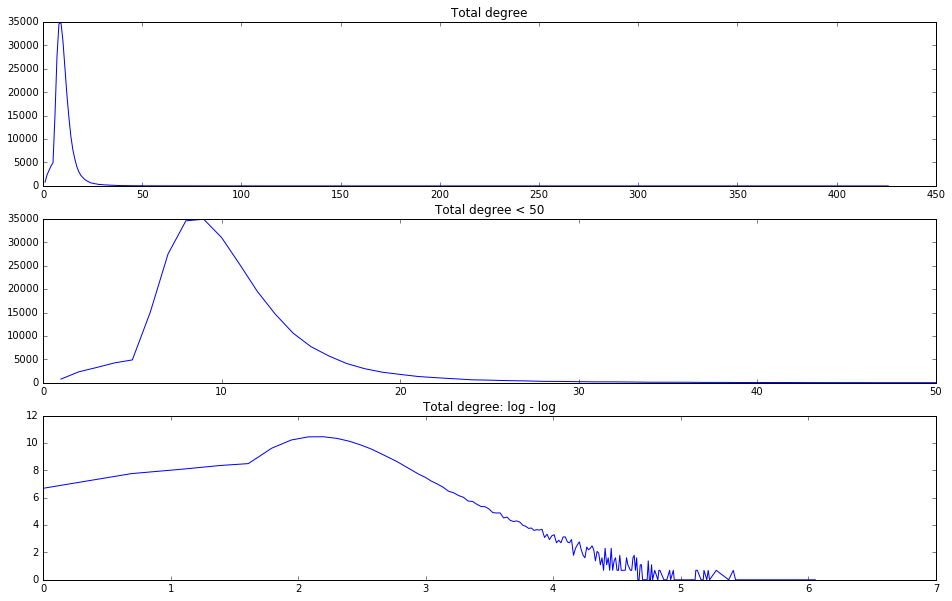

In [35]:
plt.figure(figsize=(16,10))
plt.subplot(311),plt.plot(total_degree, total_degree_number),plt.title('Total degree')
plt.subplot(312),plt.plot(total_degree[:50], total_degree_number[:50]),plt.title('Total degree < 50')
plt.subplot(313),plt.plot(np.log(total_degree), np.log(total_degree_number)),plt.title('Total degree: log - log')
plt.show()

<h4> Плотность графа

In [36]:
max_edges = (vert_edgs['num_vertices'] * (vert_edgs['num_vertices'] - 1)) / 2.0
print vert_edgs['num_edges'] / max_edges

4.03153541186e-05


<h4> Диаметр графа

In [77]:
max_distances = []
for vertex in range(100):
    sp = gl.shortest_path.create(g, source_vid=vertex)
    cur_max_distance = max(list(filter(lambda x: x < vert_edgs['num_edges'], sp['distance']['distance'])))
    max_distances.append(cur_max_distance)

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 435                        |

| 27869                      |

| 272125                     |

| 219587                     |

| 62170                      |

| 9813                       |

| 992                        |

| 83                         |

| 8                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 4087                       |

| 136483                     |

| 295366                     |

| 108706                     |

| 20056                      |

| 2099                       |

| 147                        |

| 9                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 233                        |

| 16969                      |

| 241280                     |

| 234426                     |

| 64448                      |

| 10202                      |

| 944                        |

| 71                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 75                         |

| 5403                       |

| 147392                     |

| 309148                     |

| 147705                     |

| 37351                      |

| 5883                       |

| 600                        |

| 54                         |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 3092                       |

| 117617                     |

| 296395                     |

| 117428                     |

| 22176                      |

| 2262                       |

| 145                        |

| 4                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 487                        |

| 27994                      |

| 267089                     |

| 202978                     |

| 53036                      |

| 9074                       |

| 878                        |

| 58                         |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 95                         |

| 6332                       |

| 170200                     |

| 287712                     |

| 102704                     |

| 20703                      |

| 2296                       |

| 126                        |

| 7                          |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 311                        |

| 20861                      |

| 249776                     |

| 222536                     |

| 65804                      |

| 10668                      |

| 1078                       |

| 75                         |

| 4                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 257                        |

| 18351                      |

| 242047                     |

| 224379                     |

| 59068                      |

| 8880                       |

| 783                        |

| 52                         |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 665                        |

| 39014                      |

| 285290                     |

| 184821                     |

| 48094                      |

| 7375                       |

| 743                        |

| 41                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1404                       |

| 64719                      |

| 307495                     |

| 159032                     |

| 34937                      |

| 4411                       |

| 355                        |

| 28                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 503                        |

| 35473                      |

| 284196                     |

| 183603                     |

| 40610                      |

| 4807                       |

| 370                        |

| 14                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 152                        |

| 10614                      |

| 214149                     |

| 248468                     |

| 69625                      |

| 10180                      |

| 954                        |

| 61                         |

| 6                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 368                        |

| 22607                      |

| 255160                     |

| 204342                     |

| 50486                      |

| 6937                       |

| 581                        |

| 26                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 466                        |

| 30721                      |

| 280279                     |

| 212884                     |

| 59237                      |

| 8657                       |

| 811                        |

| 53                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 352                        |

| 25177                      |

| 269044                     |

| 225167                     |

| 62391                      |

| 9128                       |

| 803                        |

| 55                         |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 583                        |

| 38622                      |

| 286714                     |

| 179480                     |

| 42780                      |

| 6025                       |

| 560                        |

| 32                         |

| 4                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 494                        |

| 27487                      |

| 274976                     |

| 218956                     |

| 62539                      |

| 9086                       |

| 778                        |

| 50                         |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 2816                       |

| 104650                     |

| 297202                     |

| 118366                     |

| 22625                      |

| 2447                       |

| 166                        |

| 20                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 738                        |

| 42654                      |

| 297895                     |

| 190896                     |

| 45575                      |

| 6130                       |

| 475                        |

| 38                         |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 145                        |

| 9384                       |

| 191722                     |

| 244708                     |

| 67096                      |

| 10586                      |

| 959                        |

| 51                         |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 408                        |

| 26041                      |

| 259234                     |

| 193854                     |

| 44714                      |

| 6056                       |

| 561                        |

| 39                         |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 185                        |

| 12301                      |

| 211440                     |

| 255175                     |

| 81908                      |

| 13940                      |

| 1623                       |

| 110                        |

| 11                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 34                         |

| 2949                       |

| 112983                     |

| 296296                     |

| 110508                     |

| 23904                      |

| 3398                       |

| 313                        |

| 13                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 2270                       |

| 96803                      |

| 305625                     |

| 127832                     |

| 25712                      |

| 2843                       |

| 208                        |

| 10                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 143                        |

| 9608                       |

| 199993                     |

| 264788                     |

| 78089                      |

| 12895                      |

| 1300                       |

| 91                         |

| 5                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 281                        |

| 16951                      |

| 237680                     |

| 223686                     |

| 63298                      |

| 10626                      |

| 1111                       |

| 69                         |

| 3                          |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 78                         |

| 4225                       |

| 138037                     |

| 296607                     |

| 104360                     |

| 18323                      |

| 1873                       |

| 128                        |

| 9                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 91                         |

| 7671                       |

| 182820                     |

| 284887                     |

| 101719                     |

| 20941                      |

| 2574                       |

| 213                        |

| 16                         |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 203                        |

| 15508                      |

| 230918                     |

| 241522                     |

| 74947                      |

| 13742                      |

| 1502                       |

| 121                        |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 101                        |

| 8736                       |

| 196056                     |

| 293881                     |

| 90580                      |

| 14620                      |

| 1394                       |

| 87                         |

| 10                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 3882                       |

| 127545                     |

| 306530                     |

| 118005                     |

| 21362                      |

| 2275                       |

| 175                        |

| 5                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 128                        |

| 6839                       |

| 176481                     |

| 264538                     |

| 80250                      |

| 13179                      |

| 1343                       |

| 75                         |

| 4                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 432                        |

| 26122                      |

| 280325                     |

| 233771                     |

| 66171                      |

| 10899                      |

| 1072                       |

| 80                         |

| 7                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 209                        |

| 12003                      |

| 213841                     |

| 234929                     |

| 59709                      |

| 8087                       |

| 652                        |

| 44                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 186                        |

| 11346                      |

| 214398                     |

| 264379                     |

| 84545                      |

| 15682                      |

| 1624                       |

| 116                        |

| 5                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 264                        |

| 17548                      |

| 245152                     |

| 248615                     |

| 74621                      |

| 12722                      |

| 1378                       |

| 92                         |

| 9                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 104                        |

| 7353                       |

| 174597                     |

| 273749                     |

| 83646                      |

| 13180                      |

| 1299                       |

| 75                         |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 431                        |

| 26248                      |

| 262968                     |

| 201724                     |

| 48041                      |

| 6405                       |

| 552                        |

| 39                         |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 214                        |

| 13907                      |

| 226700                     |

| 244223                     |

| 74217                      |

| 17373                      |

| 2755                       |

| 243                        |

| 15                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 34                         |

| 2267                       |

| 95447                      |

| 298995                     |

| 128910                     |

| 36837                      |

| 8190                       |

| 1237                       |

| 101                        |

| 8                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 3217                       |

| 112390                     |

| 302679                     |

| 128893                     |

| 33734                      |

| 6243                       |

| 727                        |

| 60                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 3344                       |

| 119549                     |

| 297999                     |

| 112464                     |

| 26749                      |

| 4344                       |

| 418                        |

| 23                         |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 3072                       |

| 115886                     |

| 326595                     |

| 182183                     |

| 61753                      |

| 14386                      |

| 2394                       |

| 203                        |

| 5                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 2696                       |

| 104186                     |

| 297801                     |

| 114959                     |

| 21440                      |

| 2513                       |

| 191                        |

| 10                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 131                        |

| 10038                      |

| 204151                     |

| 279599                     |

| 91949                      |

| 16776                      |

| 1796                       |

| 121                        |

| 8                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 154                        |

| 11419                      |

| 212073                     |

| 273324                     |

| 87857                      |

| 15495                      |

| 1594                       |

| 109                        |

| 5                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 297                        |

| 18936                      |

| 246827                     |

| 240452                     |

| 74694                      |

| 13340                      |

| 1393                       |

| 78                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 221                        |

| 15740                      |

| 234663                     |

| 249942                     |

| 76363                      |

| 13088                      |

| 1322                       |

| 73                         |

| 4                          |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 332                        |

| 25834                      |

| 266773                     |

| 200423                     |

| 47144                      |

| 6534                       |

| 584                        |

| 45                         |

| 4                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 45                         |

| 4139                       |

| 133446                     |

| 302550                     |

| 109488                     |

| 19603                      |

| 2118                       |

| 151                        |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 145                        |

| 11159                      |

| 215557                     |

| 241096                     |

| 65080                      |

| 9450                       |

| 815                        |

| 46                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 28                         |

| 1587                       |

| 73806                      |

| 306341                     |

| 139054                     |

| 27198                      |

| 3303                       |

| 267                        |

| 17                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 1294                       |

| 70414                      |

| 303542                     |

| 146055                     |

| 29088                      |

| 3623                       |

| 240                        |

| 21                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 232                        |

| 12948                      |

| 218714                     |

| 233303                     |

| 62951                      |

| 9303                       |

| 838                        |

| 48                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 131                        |

| 7611                       |

| 181360                     |

| 261956                     |

| 71014                      |

| 9947                       |

| 802                        |

| 67                         |

| 8                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1116                       |

| 59092                      |

| 306552                     |

| 167903                     |

| 41283                      |

| 6320                       |

| 551                        |

| 29                         |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 151                        |

| 10409                      |

| 207777                     |

| 272944                     |

| 87298                      |

| 15210                      |

| 1524                       |

| 114                        |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 134                        |

| 9717                       |

| 202862                     |

| 265874                     |

| 80469                      |

| 13656                      |

| 1346                       |

| 99                         |

| 7                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1220                       |

| 60119                      |

| 296442                     |

| 155206                     |

| 35520                      |

| 4780                       |

| 383                        |

| 27                         |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 122                        |

| 8247                       |

| 188979                     |

| 297730                     |

| 113354                     |

| 24767                      |

| 3254                       |

| 238                        |

| 13                         |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 2205                       |

| 94435                      |

| 304511                     |

| 130963                     |

| 27025                      |

| 3111                       |

| 224                        |

| 17                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 250                        |

| 19031                      |

| 245534                     |

| 229381                     |

| 67732                      |

| 11950                      |

| 1493                       |

| 108                        |

| 9                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 59                         |

| 4364                       |

| 139711                     |

| 298674                     |

| 120462                     |

| 28512                      |

| 3958                       |

| 415                        |

| 24                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 276                        |

| 16692                      |

| 244326                     |

| 259533                     |

| 81102                      |

| 14188                      |

| 1668                       |

| 126                        |

| 12                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1258                       |

| 66548                      |

| 311118                     |

| 176375                     |

| 47778                      |

| 7442                       |

| 841                        |

| 68                         |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 419                        |

| 29031                      |

| 270751                     |

| 205408                     |

| 55404                      |

| 8482                       |

| 924                        |

| 91                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 796                        |

| 48881                      |

| 301670                     |

| 183740                     |

| 44187                      |

| 6783                       |

| 652                        |

| 49                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 1455                       |

| 74186                      |

| 308526                     |

| 155070                     |

| 34817                      |

| 4207                       |

| 327                        |

| 22                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 459                        |

| 31005                      |

| 274685                     |

| 203140                     |

| 52845                      |

| 7597                       |

| 727                        |

| 40                         |

| 4                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1442                       |

| 76442                      |

| 303902                     |

| 137591                     |

| 25666                      |

| 2794                       |

| 177                        |

| 5                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1187                       |

| 57183                      |

| 300390                     |

| 163361                     |

| 37230                      |

| 4849                       |

| 413                        |

| 42                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 211                        |

| 15739                      |

| 234597                     |

| 245803                     |

| 71751                      |

| 11749                      |

| 1163                       |

| 85                         |

| 9                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 59                         |

| 4496                       |

| 134719                     |

| 289458                     |

| 93322                      |

| 15255                      |

| 1750                       |

| 144                        |

| 9                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 305                        |

| 19891                      |

| 252747                     |

| 243792                     |

| 68591                      |

| 10458                      |

| 847                        |

| 63                         |

| 4                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 229                        |

| 13902                      |

| 223349                     |

| 240170                     |

| 68801                      |

| 11257                      |

| 1082                       |

| 63                         |

| 4                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 29                         |

| 2689                       |

| 106779                     |

| 303390                     |

| 126112                     |

| 27261                      |

| 3399                       |

| 240                        |

| 12                         |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 307                        |

| 22136                      |

| 253911                     |

| 211114                     |

| 54915                      |

| 8428                       |

| 772                        |

| 34                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 32                         |

| 1855                       |

| 83268                      |

| 313083                     |

| 143402                     |

| 29374                      |

| 3623                       |

| 282                        |

| 20                         |

| 3                          |

| 3                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 73                         |

| 3707                       |

| 132893                     |

| 305141                     |

| 124396                     |

| 25579                      |

| 3237                       |

| 289                        |

| 22                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1301                       |

| 65091                      |

| 309498                     |

| 160388                     |

| 35955                      |

| 4940                       |

| 483                        |

| 31                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 922                        |

| 47363                      |

| 294711                     |

| 177798                     |

| 44846                      |

| 6532                       |

| 528                        |

| 39                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 141                        |

| 11148                      |

| 207512                     |

| 273527                     |

| 91519                      |

| 17035                      |

| 1982                       |

| 188                        |

| 8                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 770                        |

| 41329                      |

| 292259                     |

| 181764                     |

| 40414                      |

| 4634                       |

| 323                        |

| 26                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1795                       |

| 80195                      |

| 311401                     |

| 136159                     |

| 26278                      |

| 2961                       |

| 205                        |

| 12                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 410                        |

| 22718                      |

| 261538                     |

| 228022                     |

| 65232                      |

| 11101                      |

| 1237                       |

| 83                         |

| 6                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 325                        |

| 19954                      |

| 248285                     |

| 217512                     |

| 56174                      |

| 8567                       |

| 812                        |

| 57                         |

| 4                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 131                        |

| 10107                      |

| 204519                     |

| 278985                     |

| 91056                      |

| 16336                      |

| 1698                       |

| 132                        |

| 9                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 374                        |

| 30501                      |

| 277017                     |

| 196804                     |

| 46694                      |

| 6520                       |

| 575                        |

| 50                         |

| 6                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1968                       |

| 96102                      |

| 320347                     |

| 143154                     |

| 29017                      |

| 3261                       |

| 260                        |

| 17                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 253                        |

| 14028                      |

| 223740                     |

| 227459                     |

| 56049                      |

| 7713                       |

| 608                        |

| 42                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 1736                       |

| 77862                      |

| 316056                     |

| 166522                     |

| 43529                      |

| 7252                       |

| 734                        |

| 37                         |

| 1                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 131                        |

| 7705                       |

| 182650                     |

| 257815                     |

| 66607                      |

| 9359                       |

| 770                        |

| 57                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 124                        |

| 8086                       |

| 186553                     |

| 256793                     |

| 66348                      |

| 9217                       |

| 736                        |

| 47                         |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 110                        |

| 6164                       |

| 169784                     |

| 295877                     |

| 104770                     |

| 19386                      |

| 2002                       |

| 140                        |

| 5                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 34                         |

| 1516                       |

| 75714                      |

| 303907                     |

| 135376                     |

| 27148                      |

| 3364                       |

| 262                        |

| 20                         |

| 2                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 689                        |

| 43369                      |

| 292526                     |

| 171510                     |

| 38651                      |

| 4940                       |

| 443                        |

| 32                         |

| 4                          |

| 0                          |

+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 929                        |

| 53158                      |

| 291119                     |

| 144073                     |

| 30307                      |

| 4367                       |

| 422                        |

| 39                         |

| 1                          |

| 0                          |

+----------------------------+

In [79]:
print max(max_distances)

21.0


Это оценка снизу, так как проверять для всех вершин графа долго..

<h4> Количество треугольников в графе

In [43]:
triangle_counting_model = gl.triangle_counting.create(g)

Initializing vertex ids.

Removing duplicate (bidirectional) edges.

Counting triangles...

Finished in 3.28348 secs.

Total triangles in the graph : 717754

In [83]:
vertices_triangle_count = triangle_counting_model['graph'].vertices[['__id', 'triangle_count']]
triangle_count_distribution = vertices_triangle_count.groupby(key_columns='triangle_count', operations={'number': aggregate.COUNT()})
triangle_count_distribution = triangle_count_distribution.sort('triangle_count')

In [84]:
triangle_count = triangle_count_distribution.select_column('triangle_count')
triangle_count_number = triangle_count_distribution.select_column('number')

/Users/rikachka/py2_kernel/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


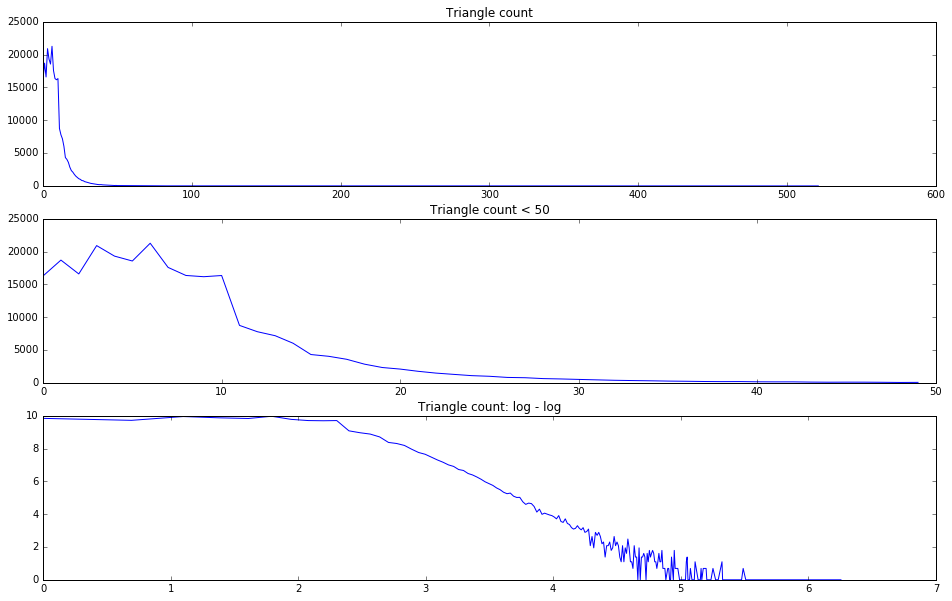

In [85]:
plt.figure(figsize=(16,10))
plt.subplot(311),plt.plot(triangle_count, triangle_count_number),plt.title('Triangle count')
plt.subplot(312),plt.plot(triangle_count[:50], triangle_count_number[:50]),plt.title('Triangle count < 50')
plt.subplot(313),plt.plot(np.log(triangle_count), np.log(triangle_count_number)),plt.title('Triangle count: log - log')
plt.show()

<h4> Выводы

* Граф сильно разреженный
* У большей части вершин степень порядка 5 - 15
* Большая часть вершин состоит в 0 - 10 треугольниках

----
### 2. Генерация дополнительных данных - 20 Баллов

Перед нами стоит задача создания модели классификации, которая в дальнейшем будет использоваться для повышения разнообразия блока рекомендаций. Для большинства моделей классификации требуется минимум 2 класса объектов - негативный и позитивный. Но у нас есть только граф, ребра которые в нем присутствуют это позитивные примеры. Получается, что у нас нет негативных примеров. 

Ответьте на 3 вопроса:

1. Можем ли мы сами создать негативные примеры? Граф это описание связей между вершинами, если мы будем случайным образом выбирать две вершины и считать, что это ребро - негативный пример, имеет ли это смысл?
2. Если мы решим сгенерировать негативные примеры, как должна быть устроена процедура генерации, чтобы обобщаяющая способность модели была наилучшей?
3. Как зависит обобщающая способность модели от негативных примеров, которые мы ей покажем?

1. Да, мы можем создавать негативные примеры. Но выбирать две вершины случайным образом плохо, ибо если, например, у них есть общий сосед, то существует значительная вероятность того, что это положительный, а не негативный пример.

2. Негативными примерами должны становиться пары вершин с большим кратчайшим путем между ними. 

3. Если брать негативные примеры так, как описано в пункте 2, то это будет увеличивать обобщающую способность

------
Создадим класс отрицательных примеров, сгенерировав его самым простым образом: берем две вершины, если ребро между ними отсутствует в графе, то это отрицательный пример.

1. Попробуйте улучшить генерацию отрицательных примеров

In [6]:
edges = gl.SFrame.read_csv('the_graph.csv', delimiter=',', verbose=False)
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')
vert_edgs = g.summary()

In [7]:
# read in existing edges
graph_file = open('the_graph.csv')
graph_file.readline() # first line is column names
existing_edges = set()

for x in graph_file:
    start, end = x.split(',')
    start, end = int(start), int(end)
    existing_edges.add((start, end))
    
print len(existing_edges)

1384871


In [178]:
vert_edgs['num_edges']

1384871

In [8]:
# generating negative examples, so that class balance is 50/50 
generated_nonexisting_edges = []
counter = 0
while True:
    start = np.random.randint(0, vert_edgs['num_vertices'])
    end = np.random.randint(0, vert_edgs['num_vertices'])
    
    if (start != end) & ((start, end) not in existing_edges):
        generated_nonexisting_edges.append([start, end, 0])
        
    counter += 1
    if counter == vert_edgs['num_edges']:
        break

print len(generated_nonexisting_edges)

1384837


In [142]:
## так не сработало.. score: 50

%%time

# generating negative examples, so that class balance is 50/50 

random.seed(123)

generated_nonexisting_edges = []
counter = 0
while True:
    start = np.random.randint(0, vert_edgs['num_vertices'])
    
    sp = gl.shortest_path.create(g, source_vid=start)
    far_vertices = list(filter(lambda x: x['distance'] < vert_edgs['num_edges'] and x['distance'] > 6, sp['distance']))
    
    np.random.shuffle(far_vertices)
#     print far_vertices[:100]
    
    for vertex in far_vertices[:1000]:
#         print vertex['__id']
        generated_nonexisting_edges.append([start, vertex['__id'], 0])
        counter += 1
        
#     break    
        
    if counter > vert_edgs['num_edges']:
        break
    else:
        print "COUNTER = ", counter

print len(generated_nonexisting_edges)

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 37                         |

| 1820                       |

| 82412                      |

| 313864                     |

| 154755                     |

| 38406                      |

| 5574                       |

| 482                        |

| 33                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 853                        |

| 48511                      |

| 295619                     |

| 168700                     |

| 40718                      |

| 6183                       |

| 623                        |

| 57                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  2000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 105                        |

| 5522                       |

| 160425                     |

| 286951                     |

| 93940                      |

| 15781                      |

| 1693                       |

| 147                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  3000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 564                        |

| 32939                      |

| 286468                     |

| 217666                     |

| 59530                      |

| 8822                       |

| 782                        |

| 70                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  4000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 43                         |

| 3386                       |

| 124821                     |

| 304508                     |

| 124839                     |

| 24970                      |

| 3047                       |

| 213                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  5000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 1474                       |

| 71192                      |

| 302481                     |

| 137999                     |

| 29732                      |

| 4259                       |

| 435                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  6000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 958                        |

| 53593                      |

| 322230                     |

| 208699                     |

| 59017                      |

| 9993                       |

| 1030                       |

| 68                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  7000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 1386                       |

| 68066                      |

| 307609                     |

| 154875                     |

| 36302                      |

| 4940                       |

| 430                        |

| 29                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  8000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 323                        |

| 21918                      |

| 257019                     |

| 233633                     |

| 69682                      |

| 11405                      |

| 1176                       |

| 90                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  9000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 57                         |

| 3937                       |

| 134608                     |

| 300802                     |

| 116111                     |

| 22420                      |

| 2474                       |

| 222                        |

| 14                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  10000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 4640                       |

| 149174                     |

| 294174                     |

| 104418                     |

| 18160                      |

| 1841                       |

| 107                        |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  11000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 2780                       |

| 113499                     |

| 297043                     |

| 110672                     |

| 19674                      |

| 2082                       |

| 120                        |

| 7                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  12000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 30                         |

| 1983                       |

| 87803                      |

| 303069                     |

| 132818                     |

| 28817                      |

| 3803                       |

| 286                        |

| 14                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  13000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 874                        |

| 48805                      |

| 294300                     |

| 152588                     |

| 29342                      |

| 3336                       |

| 262                        |

| 15                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  14000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 180                        |

| 17190                      |

| 241414                     |

| 237591                     |

| 66384                      |

| 9716                       |

| 893                        |

| 71                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  15000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 135                        |

| 11049                      |

| 212212                     |

| 244861                     |

| 69964                      |

| 12040                      |

| 1202                       |

| 85                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  16000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 43                         |

| 3966                       |

| 135450                     |

| 314420                     |

| 131116                     |

| 26720                      |

| 3030                       |

| 214                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  17000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 452                        |

| 34307                      |

| 285475                     |

| 194849                     |

| 46186                      |

| 6277                       |

| 497                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  18000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 293                        |

| 21825                      |

| 258359                     |

| 247536                     |

| 78287                      |

| 14838                      |

| 1646                       |

| 104                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  19000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 2                          |

| 396                        |

| 28010                      |

| 267459                     |

| 191551                     |

| 46422                      |

| 8538                       |

| 1287                       |

| 99                         |

| 0                          |

+----------------------------+

COUNTER =  20000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 93                         |

| 8111                       |

| 182756                     |

| 251576                     |

| 71577                      |

| 10390                      |

| 864                        |

| 50                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  21000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 645                        |

| 43262                      |

| 300419                     |

| 197552                     |

| 52906                      |

| 8566                       |

| 818                        |

| 47                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  22000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 97                         |

| 7616                       |

| 181641                     |

| 256211                     |

| 77723                      |

| 13402                      |

| 1425                       |

| 95                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  23000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 360                        |

| 24964                      |

| 268026                     |

| 215765                     |

| 51587                      |

| 6741                       |

| 593                        |

| 32                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  24000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 37                         |

| 4468                       |

| 144636                     |

| 279554                     |

| 84287                      |

| 12476                      |

| 1108                       |

| 75                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  25000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1522                       |

| 73281                      |

| 314228                     |

| 151582                     |

| 29727                      |

| 3378                       |

| 297                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  26000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 212                        |

| 19283                      |

| 252374                     |

| 212822                     |

| 50831                      |

| 7300                       |

| 644                        |

| 62                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  27000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 216                        |

| 16368                      |

| 234461                     |

| 230193                     |

| 60406                      |

| 9232                       |

| 834                        |

| 57                         |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  28000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 166                        |

| 11703                      |

| 213432                     |

| 259199                     |

| 85559                      |

| 18812                      |

| 2942                       |

| 325                        |

| 20                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  29000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 214                        |

| 13096                      |

| 228066                     |

| 270494                     |

| 89941                      |

| 16573                      |

| 1811                       |

| 144                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  30000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 48                         |

| 4025                       |

| 137456                     |

| 309207                     |

| 126773                     |

| 27536                      |

| 3300                       |

| 288                        |

| 26                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  31000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  31000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1407                       |

| 72416                      |

| 307905                     |

| 142108                     |

| 27290                      |

| 3141                       |

| 193                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  32000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 299                        |

| 20566                      |

| 252532                     |

| 218992                     |

| 57197                      |

| 8550                       |

| 795                        |

| 50                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  33000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 35                         |

| 1540                       |

| 79203                      |

| 307537                     |

| 143223                     |

| 31320                      |

| 4191                       |

| 353                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  34000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 2301                       |

| 102607                     |

| 308020                     |

| 124958                     |

| 24503                      |

| 3207                       |

| 274                        |

| 19                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  35000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 195                        |

| 15140                      |

| 227397                     |

| 251789                     |

| 77104                      |

| 14690                      |

| 1653                       |

| 104                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  36000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 38                         |

| 3680                       |

| 130802                     |

| 288771                     |

| 101892                     |

| 19975                      |

| 2120                       |

| 161                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  37000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 186                        |

| 17348                      |

| 242350                     |

| 230785                     |

| 62223                      |

| 9707                       |

| 959                        |

| 61                         |

| 0                          |

+----------------------------+

COUNTER =  38000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 780                        |

| 41761                      |

| 288773                     |

| 176530                     |

| 39302                      |

| 4975                       |

| 382                        |

| 32                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  39000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 431                        |

| 33015                      |

| 282065                     |

| 198817                     |

| 47762                      |

| 6425                       |

| 563                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  40000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 91                         |

| 7605                       |

| 181191                     |

| 266118                     |

| 79114                      |

| 12506                      |

| 1230                       |

| 66                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  41000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 122                        |

| 6922                       |

| 172469                     |

| 283589                     |

| 101624                     |

| 20225                      |

| 2430                       |

| 211                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  42000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 65                         |

| 4917                       |

| 150945                     |

| 290198                     |

| 99670                      |

| 17029                      |

| 1697                       |

| 108                        |

| 6                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  43000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 43                         |

| 4245                       |

| 143690                     |

| 300007                     |

| 110198                     |

| 19388                      |

| 2082                       |

| 152                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  44000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 3694                       |

| 131692                     |

| 329442                     |

| 165041                     |

| 39413                      |

| 5194                       |

| 388                        |

| 19                         |

| 0                          |

+----------------------------+

COUNTER =  45000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 47                         |

| 3690                       |

| 128395                     |

| 299415                     |

| 109833                     |

| 20597                      |

| 2105                       |

| 153                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  46000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 218                        |

| 16501                      |

| 235411                     |

| 231810                     |

| 60529                      |

| 8961                       |

| 913                        |

| 52                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  47000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 3                          |

| 823                        |

| 45369                      |

| 288341                     |

| 160529                     |

| 33470                      |

| 4173                       |

| 313                        |

| 22                         |

| 0                          |

+----------------------------+

COUNTER =  48000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 270                        |

| 21028                      |

| 256645                     |

| 245053                     |

| 75548                      |

| 14171                      |

| 1721                       |

| 127                        |

| 6                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  49000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 896                        |

| 52658                      |

| 299413                     |

| 165745                     |

| 39466                      |

| 5708                       |

| 495                        |

| 29                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  50000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 45                         |

| 4233                       |

| 128672                     |

| 301830                     |

| 122010                     |

| 26017                      |

| 3432                       |

| 271                        |

| 23                         |

| 0                          |

+----------------------------+

COUNTER =  51000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 48                         |

| 4222                       |

| 139180                     |

| 284421                     |

| 96694                      |

| 17442                      |

| 1806                       |

| 133                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  52000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 213                        |

| 15113                      |

| 222378                     |

| 241640                     |

| 71366                      |

| 13298                      |

| 1565                       |

| 122                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  53000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 160                        |

| 12922                      |

| 217456                     |

| 243058                     |

| 69067                      |

| 11983                      |

| 1294                       |

| 80                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  54000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 109                        |

| 7288                       |

| 180054                     |

| 286174                     |

| 106084                     |

| 21648                      |

| 2442                       |

| 168                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  55000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 2028                       |

| 93376                      |

| 318684                     |

| 158983                     |

| 39578                      |

| 5526                       |

| 498                        |

| 46                         |

| 0                          |

+----------------------------+

COUNTER =  56000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 63                         |

| 6432                       |

| 163947                     |

| 283029                     |

| 96439                      |

| 17582                      |

| 1779                       |

| 112                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  57000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 2300                       |

| 96935                      |

| 301850                     |

| 117745                     |

| 21343                      |

| 2399                       |

| 182                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  58000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 90                         |

| 7045                       |

| 176195                     |

| 272682                     |

| 84546                      |

| 14669                      |

| 1596                       |

| 124                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  59000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 776                        |

| 40645                      |

| 287464                     |

| 175750                     |

| 43572                      |

| 7100                       |

| 709                        |

| 47                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  60000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 377                        |

| 21838                      |

| 258088                     |

| 208244                     |

| 52846                      |

| 8392                       |

| 853                        |

| 70                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  61000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 254                        |

| 17318                      |

| 237312                     |

| 215031                     |

| 55759                      |

| 8954                       |

| 814                        |

| 65                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  62000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 141                        |

| 8502                       |

| 192112                     |

| 257360                     |

| 77455                      |

| 11835                      |

| 1240                       |

| 91                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  63000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 26                         |

| 3207                       |

| 117868                     |

| 309487                     |

| 123518                     |

| 23644                      |

| 2678                       |

| 217                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  64000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 234                        |

| 15812                      |

| 232983                     |

| 232590                     |

| 67626                      |

| 11927                      |

| 1381                       |

| 92                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  65000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 409                        |

| 25890                      |

| 264094                     |

| 199765                     |

| 49950                      |

| 7386                       |

| 635                        |

| 45                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  66000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 88                         |

| 8941                       |

| 196976                     |

| 287022                     |

| 109818                     |

| 23628                      |

| 3087                       |

| 216                        |

| 19                         |

| 0                          |

+----------------------------+

COUNTER =  67000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1306                       |

| 61534                      |

| 304233                     |

| 162784                     |

| 37164                      |

| 4761                       |

| 443                        |

| 51                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  68000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 661                        |

| 42621                      |

| 291023                     |

| 187595                     |

| 49759                      |

| 7324                       |

| 744                        |

| 42                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  69000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 480                        |

| 34429                      |

| 283016                     |

| 196887                     |

| 46654                      |

| 6477                       |

| 591                        |

| 38                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  70000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 346                        |

| 24897                      |

| 264806                     |

| 207484                     |

| 49108                      |

| 6468                       |

| 572                        |

| 35                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  71000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 256                        |

| 19986                      |

| 252821                     |

| 217699                     |

| 55802                      |

| 8682                       |

| 928                        |

| 75                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  72000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 37                         |

| 2630                       |

| 99018                      |

| 305687                     |

| 133407                     |

| 28154                      |

| 3893                       |

| 344                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  73000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 715                        |

| 43313                      |

| 290454                     |

| 170514                     |

| 37086                      |

| 4688                       |

| 349                        |

| 13                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  74000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 211                        |

| 15143                      |

| 230493                     |

| 225880                     |

| 61040                      |

| 8939                       |

| 723                        |

| 48                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  75000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 514                        |

| 28823                      |

| 291177                     |

| 249032                     |

| 74050                      |

| 11669                      |

| 1092                       |

| 71                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  76000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 248                        |

| 21101                      |

| 257284                     |

| 218051                     |

| 56293                      |

| 8156                       |

| 748                        |

| 36                         |

| 0                          |

+----------------------------+

COUNTER =  77000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 156                        |

| 13212                      |

| 224832                     |

| 234183                     |

| 60038                      |

| 8232                       |

| 667                        |

| 37                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  78000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 325                        |

| 22674                      |

| 261611                     |

| 224324                     |

| 61047                      |

| 9767                       |

| 1150                       |

| 85                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  79000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 1227                       |

| 66109                      |

| 311348                     |

| 158638                     |

| 35328                      |

| 5248                       |

| 513                        |

| 21                         |

| 0                          |

+----------------------------+

COUNTER =  80000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 136                        |

| 11201                      |

| 208998                     |

| 244924                     |

| 67817                      |

| 10525                      |

| 1023                       |

| 67                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  81000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 1863                       |

| 84427                      |

| 311886                     |

| 139634                     |

| 28707                      |

| 3526                       |

| 233                        |

| 13                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  82000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 35                         |

| 3998                       |

| 130769                     |

| 290307                     |

| 100070                     |

| 16265                      |

| 1683                       |

| 103                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  83000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1593                       |

| 78866                      |

| 315891                     |

| 171458                     |

| 39646                      |

| 5000                       |

| 426                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  84000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 2938                       |

| 111992                     |

| 300432                     |

| 120174                     |

| 25740                      |

| 3295                       |

| 297                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  85000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 191                        |

| 14737                      |

| 229696                     |

| 234853                     |

| 60680                      |

| 8605                       |

| 763                        |

| 43                         |

| 1                          |

| 0                          |

COUNTER =  86000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 267                        |

| 17186                      |

| 245317                     |

| 265174                     |

| 81931                      |

| 14711                      |

| 1611                       |

| 77                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  87000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 419                        |

| 28093                      |

| 271246                     |

| 212964                     |

| 55170                      |

| 8347                       |

| 758                        |

| 50                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  88000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 371                        |

| 26994                      |

| 269081                     |

| 209111                     |

| 54861                      |

| 8709                       |

| 855                        |

| 31                         |

| 0                          |

+----------------------------+

COUNTER =  89000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 312                        |

| 19958                      |

| 251303                     |

| 225732                     |

| 64121                      |

| 11161                      |

| 1226                       |

| 98                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  90000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 83                         |

| 6936                       |

| 172791                     |

| 276939                     |

| 86394                      |

| 14667                      |

| 1461                       |

| 118                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  91000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 248                        |

| 18625                      |

| 244668                     |

| 222089                     |

| 62954                      |

| 11460                      |

| 1183                       |

| 85                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  92000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 75                         |

| 5915                       |

| 165833                     |

| 288026                     |

| 105556                     |

| 21683                      |

| 2277                       |

| 171                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  93000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 29                         |

| 4145                       |

| 141643                     |

| 289256                     |

| 104873                     |

| 18449                      |

| 1938                       |

| 126                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  94000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1429                       |

| 70229                      |

| 307229                     |

| 152002                     |

| 33779                      |

| 4599                       |

| 348                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  95000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  95000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 155                        |

| 14308                      |

| 228093                     |

| 235131                     |

| 63627                      |

| 10141                      |

| 1115                       |

| 74                         |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  96000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 30                         |

| 2309                       |

| 99747                      |

| 294298                     |

| 114786                     |

| 22140                      |

| 2665                       |

| 157                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  97000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 248                        |

| 13163                      |

| 219719                     |

| 240318                     |

| 63558                      |

| 9043                       |

| 800                        |

| 48                         |

| 0                          |

+----------------------------+

COUNTER =  98000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 29                         |

| 1688                       |

| 80653                      |

| 296384                     |

| 132271                     |

| 35246                      |

| 6509                       |

| 735                        |

| 42                         |

| 0                          |

+----------------------------+

COUNTER =  99000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 144                        |

| 8861                       |

| 190429                     |

| 270776                     |

| 84212                      |

| 14056                      |

| 1479                       |

| 94                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  100000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1837                       |

| 83170                      |

| 315046                     |

| 156376                     |

| 37802                      |

| 4958                       |

| 405                        |

| 14                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  101000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 120                        |

| 7927                       |

| 184998                     |

| 258885                     |

| 79127                      |

| 13788                      |

| 1435                       |

| 102                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  102000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 1623                       |

| 87108                      |

| 311760                     |

| 133447                     |

| 25119                      |

| 2936                       |

| 182                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  103000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1117                       |

| 62213                      |

| 312882                     |

| 171429                     |

| 41808                      |

| 5353                       |

| 435                        |

| 26                         |

| 0                          |

+----------------------------+

COUNTER =  104000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 204                        |

| 16664                      |

| 230652                     |

| 236297                     |

| 66710                      |

| 10728                      |

| 1034                       |

| 78                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  105000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 246                        |

| 16980                      |

| 238513                     |

| 229153                     |

| 62966                      |

| 10436                      |

| 1373                       |

| 127                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  106000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 4                          |

| 354                        |

| 22767                      |

| 252912                     |

| 203699                     |

| 51455                      |

| 7703                       |

| 648                        |

| 41                         |

| 4                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  107000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 403                        |

| 21401                      |

| 262981                     |

| 249680                     |

| 77591                      |

| 13448                      |

| 1645                       |

| 135                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  108000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 155                        |

| 10922                      |

| 208634                     |

| 268154                     |

| 92742                      |

| 19816                      |

| 2836                       |

| 270                        |

| 22                         |

| 0                          |

+----------------------------+

COUNTER =  109000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 378                        |

| 29572                      |

| 275599                     |

| 205833                     |

| 51630                      |

| 8108                       |

| 740                        |

| 64                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  110000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 1701                       |

| 81454                      |

| 309534                     |

| 135856                     |

| 27724                      |

| 3648                       |

| 307                        |

| 20                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  111000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 3100                       |

| 117971                     |

| 294482                     |

| 113443                     |

| 23061                      |

| 2831                       |

| 236                        |

| 10                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  112000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 574                        |

| 35650                      |

| 277820                     |

| 169393                     |

| 34995                      |

| 4362                       |

| 326                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  113000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 48                         |

| 3523                       |

| 122700                     |

| 303426                     |

| 118549                     |

| 21598                      |

| 2487                       |

| 169                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  114000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1395                       |

| 72542                      |

| 310433                     |

| 155961                     |

| 37277                      |

| 5214                       |

| 436                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  115000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 702                        |

| 42143                      |

| 297431                     |

| 204689                     |

| 60868                      |

| 10233                      |

| 963                        |

| 51                         |

| 0                          |

+----------------------------+

COUNTER =  116000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 43                         |

| 2795                       |

| 107327                     |

| 300666                     |

| 130665                     |

| 29875                      |

| 3924                       |

| 296                        |

| 18                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  117000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 209                        |

| 16926                      |

| 238665                     |

| 224561                     |

| 65162                      |

| 11203                      |

| 1238                       |

| 91                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  118000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 442                        |

| 26247                      |

| 270558                     |

| 214836                     |

| 61391                      |

| 10880                      |

| 1103                       |

| 76                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  119000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 353                        |

| 23253                      |

| 264709                     |

| 242381                     |

| 75247                      |

| 12879                      |

| 1352                       |

| 103                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  120000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 2467                       |

| 101320                     |

| 302271                     |

| 123017                     |

| 23665                      |

| 2537                       |

| 192                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  121000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 2315                       |

| 96738                      |

| 310686                     |

| 132074                     |

| 29015                      |

| 4007                       |

| 328                        |

| 17                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  122000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 845                        |

| 47887                      |

| 300012                     |

| 179509                     |

| 40200                      |

| 5097                       |

| 480                        |

| 30                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  123000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 1868                       |

| 86922                      |

| 310627                     |

| 147471                     |

| 31955                      |

| 3913                       |

| 269                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  124000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 363                        |

| 24064                      |

| 264699                     |

| 234269                     |

| 66619                      |

| 10140                      |

| 887                        |

| 52                         |

| 0                          |

+----------------------------+

COUNTER =  125000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 77                         |

| 6597                       |

| 173632                     |

| 276563                     |

| 86794                      |

| 14194                      |

| 1503                       |

| 116                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  126000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 57                         |

| 6068                       |

| 169690                     |

| 295130                     |

| 100876                     |

| 17924                      |

| 1986                       |

| 160                        |

| 9                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  127000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 211                        |

| 19227                      |

| 250059                     |

| 233948                     |

| 61031                      |

| 8926                       |

| 806                        |

| 42                         |

| 0                          |

+----------------------------+

COUNTER =  128000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 200                        |

| 14225                      |

| 225018                     |

| 248291                     |

| 68354                      |

| 9658                       |

| 855                        |

| 53                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  129000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 30                         |

| 4904                       |

| 155754                     |

| 288267                     |

| 95124                      |

| 16464                      |

| 1629                       |

| 98                         |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  130000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 5783                       |

| 166479                     |

| 275688                     |

| 83164                      |

| 13950                      |

| 1436                       |

| 106                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  131000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 2818                       |

| 105657                     |

| 295673                     |

| 107187                     |

| 18781                      |

| 1914                       |

| 113                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  132000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 807                        |

| 47599                      |

| 293416                     |

| 174465                     |

| 42959                      |

| 6478                       |

| 664                        |

| 40                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  133000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 61                         |

| 4829                       |

| 150702                     |

| 301820                     |

| 124780                     |

| 29683                      |

| 4121                       |

| 376                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  134000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 705                        |

| 44945                      |

| 299744                     |

| 186349                     |

| 45724                      |

| 6791                       |

| 504                        |

| 20                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  135000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 198                        |

| 17008                      |

| 236127                     |

| 233347                     |

| 65068                      |

| 10200                      |

| 925                        |

| 68                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  136000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 45                         |

| 6335                       |

| 166894                     |

| 274047                     |

| 92784                      |

| 19337                      |

| 2682                       |

| 224                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  137000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1344                       |

| 66783                      |

| 315116                     |

| 173894                     |

| 43074                      |

| 6054                       |

| 585                        |

| 32                         |

| 0                          |

+----------------------------+

COUNTER =  138000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 159                        |

| 13804                      |

| 224570                     |

| 237389                     |

| 65854                      |

| 10818                      |

| 1066                       |

| 75                         |

| 5                          |

| 0                          |

COUNTER = 

+----------------------------+

 139000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 181                        |

| 11315                      |

| 205239                     |

| 240778                     |

| 64660                      |

| 9908                       |

| 887                        |

| 33                         |

| 0                          |

+----------------------------+

COUNTER =  140000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1075                       |

| 65514                      |

| 315156                     |

| 170469                     |

| 38456                      |

| 5399                       |

| 489                        |

| 24                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  141000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 42                         |

| 2742                       |

| 110870                     |

| 300983                     |

| 116162                     |

| 23000                      |

| 2880                       |

| 253                        |

| 19                         |

| 0                          |

+----------------------------+

COUNTER =  142000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 2534                       |

| 99505                      |

| 305781                     |

| 135325                     |

| 30543                      |

| 4156                       |

| 341                        |

| 12                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  143000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1697                       |

| 80755                      |

| 308939                     |

| 151706                     |

| 34286                      |

| 3977                       |

| 303                        |

| 12                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  144000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1021                       |

| 55202                      |

| 301938                     |

| 165891                     |

| 35411                      |

| 4599                       |

| 447                        |

| 31                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  145000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 512                        |

| 34905                      |

| 285452                     |

| 192294                     |

| 44174                      |

| 6043                       |

| 520                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  146000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 955                        |

| 56732                      |

| 298552                     |

| 153867                     |

| 30125                      |

| 3419                       |

| 245                        |

| 22                         |

| 0                          |

+----------------------------+

COUNTER =  147000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 34                         |

| 2510                       |

| 103304                     |

| 296474                     |

| 108723                     |

| 19412                      |

| 2269                       |

| 156                        |

| 9                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  148000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 195                        |

| 14629                      |

| 225289                     |

| 251739                     |

| 77372                      |

| 13521                      |

| 1584                       |

| 127                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  149000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 651                        |

| 39595                      |

| 292950                     |

| 204712                     |

| 53777                      |

| 8300                       |

| 738                        |

| 49                         |

| 2                          |

| 0                          |

COUNTER =  150000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 154                        |

| 14566                      |

| 232398                     |

| 260868                     |

| 87396                      |

| 17466                      |

| 1974                       |

| 126                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  151000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 114                        |

| 9531                       |

| 199935                     |

| 285109                     |

| 91871                      |

| 16131                      |

| 1644                       |

| 104                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  152000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 166                        |

| 13053                      |

| 213831                     |

| 236235                     |

| 63089                      |

| 9222                       |

| 831                        |

| 58                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  153000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 167                        |

| 17220                      |

| 238844                     |

| 251932                     |

| 89749                      |

| 19829                      |

| 2586                       |

| 187                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  154000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1530                       |

| 80050                      |

| 314447                     |

| 151579                     |

| 33281                      |

| 4468                       |

| 405                        |

| 31                         |

| 0                          |

+----------------------------+

COUNTER =  155000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 28                         |

| 2761                       |

| 111894                     |

| 327200                     |

| 156848                     |

| 35841                      |

| 4781                       |

| 422                        |

| 17                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  156000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 311                        |

| 26405                      |

| 267963                     |

| 226822                     |

| 85788                      |

| 22680                      |

| 3464                       |

| 297                        |

| 21                         |

| 0                          |

+----------------------------+

COUNTER =  157000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 124                        |

| 10356                      |

| 205243                     |

| 270961                     |

| 92534                      |

| 18395                      |

| 2153                       |

| 125                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  158000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 108                        |

| 7363                       |

| 180488                     |

| 277717                     |

| 86721                      |

| 13920                      |

| 1325                       |

| 91                         |

| 0                          |

+----------------------------+

COUNTER =  159000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 42                         |

| 4625                       |

| 148083                     |

| 278299                     |

| 88715                      |

| 14761                      |

| 1436                       |

| 104                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  160000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1971                       |

| 96541                      |

| 299778                     |

| 121081                     |

| 22529                      |

| 2617                       |

| 215                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  161000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 43                         |

| 3190                       |

| 117435                     |

| 289985                     |

| 101814                     |

| 17628                      |

| 2002                       |

| 154                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  162000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 286                        |

| 18302                      |

| 242890                     |

| 223219                     |

| 57128                      |

| 8118                       |

| 735                        |

| 46                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  163000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 155                        |

| 9601                       |

| 193898                     |

| 265804                     |

| 93406                      |

| 20593                      |

| 2684                       |

| 241                        |

| 17                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  164000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 365                        |

| 27473                      |

| 261919                     |

| 189657                     |

| 46454                      |

| 7740                       |

| 869                        |

| 65                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  165000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 567                        |

| 32898                      |

| 284705                     |

| 207011                     |

| 55846                      |

| 9286                       |

| 806                        |

| 53                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  166000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 134                        |

| 10914                      |

| 203161                     |

| 256274                     |

| 74048                      |

| 11600                      |

| 1130                       |

| 69                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  167000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 335                        |

| 25178                      |

| 261967                     |

| 210969                     |

| 59738                      |

| 10165                      |

| 1021                       |

| 54                         |

| 0                          |

+----------------------------+

COUNTER =  168000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 704                        |

| 44787                      |

| 294302                     |

| 178602                     |

| 39665                      |

| 5620                       |

| 553                        |

| 45                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  169000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 458                        |

| 22164                      |

| 253701                     |

| 220883                     |

| 67248                      |

| 11364                      |

| 1122                       |

| 76                         |

| 0                          |

+----------------------------+

COUNTER =  170000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 78                         |

| 5864                       |

| 152038                     |

| 278565                     |

| 89432                      |

| 14966                      |

| 1598                       |

| 118                        |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  171000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 255                        |

| 13419                      |

| 226710                     |

| 244371                     |

| 67747                      |

| 10519                      |

| 954                        |

| 47                         |

| 2                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  172000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 295                        |

| 19935                      |

| 250815                     |

| 220194                     |

| 63152                      |

| 12958                      |

| 2008                       |

| 170                        |

| 11                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  173000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 152                        |

| 14035                      |

| 230433                     |

| 247970                     |

| 79357                      |

| 14103                      |

| 1351                       |

| 87                         |

| 0                          |

+----------------------------+

COUNTER =  174000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 81                         |

| 5227                       |

| 156146                     |

| 287008                     |

| 102961                     |

| 21163                      |

| 2787                       |

| 258                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  175000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 78                         |

| 5862                       |

| 161257                     |

| 283993                     |

| 96170                      |

| 16840                      |

| 1761                       |

| 108                        |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  176000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 49                         |

| 3572                       |

| 127049                     |

| 308883                     |

| 127373                     |

| 28177                      |

| 3540                       |

| 229                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  177000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 1043                       |

| 60677                      |

| 305188                     |

| 175153                     |

| 44505                      |

| 6705                       |

| 699                        |

| 40                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  178000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 107                        |

| 8401                       |

| 184362                     |

| 281847                     |

| 101852                     |

| 20746                      |

| 2526                       |

| 189                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  179000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1952                       |

| 90257                      |

| 300191                     |

| 117199                     |

| 21000                      |

| 2229                       |

| 154                        |

| 12                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  180000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 75                         |

| 6724                       |

| 176571                     |

| 297760                     |

| 114466                     |

| 22683                      |

| 2390                       |

| 182                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  181000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 4306                       |

| 133960                     |

| 282509                     |

| 95647                      |

| 16315                      |

| 1720                       |

| 120                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  182000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 2173                       |

| 94733                      |

| 303854                     |

| 130481                     |

| 26295                      |

| 3030                       |

| 226                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  183000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 59                         |

| 3285                       |

| 118500                     |

| 311834                     |

| 135214                     |

| 30284                      |

| 4210                       |

| 377                        |

| 20                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  184000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 257                        |

| 14481                      |

| 227420                     |

| 238338                     |

| 70437                      |

| 11642                      |

| 1227                       |

| 67                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  185000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 134                        |

| 13322                      |

| 223963                     |

| 252240                     |

| 78852                      |

| 15047                      |

| 1751                       |

| 161                        |

| 11                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  186000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1214                       |

| 64210                      |

| 302885                     |

| 150004                     |

| 31285                      |

| 3469                       |

| 276                        |

| 11                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  187000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 1073                       |

| 66893                      |

| 318850                     |

| 179235                     |

| 45585                      |

| 7547                       |

| 838                        |

| 97                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  188000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 109                        |

| 7803                       |

| 179200                     |

| 277139                     |

| 93366                      |

| 16047                      |

| 1690                       |

| 121                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  189000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 28                         |

| 2308                       |

| 97144                      |

| 312647                     |

| 143661                     |

| 35660                      |

| 5780                       |

| 539                        |

| 38                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  190000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 188                        |

| 14288                      |

| 228101                     |

| 241573                     |

| 65699                      |

| 9795                       |

| 978                        |

| 51                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  191000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 30                         |

| 2310                       |

| 96457                      |

| 328189                     |

| 151809                     |

| 31411                      |

| 3924                       |

| 300                        |

| 28                         |

| 0                          |

+----------------------------+

COUNTER =  192000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 668                        |

| 44281                      |

| 295720                     |

| 172619                     |

| 40111                      |

| 6018                       |

| 572                        |

| 27                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  193000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 51                         |

| 4682                       |

| 145676                     |

| 289704                     |

| 107391                     |

| 21710                      |

| 2561                       |

| 211                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  194000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  194000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 135                        |

| 8360                       |

| 185058                     |

| 266193                     |

| 82703                      |

| 13956                      |

| 1343                       |

| 95                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  195000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 55                         |

| 5370                       |

| 154940                     |

| 283446                     |

| 84219                      |

| 12575                      |

| 1122                       |

| 59                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  196000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 159                        |

| 11922                      |

| 219552                     |

| 261148                     |

| 82821                      |

| 16798                      |

| 2131                       |

| 183                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  197000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 1565                       |

| 66963                      |

| 313025                     |

| 160666                     |

| 36210                      |

| 5286                       |

| 534                        |

| 28                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  198000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1149                       |

| 65500                      |

| 303067                     |

| 149330                     |

| 34108                      |

| 5056                       |

| 441                        |

| 22                         |

| 0                          |

+----------------------------+

COUNTER =  199000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 639                        |

| 45118                      |

| 298540                     |

| 173007                     |

| 42795                      |

| 6059                       |

| 550                        |

| 28                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  200000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1043                       |

| 66970                      |

| 302350                     |

| 137639                     |

| 24605                      |

| 2503                       |

| 140                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  201000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 857                        |

| 45515                      |

| 297508                     |

| 187873                     |

| 42512                      |

| 5661                       |

| 552                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  202000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1436                       |

| 74455                      |

| 314125                     |

| 152887                     |

| 32400                      |

| 3665                       |

| 249                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  203000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 148                        |

| 11131                      |

| 211418                     |

| 259370                     |

| 82915                      |

| 15261                      |

| 1810                       |

| 178                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  204000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 189                        |

| 15153                      |

| 227841                     |

| 242584                     |

| 74074                      |

| 13661                      |

| 1675                       |

| 176                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  205000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 30                         |

| 2109                       |

| 97615                      |

| 304509                     |

| 115742                     |

| 19459                      |

| 2042                       |

| 154                        |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  206000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 447                        |

| 32866                      |

| 277755                     |

| 211157                     |

| 55608                      |

| 8398                       |

| 793                        |

| 61                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  207000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 117                        |

| 8441                       |

| 185964                     |

| 266821                     |

| 80515                      |

| 12908                      |

| 1250                       |

| 60                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  208000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 270                        |

| 15111                      |

| 227465                     |

| 237361                     |

| 68419                      |

| 11297                      |

| 1176                       |

| 90                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  209000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 101                        |

| 7407                       |

| 183685                     |

| 277586                     |

| 91617                      |

| 16822                      |

| 1780                       |

| 118                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  210000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 98                         |

| 9524                       |

| 197203                     |

| 278923                     |

| 89133                      |

| 14103                      |

| 1384                       |

| 111                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  211000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 171                        |

| 10899                      |

| 211937                     |

| 256240                     |

| 79691                      |

| 15002                      |

| 1818                       |

| 137                        |

| 15                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  212000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 253                        |

| 18821                      |

| 247145                     |

| 222927                     |

| 64878                      |

| 11134                      |

| 1318                       |

| 84                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  213000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 118                        |

| 9343                       |

| 195672                     |

| 259430                     |

| 77930                      |

| 12999                      |

| 1286                       |

| 90                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  214000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 48                         |

| 5497                       |

| 150316                     |

| 272972                     |

| 83554                      |

| 12996                      |

| 1252                       |

| 69                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  215000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 34                         |

| 2924                       |

| 112181                     |

| 317243                     |

| 154539                     |

| 40692                      |

| 6694                       |

| 647                        |

| 35                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  216000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 59                         |

| 4287                       |

| 141802                     |

| 281244                     |

| 93387                      |

| 16518                      |

| 1812                       |

| 124                        |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  217000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 4                          |

| 442                        |

| 29266                      |

| 270565                     |

| 182221                     |

| 41921                      |

| 5647                       |

| 511                        |

| 31                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  218000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 366                        |

| 26263                      |

| 268780                     |

| 214392                     |

| 52111                      |

| 6936                       |

| 515                        |

| 34                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  219000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 170                        |

| 12768                      |

| 222988                     |

| 259342                     |

| 85159                      |

| 17662                      |

| 2504                       |

| 187                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  220000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 512                        |

| 31521                      |

| 278288                     |

| 194400                     |

| 52525                      |

| 7910                       |

| 700                        |

| 29                         |

| 0                          |

COUNTER =  221000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 51                         |

| 4404                       |

| 143539                     |

| 278805                     |

| 91333                      |

| 15463                      |

| 1558                       |

| 92                         |

| 0                          |

+----------------------------+

COUNTER =  222000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 35                         |

| 2487                       |

| 106326                     |

| 293235                     |

| 110705                     |

| 21746                      |

| 2620                       |

| 198                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  223000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1913                       |

| 88069                      |

| 297993                     |

| 135578                     |

| 30949                      |

| 4414                       |

| 422                        |

| 27                         |

| 0                          |

+----------------------------+

COUNTER =  224000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 831                        |

| 50806                      |

| 302468                     |

| 178908                     |

| 38664                      |

| 4782                       |

| 356                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  225000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 2122                       |

| 92843                      |

| 295621                     |

| 124679                     |

| 25618                      |

| 2922                       |

| 238                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  226000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 32                         |

| 4254                       |

| 131344                     |

| 291130                     |

| 103839                     |

| 20116                      |

| 2331                       |

| 196                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  227000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 128                        |

| 10281                      |

| 204006                     |

| 269537                     |

| 85437                      |

| 15491                      |

| 1834                       |

| 124                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  228000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 2513                       |

| 106577                     |

| 307762                     |

| 136304                     |

| 29055                      |

| 3911                       |

| 366                        |

| 19                         |

| 0                          |

+----------------------------+

COUNTER =  229000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 281                        |

| 20368                      |

| 252318                     |

| 239087                     |

| 68010                      |

| 10823                      |

| 1142                       |

| 100                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  230000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 910                        |

| 49247                      |

| 304674                     |

| 186746                     |

| 43988                      |

| 5881                       |

| 533                        |

| 35                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  231000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1140                       |

| 66072                      |

| 300485                     |

| 138882                     |

| 25666                      |

| 2713                       |

| 184                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  232000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 930                        |

| 51688                      |

| 299378                     |

| 172849                     |

| 40599                      |

| 6313                       |

| 769                        |

| 60                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  233000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 372                        |

| 24511                      |

| 265289                     |

| 221057                     |

| 62209                      |

| 9967                       |

| 933                        |

| 72                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  234000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 26                         |

| 2998                       |

| 113685                     |

| 315684                     |

| 142269                     |

| 34381                      |

| 5328                       |

| 493                        |

| 42                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  235000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1105                       |

| 58958                      |

| 300500                     |

| 152826                     |

| 32117                      |

| 4094                       |

| 282                        |

| 27                         |

| 0                          |

+----------------------------+

COUNTER =  236000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 258                        |

| 20583                      |

| 253719                     |

| 225907                     |

| 64591                      |

| 10695                      |

| 1032                       |

| 77                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  237000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1148                       |

| 59585                      |

| 304182                     |

| 162949                     |

| 36851                      |

| 4551                       |

| 407                        |

| 21                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  238000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 85                         |

| 6338                       |

| 162602                     |

| 280750                     |

| 98852                      |

| 19939                      |

| 2384                       |

| 157                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  239000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1212                       |

| 60888                      |

| 303728                     |

| 170534                     |

| 43401                      |

| 6909                       |

| 723                        |

| 47                         |

| 0                          |

+----------------------------+

COUNTER =  240000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 103                        |

| 6741                       |

| 175884                     |

| 284983                     |

| 98292                      |

| 18919                      |

| 2342                       |

| 213                        |

| 13                         |

| 1                          |

| 0                          |

COUNTER =  241000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 26                         |

| 2003                       |

| 92095                      |

| 294599                     |

| 116472                     |

| 19844                      |

| 2053                       |

| 94                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  242000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 285                        |

| 17720                      |

| 245254                     |

| 231493                     |

| 63826                      |

| 10521                      |

| 986                        |

| 53                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  243000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 303                        |

| 23101                      |

| 266793                     |

| 251657                     |

| 87218                      |

| 18263                      |

| 2611                       |

| 237                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  244000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 278                        |

| 19988                      |

| 251938                     |

| 222556                     |

| 61301                      |

| 9669                       |

| 1006                       |

| 51                         |

| 0                          |

+----------------------------+

COUNTER =  245000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 249                        |

| 16454                      |

| 232953                     |

| 217158                     |

| 51396                      |

| 6074                       |

| 478                        |

| 37                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  246000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 995                        |

| 56294                      |

| 296902                     |

| 152193                     |

| 29611                      |

| 3523                       |

| 307                        |

| 13                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  247000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 229                        |

| 20013                      |

| 250015                     |

| 226101                     |

| 63810                      |

| 10408                      |

| 938                        |

| 56                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  248000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 458                        |

| 30732                      |

| 274276                     |

| 203246                     |

| 51764                      |

| 7935                       |

| 804                        |

| 47                         |

| 0                          |

+----------------------------+

COUNTER =  249000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 223                        |

| 16335                      |

| 235809                     |

| 228151                     |

| 61804                      |

| 9305                       |

| 1031                       |

| 77                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  250000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1599                       |

| 78348                      |

| 305169                     |

| 144220                     |

| 34581                      |

| 5002                       |

| 426                        |

| 31                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  251000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 47                         |

| 3942                       |

| 132203                     |

| 302544                     |

| 142445                     |

| 40944                      |

| 6732                       |

| 615                        |

| 28                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  252000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 151                        |

| 11118                      |

| 208261                     |

| 254543                     |

| 73822                      |

| 11381                      |

| 1122                       |

| 103                        |

| 8                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  253000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 833                        |

| 49128                      |

| 305043                     |

| 169147                     |

| 36270                      |

| 4389                       |

| 373                        |

| 36                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  254000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 213                        |

| 19467                      |

| 249243                     |

| 205791                     |

| 51370                      |

| 7816                       |

| 917                        |

| 106                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  255000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 567                        |

| 35594                      |

| 283842                     |

| 200314                     |

| 52132                      |

| 7535                       |

| 681                        |

| 59                         |

| 6                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  256000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 282                        |

| 21194                      |

| 254530                     |

| 215261                     |

| 54153                      |

| 7048                       |

| 591                        |

| 25                         |

| 0                          |

+----------------------------+

COUNTER =  257000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 250                        |

| 20162                      |

| 245801                     |

| 219346                     |

| 56678                      |

| 8067                       |

| 799                        |

| 53                         |

| 0                          |

+----------------------------+

COUNTER =  258000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 45                         |

| 3620                       |

| 126234                     |

| 293224                     |

| 109643                     |

| 21325                      |

| 2507                       |

| 196                        |

| 10                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  259000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 1143                       |

| 61304                      |

| 293676                     |

| 134207                     |

| 24147                      |

| 2583                       |

| 171                        |

| 10                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  260000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 203                        |

| 17947                      |

| 242521                     |

| 244744                     |

| 76157                      |

| 13229                      |

| 1705                       |

| 115                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  261000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 250                        |

| 19385                      |

| 244055                     |

| 251952                     |

| 90706                      |

| 19231                      |

| 2565                       |

| 245                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  262000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 211                        |

| 17025                      |

| 243376                     |

| 239978                     |

| 78911                      |

| 15896                      |

| 2056                       |

| 199                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  263000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 133                        |

| 9333                       |

| 191059                     |

| 263653                     |

| 77403                      |

| 12483                      |

| 1233                       |

| 72                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  264000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 2501                       |

| 105310                     |

| 306938                     |

| 132927                     |

| 29578                      |

| 3935                       |

| 303                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  265000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 441                        |

| 29337                      |

| 266810                     |

| 187749                     |

| 41780                      |

| 5268                       |

| 407                        |

| 16                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  266000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 233                        |

| 17142                      |

| 240919                     |

| 233097                     |

| 66682                      |

| 11264                      |

| 1310                       |

| 84                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  267000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1644                       |

| 78035                      |

| 312692                     |

| 148963                     |

| 33925                      |

| 5267                       |

| 569                        |

| 41                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  268000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 305                        |

| 21603                      |

| 265093                     |

| 224857                     |

| 66965                      |

| 13194                      |

| 1740                       |

| 126                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  269000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 509                        |

| 31235                      |

| 278999                     |

| 201329                     |

| 58032                      |

| 10952                      |

| 1264                       |

| 104                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  270000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 401                        |

| 28076                      |

| 278042                     |

| 231334                     |

| 83540                      |

| 17180                      |

| 2299                       |

| 176                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  271000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 49                         |

| 4401                       |

| 141917                     |

| 290564                     |

| 105496                     |

| 19936                      |

| 2108                       |

| 126                        |

| 9                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  272000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  272000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 111                        |

| 8678                       |

| 191184                     |

| 267481                     |

| 88727                      |

| 16603                      |

| 1887                       |

| 125                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  273000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 39                         |

| 4543                       |

| 146931                     |

| 305128                     |

| 116910                     |

| 22169                      |

| 2633                       |

| 211                        |

| 13                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  274000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 284                        |

| 16099                      |

| 238186                     |

| 250397                     |

| 75164                      |

| 11441                      |

| 1045                       |

| 63                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  275000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 4                          |

| 295                        |

| 19145                      |

| 247651                     |

| 214369                     |

| 48565                      |

| 6249                       |

| 550                        |

| 42                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  276000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 386                        |

| 24937                      |

| 267045                     |

| 243955                     |

| 84770                      |

| 16464                      |

| 1824                       |

| 108                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  277000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 309                        |

| 26162                      |

| 264604                     |

| 200732                     |

| 49945                      |

| 7485                       |

| 749                        |

| 47                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  278000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 46                         |

| 5658                       |

| 164963                     |

| 265033                     |

| 85112                      |

| 15931                      |

| 1806                       |

| 118                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  279000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1568                       |

| 70025                      |

| 307329                     |

| 169533                     |

| 51466                      |

| 9444                       |

| 1007                       |

| 52                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  280000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 608                        |

| 40892                      |

| 288867                     |

| 168701                     |

| 34789                      |

| 4162                       |

| 352                        |

| 19                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  281000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 128                        |

| 13156                      |

| 215253                     |

| 256629                     |

| 84293                      |

| 17827                      |

| 2247                       |

| 185                        |

| 12                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  282000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 175                        |

| 13847                      |

| 225364                     |

| 230243                     |

| 61537                      |

| 10350                      |

| 1121                       |

| 83                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  283000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 265                        |

| 16015                      |

| 228684                     |

| 238453                     |

| 70881                      |

| 11989                      |

| 1244                       |

| 92                         |

| 10                         |

| 1                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  284000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 26                         |

| 1923                       |

| 83428                      |

| 309047                     |

| 140138                     |

| 28011                      |

| 3446                       |

| 300                        |

| 23                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  285000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 380                        |

| 26436                      |

| 266443                     |

| 209550                     |

| 53764                      |

| 8287                       |

| 893                        |

| 65                         |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  286000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 2301                       |

| 95487                      |

| 315084                     |

| 147258                     |

| 31901                      |

| 4012                       |

| 277                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  287000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 561                        |

| 37948                      |

| 281412                     |

| 173410                     |

| 39768                      |

| 5389                       |

| 447                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  288000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 367                        |

| 21231                      |

| 258905                     |

| 231534                     |

| 63969                      |

| 11116                      |

| 1254                       |

| 80                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  289000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 85                         |

| 4849                       |

| 154396                     |

| 294793                     |

| 116124                     |

| 24683                      |

| 3216                       |

| 221                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  290000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1860                       |

| 86297                      |

| 311531                     |

| 138345                     |

| 27153                      |

| 3300                       |

| 277                        |

| 12                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  291000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 271                        |

| 18362                      |

| 248964                     |

| 227994                     |

| 61073                      |

| 10498                      |

| 1148                       |

| 85                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  292000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1578                       |

| 81582                      |

| 301290                     |

| 130258                     |

| 26682                      |

| 3131                       |

| 253                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  293000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 203                        |

| 15203                      |

| 229665                     |

| 227438                     |

| 57992                      |

| 8654                       |

| 1051                       |

| 92                         |

| 6                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  294000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 48                         |

| 6085                       |

| 165158                     |

| 284907                     |

| 92741                      |

| 15566                      |

| 1671                       |

| 98                         |

| 5                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  295000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 484                        |

| 28775                      |

| 279330                     |

| 218476                     |

| 56255                      |

| 8220                       |

| 764                        |

| 40                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  296000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 44                         |

| 4290                       |

| 140328                     |

| 285376                     |

| 99722                      |

| 19534                      |

| 2327                       |

| 167                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  297000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 184                        |

| 11730                      |

| 216071                     |

| 261958                     |

| 81602                      |

| 14167                      |

| 1555                       |

| 117                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  298000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 398                        |

| 32335                      |

| 281335                     |

| 206668                     |

| 58484                      |

| 9969                       |

| 1040                       |

| 82                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  299000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 188                        |

| 12414                      |

| 221593                     |

| 256194                     |

| 83681                      |

| 16029                      |

| 1907                       |

| 172                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  300000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 123                        |

| 8975                       |

| 195845                     |

| 267992                     |

| 80139                      |

| 12932                      |

| 1406                       |

| 99                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  301000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 981                        |

| 51465                      |

| 305110                     |

| 188308                     |

| 49819                      |

| 8782                       |

| 988                        |

| 83                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  302000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 670                        |

| 41664                      |

| 285662                     |

| 184608                     |

| 44925                      |

| 6241                       |

| 557                        |

| 32                         |

| 0                          |

+----------------------------+

COUNTER =  303000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 177                        |

| 13557                      |

| 223980                     |

| 245054                     |

| 66727                      |

| 10173                      |

| 952                        |

| 51                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  304000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 956                        |

| 55458                      |

| 308392                     |

| 180695                     |

| 46691                      |

| 7427                       |

| 856                        |

| 62                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  305000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 50                         |

| 4856                       |

| 148293                     |

| 288653                     |

| 106475                     |

| 21353                      |

| 2815                       |

| 201                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  306000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 270                        |

| 20988                      |

| 255164                     |

| 233649                     |

| 63502                      |

| 10091                      |

| 1094                       |

| 66                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  307000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 148                        |

| 12926                      |

| 217785                     |

| 230090                     |

| 57417                      |

| 7978                       |

| 634                        |

| 31                         |

| 0                          |

+----------------------------+

COUNTER =  308000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 1289                       |

| 68440                      |

| 298956                     |

| 134852                     |

| 25307                      |

| 2738                       |

| 191                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  309000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 1554                       |

| 72954                      |

| 304740                     |

| 154708                     |

| 35111                      |

| 4656                       |

| 363                        |

| 24                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  310000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 100                        |

| 8081                       |

| 188093                     |

| 305370                     |

| 122405                     |

| 26876                      |

| 3850                       |

| 369                        |

| 25                         |

| 0                          |

+----------------------------+

COUNTER =  311000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 44                         |

| 2650                       |

| 111282                     |

| 306899                     |

| 115650                     |

| 19422                      |

| 1900                       |

| 127                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  312000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 80                         |

| 9794                       |

| 190566                     |

| 275154                     |

| 93567                      |

| 17828                      |

| 2324                       |

| 202                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  313000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 402                        |

| 25029                      |

| 284661                     |

| 277486                     |

| 86218                      |

| 14402                      |

| 1506                       |

| 135                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  314000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 2362                       |

| 102806                     |

| 297514                     |

| 112871                     |

| 20614                      |

| 2313                       |

| 193                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  315000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 2298                       |

| 98413                      |

| 314630                     |

| 133992                     |

| 26179                      |

| 3194                       |

| 244                        |

| 19                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  316000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 2022                       |

| 93107                      |

| 305401                     |

| 132502                     |

| 29860                      |

| 4337                       |

| 421                        |

| 27                         |

| 0                          |

+----------------------------+

COUNTER =  317000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 168                        |

| 17634                      |

| 238471                     |

| 233131                     |

| 67080                      |

| 11347                      |

| 1178                       |

| 72                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  318000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 3923                       |

| 130878                     |

| 286484                     |

| 96583                      |

| 15728                      |

| 1606                       |

| 102                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  319000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 3790                       |

| 126057                     |

| 296656                     |

| 103777                     |

| 17209                      |

| 1712                       |

| 110                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  320000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 1732                       |

| 81929                      |

| 316312                     |

| 161909                     |

| 38981                      |

| 5284                       |

| 404                        |

| 21                         |

| 0                          |

+----------------------------+

COUNTER =  321000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 134                        |

| 9810                       |

| 201283                     |

| 264682                     |

| 90662                      |

| 17965                      |

| 2115                       |

| 152                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  322000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 115                        |

| 9740                       |

| 194796                     |

| 271385                     |

| 85487                      |

| 13963                      |

| 1315                       |

| 85                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  323000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 2320                       |

| 92531                      |

| 301729                     |

| 121078                     |

| 21489                      |

| 2223                       |

| 139                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  324000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 350                        |

| 29270                      |

| 272898                     |

| 200936                     |

| 48738                      |

| 6581                       |

| 566                        |

| 34                         |

| 3                          |

| 0                          |

COUNTER =  325000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1249                       |

| 59552                      |

| 306166                     |

| 167154                     |

| 36047                      |

| 4435                       |

| 373                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  326000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 42                         |

| 2253                       |

| 104169                     |

| 301657                     |

| 123045                     |

| 23274                      |

| 2752                       |

| 209                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  327000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 62                         |

| 4833                       |

| 151392                     |

| 294372                     |

| 113932                     |

| 25128                      |

| 3476                       |

| 304                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  328000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 421                        |

| 30223                      |

| 276456                     |

| 208450                     |

| 53304                      |

| 8353                       |

| 852                        |

| 42                         |

| 0                          |

COUNTER =  329000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 72                         |

| 5184                       |

| 154025                     |

| 302139                     |

| 105497                     |

| 18981                      |

| 2202                       |

| 191                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  330000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 288                        |

| 22915                      |

| 259478                     |

| 214981                     |

| 55814                      |

| 8415                       |

| 752                        |

| 52                         |

| 0                          |

+----------------------------+

COUNTER =  331000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 1690                       |

| 80935                      |

| 321031                     |

| 158255                     |

| 34851                      |

| 4793                       |

| 449                        |

| 40                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  332000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 35                         |

| 2147                       |

| 94909                      |

| 341936                     |

| 180021                     |

| 43646                      |

| 6188                       |

| 521                        |

| 25                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  333000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 75                         |

| 5551                       |

| 159966                     |

| 283820                     |

| 104607                     |

| 22539                      |

| 2770                       |

| 209                        |

| 15                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  334000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 63                         |

| 5393                       |

| 155457                     |

| 293645                     |

| 108857                     |

| 20999                      |

| 2258                       |

| 172                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  335000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 333                        |

| 24882                      |

| 263030                     |

| 210569                     |

| 54306                      |

| 8420                       |

| 797                        |

| 48                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  336000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 413                        |

| 25827                      |

| 269110                     |

| 239733                     |

| 73255                      |

| 11669                      |

| 1068                       |

| 56                         |

| 0                          |

+----------------------------+

COUNTER =  337000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 115                        |

| 10440                      |

| 205161                     |

| 265793                     |

| 89428                      |

| 17006                      |

| 1982                       |

| 117                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  338000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1085                       |

| 53691                      |

| 310719                     |

| 191010                     |

| 50194                      |

| 7484                       |

| 711                        |

| 39                         |

| 0                          |

+----------------------------+

COUNTER =  339000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 326                        |

| 23838                      |

| 258924                     |

| 206628                     |

| 52923                      |

| 8341                       |

| 840                        |

| 64                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  340000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 1111                       |

| 60402                      |

| 303110                     |

| 154823                     |

| 35849                      |

| 6192                       |

| 761                        |

| 55                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  341000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 1514                       |

| 74141                      |

| 311056                     |

| 158210                     |

| 37542                      |

| 5080                       |

| 412                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  342000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 2757                       |

| 111477                     |

| 311592                     |

| 126129                     |

| 25103                      |

| 2985                       |

| 177                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  343000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 455                        |

| 24630                      |

| 263514                     |

| 207303                     |

| 51470                      |

| 7012                       |

| 636                        |

| 28                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  344000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 3387                       |

| 121341                     |

| 293071                     |

| 112382                     |

| 21899                      |

| 2661                       |

| 189                        |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  345000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 332                        |

| 21228                      |

| 258783                     |

| 241145                     |

| 76611                      |

| 13066                      |

| 1410                       |

| 104                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  346000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 2651                       |

| 99060                      |

| 307898                     |

| 130041                     |

| 29780                      |

| 4708                       |

| 537                        |

| 38                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  347000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  347000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 1443                       |

| 70239                      |

| 317358                     |

| 162115                     |

| 35123                      |

| 4702                       |

| 418                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  348000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1010                       |

| 55955                      |

| 301415                     |

| 162932                     |

| 38890                      |

| 5917                       |

| 561                        |

| 40                         |

| 1                          |

| 0                          |

COUNTER =  349000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 1778                       |

| 83817                      |

| 315188                     |

| 152001                     |

| 33875                      |

| 4128                       |

| 333                        |

| 15                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  350000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  350000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 270                        |

| 20099                      |

| 250255                     |

| 212428                     |

| 55891                      |

| 8210                       |

| 703                        |

| 42                         |

| 0                          |

+----------------------------+

COUNTER =  351000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 198                        |

| 15149                      |

| 239365                     |

| 262405                     |

| 82265                      |

| 14503                      |

| 1427                       |

| 88                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  352000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 110                        |

| 9671                       |

| 193011                     |

| 254838                     |

| 73198                      |

| 12000                      |

| 1097                       |

| 46                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  353000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 569                        |

| 36950                      |

| 289027                     |

| 193160                     |

| 44545                      |

| 5892                       |

| 477                        |

| 25                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  354000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 1444                       |

| 74033                      |

| 308372                     |

| 154911                     |

| 36669                      |

| 5363                       |

| 503                        |

| 45                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  355000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 249                        |

| 19064                      |

| 244099                     |

| 221429                     |

| 63138                      |

| 11772                      |

| 1321                       |

| 87                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  356000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 1198                       |

| 58732                      |

| 297853                     |

| 151649                     |

| 33404                      |

| 4467                       |

| 389                        |

| 22                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  357000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 42                         |

| 4822                       |

| 145332                     |

| 314855                     |

| 129825                     |

| 27761                      |

| 3341                       |

| 240                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  358000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 103                        |

| 10970                      |

| 203435                     |

| 245336                     |

| 66627                      |

| 9505                       |

| 820                        |

| 37                         |

| 0                          |

+----------------------------+

COUNTER =  359000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 227                        |

| 16752                      |

| 238638                     |

| 241383                     |

| 71348                      |

| 11912                      |

| 1147                       |

| 69                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  360000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 166                        |

| 11186                      |

| 209921                     |

| 238833                     |

| 65364                      |

| 10977                      |

| 1211                       |

| 111                        |

| 6                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  361000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 2697                       |

| 117478                     |

| 299099                     |

| 113698                     |

| 21859                      |

| 2463                       |

| 153                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  362000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 91                         |

| 7400                       |

| 175310                     |

| 275101                     |

| 85376                      |

| 13565                      |

| 1366                       |

| 114                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  363000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 92                         |

| 9484                       |

| 197324                     |

| 257911                     |

| 78793                      |

| 12810                      |

| 1280                       |

| 73                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  364000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 47                         |

| 3433                       |

| 123481                     |

| 293900                     |

| 107714                     |

| 21404                      |

| 2567                       |

| 223                        |

| 18                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  365000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 738                        |

| 43102                      |

| 290563                     |

| 178035                     |

| 43214                      |

| 6356                       |

| 596                        |

| 39                         |

| 0                          |

+----------------------------+

COUNTER =  366000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 32                         |

| 2219                       |

| 93752                      |

| 330011                     |

| 157052                     |

| 33203                      |

| 4176                       |

| 363                        |

| 19                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  367000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 127                        |

| 11958                      |

| 214808                     |

| 240320                     |

| 66241                      |

| 10055                      |

| 820                        |

| 55                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  368000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 4290                       |

| 137233                     |

| 282005                     |

| 93079                      |

| 16813                      |

| 1813                       |

| 119                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  369000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 2483                       |

| 102750                     |

| 302680                     |

| 117997                     |

| 20257                      |

| 2061                       |

| 147                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  370000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1027                       |

| 56325                      |

| 295939                     |

| 149101                     |

| 31264                      |

| 3991                       |

| 358                        |

| 26                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  371000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 163                        |

| 12344                      |

| 213799                     |

| 235039                     |

| 63666                      |

| 10480                      |

| 1086                       |

| 91                         |

| 0                          |

+----------------------------+

COUNTER =  372000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 302                        |

| 21620                      |

| 255632                     |

| 217032                     |

| 58191                      |

| 8865                       |

| 833                        |

| 55                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  373000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 45                         |

| 4045                       |

| 134162                     |

| 295254                     |

| 104854                     |

| 17466                      |

| 1807                       |

| 142                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  374000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1229                       |

| 64919                      |

| 301479                     |

| 157748                     |

| 38544                      |

| 5587                       |

| 488                        |

| 47                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  375000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 77                         |

| 5004                       |

| 151764                     |

| 292651                     |

| 102083                     |

| 19016                      |

| 2194                       |

| 174                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  376000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1105                       |

| 65247                      |

| 300066                     |

| 150058                     |

| 33571                      |

| 4396                       |

| 349                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  377000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 178                        |

| 11353                      |

| 209412                     |

| 282765                     |

| 96784                      |

| 18909                      |

| 2373                       |

| 210                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  378000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 102                        |

| 8524                       |

| 190348                     |

| 265970                     |

| 84106                      |

| 14106                      |

| 1374                       |

| 70                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  379000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1113                       |

| 63235                      |

| 306806                     |

| 160910                     |

| 35026                      |

| 4245                       |

| 332                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  380000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 98                         |

| 10098                      |

| 200072                     |

| 264467                     |

| 84316                      |

| 15501                      |

| 1700                       |

| 94                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  381000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 558                        |

| 40600                      |

| 289429                     |

| 178874                     |

| 43155                      |

| 7109                       |

| 734                        |

| 75                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  382000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 100                        |

| 5892                       |

| 163032                     |

| 290718                     |

| 97996                      |

| 18670                      |

| 2248                       |

| 216                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  383000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 2651                       |

| 110320                     |

| 310286                     |

| 125903                     |

| 24084                      |

| 2685                       |

| 197                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  384000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 156                        |

| 10519                      |

| 204911                     |

| 249310                     |

| 70728                      |

| 11824                      |

| 1279                       |

| 99                         |

| 3                          |

| 0                          |

COUNTER =  385000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 376                        |

| 27900                      |

| 267231                     |

| 191309                     |

| 46740                      |

| 6749                       |

| 594                        |

| 37                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  386000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 168                        |

| 12194                      |

| 214046                     |

| 250242                     |

| 74412                      |

| 13632                      |

| 1781                       |

| 122                        |

| 4                          |

| 0                          |

COUNTER =  387000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 1433                       |

| 68281                      |

| 304179                     |

| 148370                     |

| 31658                      |

| 4236                       |

| 452                        |

| 40                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  388000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 519                        |

| 32433                      |

| 281029                     |

| 202198                     |

| 58097                      |

| 9941                       |

| 952                        |

| 61                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  389000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 263                        |

| 16955                      |

| 232802                     |

| 238824                     |

| 80611                      |

| 17842                      |

| 2397                       |

| 190                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  390000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 1483                       |

| 69519                      |

| 301611                     |

| 138599                     |

| 31478                      |

| 4161                       |

| 338                        |

| 19                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  391000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 59                         |

| 6385                       |

| 167996                     |

| 271425                     |

| 84849                      |

| 13655                      |

| 1287                       |

| 66                         |

| 3                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  392000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 82                         |

| 9664                       |

| 198866                     |

| 244884                     |

| 63441                      |

| 8657                       |

| 679                        |

| 33                         |

| 0                          |

+----------------------------+

COUNTER =  393000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 44                         |

| 3931                       |

| 128346                     |

| 307403                     |

| 114800                     |

| 19238                      |

| 1937                       |

| 119                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  394000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 82                         |

| 7104                       |

| 182850                     |

| 303269                     |

| 115783                     |

| 23173                      |

| 2684                       |

| 199                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  395000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 209                        |

| 15718                      |

| 235493                     |

| 240281                     |

| 71994                      |

| 13878                      |

| 1684                       |

| 134                        |

| 7                          |

| 0                          |

COUNTER =  396000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1044                       |

| 58612                      |

| 297648                     |

| 147675                     |

| 30478                      |

| 3468                       |

| 271                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  397000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 296                        |

| 20596                      |

| 249149                     |

| 225014                     |

| 61173                      |

| 9863                       |

| 998                        |

| 67                         |

| 5                          |

| 3                          |

| 0                          |

COUNTER =  398000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 62                         |

| 5233                       |

| 152161                     |

| 314212                     |

| 149742                     |

| 39471                      |

| 5714                       |

| 462                        |

| 26                         |

| 0                          |

+----------------------------+

COUNTER =  399000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 26                         |

| 2859                       |

| 113306                     |

| 312924                     |

| 135616                     |

| 30225                      |

| 4139                       |

| 380                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  400000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 88                         |

| 8306                       |

| 191220                     |

| 246506                     |

| 67156                      |

| 11709                      |

| 1544                       |

| 168                        |

| 19                         |

| 0                          |

+----------------------------+

COUNTER =  401000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 248                        |

| 20476                      |

| 255365                     |

| 225485                     |

| 57753                      |

| 7944                       |

| 695                        |

| 42                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  402000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 541                        |

| 36895                      |

| 279459                     |

| 188008                     |

| 48974                      |

| 7887                       |

| 797                        |

| 60                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  403000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 221                        |

| 15946                      |

| 235345                     |

| 231398                     |

| 63746                      |

| 10525                      |

| 1102                       |

| 79                         |

| 4                          |

| 1                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  404000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 781                        |

| 48916                      |

| 295276                     |

| 165604                     |

| 36081                      |

| 4939                       |

| 422                        |

| 23                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  405000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 898                        |

| 51528                      |

| 293799                     |

| 156623                     |

| 32285                      |

| 3779                       |

| 301                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  406000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 299                        |

| 22685                      |

| 259014                     |

| 218163                     |

| 58584                      |

| 9380                       |

| 947                        |

| 67                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  407000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 50                         |

| 3425                       |

| 128433                     |

| 294156                     |

| 102928                     |

| 16518                      |

| 1571                       |

| 95                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  408000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 443                        |

| 31508                      |

| 276217                     |

| 195334                     |

| 45601                      |

| 6304                       |

| 562                        |

| 37                         |

| 1                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  409000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 3727                       |

| 132508                     |

| 294659                     |

| 114826                     |

| 26605                      |

| 4096                       |

| 355                        |

| 25                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  410000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 457                        |

| 30444                      |

| 286019                     |

| 243311                     |

| 72293                      |

| 11060                      |

| 1066                       |

| 71                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  411000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 109                        |

| 6737                       |

| 173974                     |

| 289540                     |

| 105616                     |

| 20717                      |

| 2247                       |

| 177                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  412000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 71                         |

| 7913                       |

| 180068                     |

| 275474                     |

| 91109                      |

| 15384                      |

| 1500                       |

| 98                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  413000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 273                        |

| 18786                      |

| 246848                     |

| 244068                     |

| 79638                      |

| 14266                      |

| 1480                       |

| 119                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  414000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 291                        |

| 20177                      |

| 250947                     |

| 222808                     |

| 56033                      |

| 7821                       |

| 726                        |

| 54                         |

| 0                          |

+----------------------------+

COUNTER =  415000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  415000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 90                         |

| 7681                       |

| 178101                     |

| 275279                     |

| 87885                      |

| 15032                      |

| 1639                       |

| 127                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  416000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 190                        |

| 17028                      |

| 234699                     |

| 211879                     |

| 50842                      |

| 7102                       |

| 598                        |

| 30                         |

| 0                          |

+----------------------------+

COUNTER =  417000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 152                        |

| 13141                      |

| 226520                     |

| 257108                     |

| 72648                      |

| 11165                      |

| 1057                       |

| 54                         |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  418000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 65                         |

| 7053                       |

| 174830                     |

| 273396                     |

| 85518                      |

| 15308                      |

| 1605                       |

| 93                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  419000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 712                        |

| 37660                      |

| 285087                     |

| 173854                     |

| 38447                      |

| 5142                       |

| 436                        |

| 36                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  420000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 62                         |

| 7188                       |

| 177712                     |

| 289371                     |

| 95059                      |

| 16807                      |

| 1876                       |

| 133                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  421000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 193                        |

| 16952                      |

| 233819                     |

| 233874                     |

| 70852                      |

| 14862                      |

| 2552                       |

| 288                        |

| 24                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  422000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 834                        |

| 48365                      |

| 299528                     |

| 176695                     |

| 38831                      |

| 4890                       |

| 430                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  423000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1005                       |

| 54430                      |

| 311347                     |

| 167535                     |

| 34965                      |

| 4292                       |

| 352                        |

| 20                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  424000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 1660                       |

| 77555                      |

| 315186                     |

| 149207                     |

| 33839                      |

| 4647                       |

| 426                        |

| 28                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  425000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1425                       |

| 77584                      |

| 300597                     |

| 130927                     |

| 24944                      |

| 3221                       |

| 239                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  426000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 61                         |

| 4703                       |

| 141396                     |

| 304821                     |

| 117465                     |

| 23838                      |

| 2979                       |

| 245                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  427000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 674                        |

| 47300                      |

| 298176                     |

| 176936                     |

| 40694                      |

| 5131                       |

| 457                        |

| 26                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  428000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 372                        |

| 28009                      |

| 269356                     |

| 195081                     |

| 48822                      |

| 7434                       |

| 667                        |

| 42                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  429000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 56                         |

| 5404                       |

| 153713                     |

| 290091                     |

| 110154                     |

| 27806                      |

| 4624                       |

| 435                        |

| 33                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  430000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 94                         |

| 7890                       |

| 176866                     |

| 281873                     |

| 95701                      |

| 17720                      |

| 1887                       |

| 108                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  431000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 349                        |

| 21184                      |

| 247797                     |

| 216479                     |

| 57031                      |

| 8847                       |

| 802                        |

| 49                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  432000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 1630                       |

| 77965                      |

| 316343                     |

| 159020                     |

| 34050                      |

| 3950                       |

| 309                        |

| 31                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  433000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 38                         |

| 3998                       |

| 133366                     |

| 297044                     |

| 117732                     |

| 24573                      |

| 3045                       |

| 228                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  434000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 894                        |

| 50593                      |

| 301217                     |

| 166894                     |

| 38758                      |

| 5418                       |

| 393                        |

| 25                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  435000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1397                       |

| 76918                      |

| 309820                     |

| 146724                     |

| 29097                      |

| 3403                       |

| 228                        |

| 11                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  436000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 44                         |

| 3705                       |

| 125817                     |

| 300093                     |

| 117759                     |

| 24578                      |

| 3235                       |

| 297                        |

| 12                         |

| 1                          |

| 0                          |

COUNTER =  437000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 305                        |

| 15110                      |

| 229524                     |

| 240076                     |

| 70623                      |

| 11715                      |

| 1181                       |

| 64                         |

| 3                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  438000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 3                          |

| 144                        |

| 9923                       |

| 199118                     |

| 279065                     |

| 106872                     |

| 26426                      |

| 4204                       |

| 418                        |

| 16                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  439000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 3290                       |

| 125271                     |

| 294911                     |

| 108983                     |

| 19093                      |

| 1943                       |

| 96                         |

| 5                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  440000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 48                         |

| 3455                       |

| 119598                     |

| 291295                     |

| 109441                     |

| 20557                      |

| 2437                       |

| 188                        |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  441000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 72                         |

| 5752                       |

| 157721                     |

| 286545                     |

| 100897                     |

| 21348                      |

| 2981                       |

| 257                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  442000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 1420                       |

| 68678                      |

| 313699                     |

| 162744                     |

| 37643                      |

| 5320                       |

| 477                        |

| 22                         |

| 0                          |

+----------------------------+

COUNTER =  443000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 1361                       |

| 63770                      |

| 308241                     |

| 159688                     |

| 33246                      |

| 4005                       |

| 338                        |

| 14                         |

| 1                          |

| 0                          |

COUNTER =  444000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 162                        |

| 15414                      |

| 236707                     |

| 258225                     |

| 70362                      |

| 10030                      |

| 916                        |

| 61                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  445000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 323                        |

| 22855                      |

| 259441                     |

| 210234                     |

| 52008                      |

| 7869                       |

| 850                        |

| 61                         |

| 0                          |

+----------------------------+

COUNTER =  446000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 468                        |

| 31699                      |

| 278956                     |

| 211784                     |

| 64251                      |

| 11793                      |

| 1299                       |

| 89                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  447000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 486                        |

| 30741                      |

| 270807                     |

| 180267                     |

| 45338                      |

| 7036                       |

| 770                        |

| 38                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  448000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 121                        |

| 10970                      |

| 211818                     |

| 253108                     |

| 74810                      |

| 11779                      |

| 984                        |

| 48                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  449000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 142                        |

| 9915                       |

| 200084                     |

| 269893                     |

| 100850                     |

| 24324                      |

| 3799                       |

| 469                        |

| 31                         |

| 0                          |

+----------------------------+

COUNTER =  450000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 31                         |

| 1094                       |

| 60307                      |

| 308283                     |

| 176319                     |

| 45092                      |

| 6814                       |

| 691                        |

| 39                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  451000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 690                        |

| 41537                      |

| 282042                     |

| 172747                     |

| 38713                      |

| 5313                       |

| 479                        |

| 27                         |

| 0                          |

+----------------------------+

COUNTER =  452000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 136                        |

| 12854                      |

| 222859                     |

| 254308                     |

| 77544                      |

| 14224                      |

| 1678                       |

| 134                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  453000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 293                        |

| 17918                      |

| 242717                     |

| 226251                     |

| 65856                      |

| 12285                      |

| 1441                       |

| 103                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  454000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 164                        |

| 10771                      |

| 206561                     |

| 250863                     |

| 69024                      |

| 10076                      |

| 916                        |

| 59                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  455000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 1056                       |

| 58581                      |

| 298732                     |

| 157671                     |

| 37099                      |

| 5070                       |

| 457                        |

| 35                         |

| 0                          |

+----------------------------+

COUNTER =  456000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 2196                       |

| 93211                      |

| 309506                     |

| 137232                     |

| 27195                      |

| 2943                       |

| 193                        |

| 22                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  457000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 426                        |

| 35738                      |

| 286433                     |

| 201394                     |

| 50957                      |

| 7177                       |

| 614                        |

| 64                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  458000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 854                        |

| 49132                      |

| 301148                     |

| 175744                     |

| 37723                      |

| 4755                       |

| 375                        |

| 20                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  459000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  459000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 117                        |

| 8176                       |

| 186978                     |

| 277035                     |

| 108245                     |

| 25627                      |

| 3487                       |

| 291                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  460000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 169                        |

| 13304                      |

| 219683                     |

| 248467                     |

| 80340                      |

| 14954                      |

| 1652                       |

| 88                         |

| 2                          |

| 0                          |

COUNTER =  461000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 64                         |

| 6579                       |

| 169037                     |

| 274808                     |

| 85010                      |

| 13499                      |

| 1507                       |

| 106                        |

| 5                          |

| 0                          |

COUNTER =  462000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 32                         |

| 2769                       |

| 104276                     |

| 318861                     |

| 143389                     |

| 31212                      |

| 3957                       |

| 283                        |

| 15                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  463000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 41                         |

| 2873                       |

| 114280                     |

| 326263                     |

| 151364                     |

| 33832                      |

| 4293                       |

| 304                        |

| 20                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  464000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 1010                       |

| 56611                      |

| 303952                     |

| 161310                     |

| 34501                      |

| 4623                       |

| 379                        |

| 35                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  465000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 73                         |

| 4258                       |

| 139060                     |

| 286086                     |

| 103649                     |

| 21420                      |

| 2795                       |

| 202                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  466000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 178                        |

| 13720                      |

| 230610                     |

| 265957                     |

| 77681                      |

| 12268                      |

| 1270                       |

| 91                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  467000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 136                        |

| 8878                       |

| 193925                     |

| 263218                     |

| 79171                      |

| 13023                      |

| 1346                       |

| 91                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  468000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1465                       |

| 71364                      |

| 315347                     |

| 173881                     |

| 49078                      |

| 8401                       |

| 883                        |

| 61                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  469000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 367                        |

| 21434                      |

| 253219                     |

| 213192                     |

| 51874                      |

| 6905                       |

| 585                        |

| 26                         |

| 0                          |

+----------------------------+

COUNTER =  470000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 603                        |

| 36148                      |

| 290820                     |

| 213437                     |

| 71500                      |

| 17533                      |

| 2693                       |

| 261                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  471000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 1113                       |

| 59599                      |

| 313683                     |

| 174372                     |

| 41410                      |

| 5869                       |

| 515                        |

| 33                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  472000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 352                        |

| 25123                      |

| 264296                     |

| 204074                     |

| 56550                      |

| 10500                      |

| 1194                       |

| 88                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  473000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 519                        |

| 32423                      |

| 277139                     |

| 184005                     |

| 39368                      |

| 4641                       |

| 335                        |

| 27                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  474000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 122                        |

| 12115                      |

| 216721                     |

| 245469                     |

| 65416                      |

| 9746                       |

| 955                        |

| 67                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  475000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 1518                       |

| 77879                      |

| 296334                     |

| 126203                     |

| 22814                      |

| 2337                       |

| 187                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  476000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 116                        |

| 7055                       |

| 172681                     |

| 273763                     |

| 88385                      |

| 16069                      |

| 1835                       |

| 124                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  477000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 62                         |

| 4305                       |

| 137406                     |

| 291721                     |

| 101749                     |

| 17748                      |

| 1859                       |

| 123                        |

| 5                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  478000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 3864                       |

| 130466                     |

| 296819                     |

| 114214                     |

| 24050                      |

| 3161                       |

| 236                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  479000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 925                        |

| 55371                      |

| 301479                     |

| 170282                     |

| 42050                      |

| 5781                       |

| 538                        |

| 22                         |

| 0                          |

+----------------------------+

COUNTER =  480000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 1639                       |

| 79541                      |

| 304074                     |

| 150097                     |

| 37777                      |

| 5266                       |

| 439                        |

| 25                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  481000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 124                        |

| 7584                       |

| 179312                     |

| 271641                     |

| 92669                      |

| 17621                      |

| 1844                       |

| 110                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  482000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1073                       |

| 59208                      |

| 307151                     |

| 153505                     |

| 30737                      |

| 3622                       |

| 259                        |

| 15                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  483000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 54                         |

| 5653                       |

| 159318                     |

| 298178                     |

| 117066                     |

| 25497                      |

| 3334                       |

| 343                        |

| 29                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  484000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 449                        |

| 32937                      |

| 286610                     |

| 200620                     |

| 46357                      |

| 5759                       |

| 457                        |

| 24                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  485000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1148                       |

| 65138                      |

| 301543                     |

| 155928                     |

| 35366                      |

| 4781                       |

| 425                        |

| 25                         |

| 0                          |

+----------------------------+

COUNTER =  486000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 96                         |

| 6770                       |

| 171175                     |

| 267920                     |

| 77842                      |

| 12480                      |

| 1169                       |

| 74                         |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  487000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 89                         |

| 6808                       |

| 170351                     |

| 273192                     |

| 96373                      |

| 19001                      |

| 2499                       |

| 232                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  488000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 2929                       |

| 118996                     |

| 297743                     |

| 114447                     |

| 24491                      |

| 3364                       |

| 279                        |

| 13                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  489000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 94                         |

| 6560                       |

| 177198                     |

| 274663                     |

| 79346                      |

| 11936                      |

| 1063                       |

| 91                         |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  490000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 81                         |

| 6353                       |

| 164186                     |

| 298761                     |

| 117556                     |

| 24066                      |

| 2790                       |

| 197                        |

| 5                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  491000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1520                       |

| 71018                      |

| 296707                     |

| 138883                     |

| 28411                      |

| 3437                       |

| 270                        |

| 17                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  492000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 363                        |

| 22971                      |

| 260102                     |

| 212418                     |

| 56115                      |

| 9521                       |

| 1000                       |

| 52                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  493000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 55                         |

| 5338                       |

| 153452                     |

| 282975                     |

| 97234                      |

| 19452                      |

| 2400                       |

| 228                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  494000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 206                        |

| 17749                      |

| 244413                     |

| 217483                     |

| 54631                      |

| 8524                       |

| 935                        |

| 79                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  495000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 39                         |

| 4604                       |

| 147063                     |

| 296084                     |

| 108995                     |

| 23619                      |

| 3402                       |

| 406                        |

| 29                         |

| 0                          |

+----------------------------+

COUNTER =  496000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 3                          |

| 703                        |

| 39785                      |

| 291931                     |

| 201078                     |

| 53427                      |

| 8878                       |

| 1043                       |

| 67                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  497000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 858                        |

| 48392                      |

| 296785                     |

| 180857                     |

| 50321                      |

| 8174                       |

| 728                        |

| 53                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  498000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 2972                       |

| 115440                     |

| 299494                     |

| 117159                     |

| 22055                      |

| 2445                       |

| 154                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  499000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 51                         |

| 3747                       |

| 129715                     |

| 306699                     |

| 112550                     |

| 20972                      |

| 2265                       |

| 135                        |

| 10                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  500000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 1408                       |

| 73575                      |

| 308398                     |

| 152298                     |

| 34030                      |

| 4638                       |

| 429                        |

| 27                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  501000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 393                        |

| 23262                      |

| 254578                     |

| 210449                     |

| 57076                      |

| 9355                       |

| 969                        |

| 73                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  502000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 31                         |

| 4291                       |

| 141778                     |

| 293316                     |

| 107731                     |

| 20953                      |

| 2813                       |

| 291                        |

| 27                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  503000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 187                        |

| 14024                      |

| 227261                     |

| 243243                     |

| 70881                      |

| 11909                      |

| 1247                       |

| 66                         |

| 3                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  504000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 271                        |

| 19305                      |

| 254108                     |

| 240016                     |

| 67718                      |

| 11070                      |

| 1202                       |

| 74                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  505000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1295                       |

| 70097                      |

| 309800                     |

| 149571                     |

| 32181                      |

| 4197                       |

| 387                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  506000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 53                         |

| 4227                       |

| 134402                     |

| 295857                     |

| 108524                     |

| 20965                      |

| 2435                       |

| 179                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  507000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 43                         |

| 3205                       |

| 120226                     |

| 330062                     |

| 154983                     |

| 33442                      |

| 4061                       |

| 298                        |

| 31                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  508000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 307                        |

| 23448                      |

| 260267                     |

| 217455                     |

| 57516                      |

| 8440                       |

| 773                        |

| 42                         |

| 3                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  509000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1590                       |

| 75108                      |

| 302933                     |

| 134203                     |

| 26639                      |

| 3024                       |

| 206                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  510000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1320                       |

| 72377                      |

| 313321                     |

| 162281                     |

| 37222                      |

| 4726                       |

| 317                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  511000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 1855                       |

| 88203                      |

| 303709                     |

| 133243                     |

| 27578                      |

| 3409                       |

| 285                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  512000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 116                        |

| 10564                      |

| 205905                     |

| 255714                     |

| 77161                      |

| 13585                      |

| 1433                       |

| 93                         |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  513000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 51                         |

| 4486                       |

| 141375                     |

| 300741                     |

| 126330                     |

| 31908                      |

| 4892                       |

| 432                        |

| 25                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  514000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 675                        |

| 40776                      |

| 294258                     |

| 197152                     |

| 52291                      |

| 8229                       |

| 730                        |

| 66                         |

| 6                          |

| 0                          |

COUNTER =  515000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 128                        |

| 10395                      |

| 204472                     |

| 248001                     |

| 67932                      |

| 10778                      |

| 1257                       |

| 87                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  516000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 49                         |

| 4066                       |

| 126495                     |

| 288319                     |

| 107341                     |

| 21101                      |

| 2329                       |

| 175                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  517000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 42                         |

| 2673                       |

| 104188                     |

| 299070                     |

| 117166                     |

| 21397                      |

| 2203                       |

| 176                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  518000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1466                       |

| 70792                      |

| 320032                     |

| 173661                     |

| 42338                      |

| 6258                       |

| 537                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  519000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 130                        |

| 12256                      |

| 218905                     |

| 274337                     |

| 86221                      |

| 15025                      |

| 1730                       |

| 111                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  520000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 910                        |

| 49475                      |

| 294106                     |

| 160125                     |

| 35309                      |

| 4640                       |

| 358                        |

| 16                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  521000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 187                        |

| 10986                      |

| 201018                     |

| 261422                     |

| 97695                      |

| 23554                      |

| 3420                       |

| 311                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  522000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 179                        |

| 13371                      |

| 217228                     |

| 229261                     |

| 59715                      |

| 8781                       |

| 774                        |

| 41                         |

| 4                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  523000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 328                        |

| 20761                      |

| 252670                     |

| 221483                     |

| 61476                      |

| 10498                      |

| 1194                       |

| 89                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  524000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 732                        |

| 41884                      |

| 284898                     |

| 172291                     |

| 42562                      |

| 6434                       |

| 614                        |

| 41                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  525000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 2375                       |

| 101120                     |

| 309212                     |

| 139723                     |

| 40077                      |

| 10313                      |

| 1836                       |

| 156                        |

| 13                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  526000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 39                         |

| 4493                       |

| 140396                     |

| 284054                     |

| 101790                     |

| 21790                      |

| 2992                       |

| 213                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  527000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1266                       |

| 65544                      |

| 307231                     |

| 159309                     |

| 34668                      |

| 4044                       |

| 294                        |

| 13                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  528000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 463                        |

| 31500                      |

| 276806                     |

| 209525                     |

| 56046                      |

| 8318                       |

| 786                        |

| 39                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  529000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 76                         |

| 6825                       |

| 177333                     |

| 282227                     |

| 93865                      |

| 17382                      |

| 2124                       |

| 178                        |

| 9                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  530000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 189                        |

| 15672                      |

| 236017                     |

| 248429                     |

| 74233                      |

| 11975                      |

| 1086                       |

| 71                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  531000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 1487                       |

| 77941                      |

| 314102                     |

| 150586                     |

| 31266                      |

| 4031                       |

| 299                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  532000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1444                       |

| 77314                      |

| 325562                     |

| 162818                     |

| 35140                      |

| 4775                       |

| 405                        |

| 19                         |

| 0                          |

+----------------------------+

COUNTER =  533000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 84                         |

| 6143                       |

| 164672                     |

| 285275                     |

| 101917                     |

| 18967                      |

| 2089                       |

| 146                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  534000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 35                         |

| 3034                       |

| 115750                     |

| 302037                     |

| 116282                     |

| 25992                      |

| 4244                       |

| 497                        |

| 36                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  535000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 396                        |

| 27148                      |

| 278011                     |

| 249398                     |

| 77610                      |

| 13247                      |

| 1452                       |

| 105                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  536000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 46                         |

| 3186                       |

| 119617                     |

| 301158                     |

| 116219                     |

| 24721                      |

| 3510                       |

| 351                        |

| 13                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  537000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1293                       |

| 63241                      |

| 306970                     |

| 158281                     |

| 32450                      |

| 3817                       |

| 291                        |

| 8                          |

| 0                          |

COUNTER = 

+----------------------------+

 538000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  538000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 90                         |

| 8423                       |

| 186803                     |

| 256841                     |

| 70780                      |

| 10719                      |

| 949                        |

| 69                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  539000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 917                        |

| 47901                      |

| 301069                     |

| 185405                     |

| 49200                      |

| 7285                       |

| 700                        |

| 31                         |

| 0                          |

+----------------------------+

COUNTER =  540000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 348                        |

| 23540                      |

| 261097                     |

| 214262                     |

| 55408                      |

| 9939                       |

| 1191                       |

| 89                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  541000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 537                        |

| 32917                      |

| 279973                     |

| 191842                     |

| 44700                      |

| 5674                       |

| 552                        |

| 27                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  542000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 65                         |

| 5205                       |

| 154384                     |

| 282246                     |

| 96132                      |

| 17789                      |

| 2042                       |

| 139                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  543000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 428                        |

| 29118                      |

| 272043                     |

| 205097                     |

| 52822                      |

| 8400                       |

| 881                        |

| 65                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  544000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 39                         |

| 2775                       |

| 104332                     |

| 303340                     |

| 123549                     |

| 24991                      |

| 3152                       |

| 243                        |

| 8                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  545000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1427                       |

| 72747                      |

| 305710                     |

| 142181                     |

| 30741                      |

| 4162                       |

| 420                        |

| 31                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  546000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 380                        |

| 22748                      |

| 261354                     |

| 214930                     |

| 51876                      |

| 7186                       |

| 592                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  547000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 602                        |

| 43979                      |

| 291205                     |

| 176229                     |

| 40714                      |

| 5486                       |

| 476                        |

| 21                         |

| 0                          |

+----------------------------+

COUNTER =  548000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 66                         |

| 4956                       |

| 149531                     |

| 299002                     |

| 112390                     |

| 22111                      |

| 2651                       |

| 197                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  549000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 1479                       |

| 80191                      |

| 310769                     |

| 160525                     |

| 41611                      |

| 7332                       |

| 875                        |

| 58                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  550000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 434                        |

| 28036                      |

| 268486                     |

| 202064                     |

| 52923                      |

| 9048                       |

| 1047                       |

| 83                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  551000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 67                         |

| 4310                       |

| 138809                     |

| 301129                     |

| 118925                     |

| 24568                      |

| 2902                       |

| 203                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  552000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 3407                       |

| 122255                     |

| 299728                     |

| 112981                     |

| 21115                      |

| 2458                       |

| 188                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  553000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 533                        |

| 30745                      |

| 271673                     |

| 199791                     |

| 58318                      |

| 11211                      |

| 1426                       |

| 105                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  554000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 633                        |

| 42353                      |

| 298808                     |

| 210243                     |

| 60240                      |

| 10129                      |

| 1006                       |

| 63                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  555000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  555000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 448                        |

| 31258                      |

| 282387                     |

| 202738                     |

| 48395                      |

| 6943                       |

| 632                        |

| 46                         |

| 5                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  556000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 160                        |

| 11302                      |

| 209236                     |

| 263368                     |

| 81764                      |

| 13547                      |

| 1357                       |

| 64                         |

| 0                          |

+----------------------------+

COUNTER =  557000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1935                       |

| 87983                      |

| 313240                     |

| 139331                     |

| 26774                      |

| 3202                       |

| 248                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  558000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 214                        |

| 13263                      |

| 231088                     |

| 276475                     |

| 92482                      |

| 17193                      |

| 2100                       |

| 231                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  559000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 2483                       |

| 100031                     |

| 318610                     |

| 145378                     |

| 31834                      |

| 3944                       |

| 353                        |

| 29                         |

| 0                          |

+----------------------------+

COUNTER =  560000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 283                        |

| 22003                      |

| 253508                     |

| 222852                     |

| 56556                      |

| 8852                       |

| 1132                       |

| 129                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  561000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 190                        |

| 12425                      |

| 214725                     |

| 244370                     |

| 75049                      |

| 14758                      |

| 1663                       |

| 128                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  562000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 696                        |

| 40861                      |

| 302488                     |

| 220693                     |

| 63941                      |

| 11408                      |

| 1300                       |

| 87                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  563000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 1526                       |

| 67544                      |

| 311364                     |

| 164839                     |

| 41339                      |

| 5994                       |

| 514                        |

| 26                         |

| 0                          |

+----------------------------+

COUNTER =  564000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 37                         |

| 3482                       |

| 131808                     |

| 294197                     |

| 103570                     |

| 17017                      |

| 1793                       |

| 138                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  565000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 2                          |

| 619                        |

| 39158                      |

| 289060                     |

| 184371                     |

| 39918                      |

| 5111                       |

| 431                        |

| 24                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  566000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 119                        |

| 7581                       |

| 181586                     |

| 261873                     |

| 77202                      |

| 11733                      |

| 1225                       |

| 99                         |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  567000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 324                        |

| 25495                      |

| 267291                     |

| 237729                     |

| 84511                      |

| 17295                      |

| 2165                       |

| 191                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  568000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 62                         |

| 3629                       |

| 130857                     |

| 293926                     |

| 104157                     |

| 18336                      |

| 1908                       |

| 124                        |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  569000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1224                       |

| 68348                      |

| 321057                     |

| 180015                     |

| 47697                      |

| 7173                       |

| 663                        |

| 25                         |

| 0                          |

COUNTER =  570000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 156                        |

| 11612                      |

| 209117                     |

| 235831                     |

| 62291                      |

| 8721                       |

| 768                        |

| 40                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  571000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 393                        |

| 26515                      |

| 266170                     |

| 198796                     |

| 50645                      |

| 7875                       |

| 695                        |

| 41                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  572000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 235                        |

| 17533                      |

| 244566                     |

| 240179                     |

| 71409                      |

| 11196                      |

| 972                        |

| 48                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  573000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 46                         |

| 2263                       |

| 93064                      |

| 306788                     |

| 130697                     |

| 26667                      |

| 3510                       |

| 301                        |

| 21                         |

| 0                          |

+----------------------------+

COUNTER =  574000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 421                        |

| 28441                      |

| 281860                     |

| 235609                     |

| 65356                      |

| 9643                       |

| 842                        |

| 37                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  575000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1880                       |

| 86709                      |

| 305287                     |

| 124830                     |

| 24000                      |

| 2542                       |

| 183                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  576000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 2                          |

| 362                        |

| 22519                      |

| 258471                     |

| 224433                     |

| 59281                      |

| 9013                       |

| 799                        |

| 44                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  577000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 54                         |

| 2660                       |

| 108152                     |

| 309147                     |

| 145255                     |

| 36176                      |

| 5251                       |

| 494                        |

| 37                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  578000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  578000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 109                        |

| 10416                      |

| 202048                     |

| 252198                     |

| 68401                      |

| 10203                      |

| 1014                       |

| 64                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  579000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 407                        |

| 31562                      |

| 282915                     |

| 217683                     |

| 63552                      |

| 11611                      |

| 1305                       |

| 113                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  580000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 298                        |

| 20588                      |

| 252551                     |

| 235269                     |

| 73485                      |

| 12629                      |

| 1334                       |

| 84                         |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  581000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 128                        |

| 10323                      |

| 203091                     |

| 256630                     |

| 74260                      |

| 12180                      |

| 1379                       |

| 85                         |

| 8                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  582000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 687                        |

| 40571                      |

| 290737                     |

| 182063                     |

| 42266                      |

| 6326                       |

| 698                        |

| 42                         |

| 1                          |

| 0                          |

COUNTER =  583000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1871                       |

| 79749                      |

| 301758                     |

| 133170                     |

| 24922                      |

| 2695                       |

| 182                        |

| 8                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  584000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 1428                       |

| 69029                      |

| 310581                     |

| 157142                     |

| 35203                      |

| 4952                       |

| 445                        |

| 25                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  585000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 304                        |

| 21884                      |

| 260296                     |

| 237743                     |

| 69446                      |

| 10609                      |

| 958                        |

| 78                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  586000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 383                        |

| 23487                      |

| 262976                     |

| 215660                     |

| 52044                      |

| 7010                       |

| 567                        |

| 38                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  587000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 76                         |

| 6382                       |

| 170943                     |

| 285936                     |

| 106934                     |

| 25879                      |

| 3421                       |

| 277                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  588000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 37                         |

| 4302                       |

| 134299                     |

| 302810                     |

| 112731                     |

| 20795                      |

| 2353                       |

| 180                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  589000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 2243                       |

| 95802                      |

| 297270                     |

| 120611                     |

| 23831                      |

| 2828                       |

| 183                        |

| 6                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  590000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1456                       |

| 72656                      |

| 292157                     |

| 123183                     |

| 21573                      |

| 2304                       |

| 176                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  591000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 973                        |

| 59751                      |

| 305831                     |

| 158751                     |

| 37877                      |

| 5472                       |

| 475                        |

| 34                         |

| 7                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  592000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1474                       |

| 72458                      |

| 313383                     |

| 148935                     |

| 32081                      |

| 4359                       |

| 391                        |

| 15                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  593000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 199                        |

| 13702                      |

| 227098                     |

| 243210                     |

| 80454                      |

| 17515                      |

| 2380                       |

| 227                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  594000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 565                        |

| 33813                      |

| 283414                     |

| 185830                     |

| 42493                      |

| 5932                       |

| 577                        |

| 33                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  595000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1314                       |

| 72876                      |

| 307943                     |

| 150521                     |

| 33345                      |

| 3846                       |

| 273                        |

| 12                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  596000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 385                        |

| 30312                      |

| 276655                     |

| 213317                     |

| 58603                      |

| 9750                       |

| 991                        |

| 58                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  597000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1254                       |

| 64737                      |

| 297005                     |

| 134748                     |

| 24289                      |

| 2691                       |

| 172                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  598000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 172                        |

| 10352                      |

| 208752                     |

| 283161                     |

| 97194                      |

| 18465                      |

| 2094                       |

| 176                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  599000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 101                        |

| 8336                       |

| 190147                     |

| 261828                     |

| 78315                      |

| 12740                      |

| 1253                       |

| 74                         |

| 5                          |

| 0                          |

COUNTER =  600000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 3058                       |

| 115985                     |

| 299710                     |

| 116472                     |

| 21859                      |

| 2300                       |

| 200                        |

| 14                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  601000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 1251                       |

| 62085                      |

| 303992                     |

| 153497                     |

| 33839                      |

| 4551                       |

| 379                        |

| 27                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  602000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 1900                       |

| 90964                      |

| 316904                     |

| 152321                     |

| 38515                      |

| 6708                       |

| 729                        |

| 51                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  603000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 144                        |

| 12083                      |

| 212115                     |

| 234068                     |

| 57220                      |

| 7884                       |

| 691                        |

| 52                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  604000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 41                         |

| 5222                       |

| 156977                     |

| 300500                     |

| 105040                     |

| 18387                      |

| 1942                       |

| 165                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  605000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 149                        |

| 12487                      |

| 216883                     |

| 260098                     |

| 79414                      |

| 13724                      |

| 1486                       |

| 104                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  606000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 178                        |

| 15553                      |

| 233901                     |

| 242593                     |

| 67726                      |

| 9827                       |

| 882                        |

| 42                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  607000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 200                        |

| 15156                      |

| 234898                     |

| 257737                     |

| 86391                      |

| 19571                      |

| 2753                       |

| 247                        |

| 8                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  608000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 390                        |

| 25847                      |

| 264914                     |

| 203664                     |

| 54134                      |

| 10729                      |

| 1373                       |

| 128                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  609000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 106                        |

| 7949                       |

| 184361                     |

| 267019                     |

| 81022                      |

| 12797                      |

| 1394                       |

| 82                         |

| 4                          |

| 0                          |

COUNTER =  610000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 71                         |

| 9240                       |

| 195719                     |

| 269231                     |

| 87319                      |

| 15006                      |

| 1322                       |

| 69                         |

| 0                          |

+----------------------------+

COUNTER =  611000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 599                        |

| 36723                      |

| 283225                     |

| 188297                     |

| 43439                      |

| 5671                       |

| 446                        |

| 26                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  612000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 386                        |

| 29028                      |

| 272905                     |

| 195608                     |

| 47607                      |

| 6938                       |

| 677                        |

| 57                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  613000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 58                         |

| 5318                       |

| 151988                     |

| 290444                     |

| 101337                     |

| 18532                      |

| 1854                       |

| 149                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  614000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 2106                       |

| 86824                      |

| 300618                     |

| 124350                     |

| 25799                      |

| 3175                       |

| 208                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  615000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 287                        |

| 18073                      |

| 243402                     |

| 225699                     |

| 59103                      |

| 9039                       |

| 959                        |

| 72                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  616000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 5871                       |

| 164590                     |

| 287327                     |

| 94652                      |

| 16434                      |

| 1698                       |

| 128                        |

| 12                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  617000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 67                         |

| 7116                       |

| 171255                     |

| 284593                     |

| 97490                      |

| 18839                      |

| 2139                       |

| 197                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  618000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 353                        |

| 22993                      |

| 263165                     |

| 229687                     |

| 69666                      |

| 13153                      |

| 1326                       |

| 100                        |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  619000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 146                        |

| 10530                      |

| 207236                     |

| 254534                     |

| 76996                      |

| 12992                      |

| 1271                       |

| 86                         |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  620000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 91                         |

| 7432                       |

| 183016                     |

| 269820                     |

| 82513                      |

| 13898                      |

| 1436                       |

| 90                         |

| 1                          |

| 0                          |

COUNTER =  621000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 757                        |

| 48417                      |

| 294048                     |

| 164273                     |

| 38381                      |

| 5406                       |

| 491                        |

| 17                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  622000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  622000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 69                         |

| 6939                       |

| 179943                     |

| 295950                     |

| 109176                     |

| 20409                      |

| 2217                       |

| 178                        |

| 17                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  623000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 1821                       |

| 83171                      |

| 321649                     |

| 162933                     |

| 36600                      |

| 4989                       |

| 442                        |

| 26                         |

| 0                          |

+----------------------------+

COUNTER =  624000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 187                        |

| 12572                      |

| 213435                     |

| 244710                     |

| 66540                      |

| 10275                      |

| 987                        |

| 65                         |

| 4                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  625000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 53                         |

| 3806                       |

| 128280                     |

| 291725                     |

| 113836                     |

| 26409                      |

| 3842                       |

| 289                        |

| 22                         |

| 1                          |

| 0                          |

COUNTER =  626000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 674                        |

| 39170                      |

| 296006                     |

| 203581                     |

| 54161                      |

| 8830                       |

| 883                        |

| 34                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  627000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 167                        |

| 16624                      |

| 239651                     |

| 264664                     |

| 86632                      |

| 16657                      |

| 2013                       |

| 186                        |

| 19                         |

| 0                          |

+----------------------------+

COUNTER =  628000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 683                        |

| 37032                      |

| 284045                     |

| 180200                     |

| 42776                      |

| 6086                       |

| 511                        |

| 32                         |

| 0                          |

+----------------------------+

COUNTER =  629000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 259                        |

| 18840                      |

| 247858                     |

| 226517                     |

| 59616                      |

| 9189                       |

| 850                        |

| 55                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  630000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 34                         |

| 1244                       |

| 60608                      |

| 307978                     |

| 174443                     |

| 42259                      |

| 5952                       |

| 526                        |

| 27                         |

| 0                          |

+----------------------------+

COUNTER =  631000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 549                        |

| 32598                      |

| 280914                     |

| 204096                     |

| 54792                      |

| 8444                       |

| 761                        |

| 45                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  632000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 29                         |

| 2907                       |

| 115190                     |

| 307304                     |

| 130523                     |

| 28411                      |

| 3371                       |

| 269                        |

| 27                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  633000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 270                        |

| 19270                      |

| 247729                     |

| 237149                     |

| 71300                      |

| 11676                      |

| 1165                       |

| 74                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  634000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 87                         |

| 6470                       |

| 166620                     |

| 283703                     |

| 105377                     |

| 22670                      |

| 2856                       |

| 220                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  635000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 634                        |

| 39709                      |

| 292300                     |

| 192078                     |

| 44634                      |

| 5774                       |

| 457                        |

| 25                         |

| 0                          |

+----------------------------+

COUNTER =  636000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 548                        |

| 34885                      |

| 281433                     |

| 189047                     |

| 44287                      |

| 5981                       |

| 491                        |

| 18                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  637000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 1579                       |

| 79091                      |

| 302988                     |

| 137225                     |

| 28942                      |

| 3492                       |

| 289                        |

| 9                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  638000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 386                        |

| 27712                      |

| 267893                     |

| 198853                     |

| 45833                      |

| 6135                       |

| 503                        |

| 31                         |

| 0                          |

+----------------------------+

COUNTER =  639000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 166                        |

| 12100                      |

| 212329                     |

| 265158                     |

| 89763                      |

| 18800                      |

| 2331                       |

| 151                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  640000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1183                       |

| 58703                      |

| 299923                     |

| 154536                     |

| 33546                      |

| 4483                       |

| 366                        |

| 29                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  641000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 99                         |

| 7318                       |

| 181678                     |

| 282494                     |

| 95368                      |

| 16968                      |

| 1834                       |

| 117                        |

| 6                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  642000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1180                       |

| 57855                      |

| 320338                     |

| 184583                     |

| 39933                      |

| 4962                       |

| 399                        |

| 18                         |

| 3                          |

| 0                          |

COUNTER =  643000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 368                        |

| 25398                      |

| 264524                     |

| 223239                     |

| 59804                      |

| 9312                       |

| 916                        |

| 57                         |

| 0                          |

+----------------------------+

COUNTER =  644000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 944                        |

| 51269                      |

| 292871                     |

| 163406                     |

| 38255                      |

| 5626                       |

| 487                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  645000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 280                        |

| 20349                      |

| 251156                     |

| 221197                     |

| 64805                      |

| 11796                      |

| 1163                       |

| 74                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  646000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1466                       |

| 75372                      |

| 306398                     |

| 146882                     |

| 30215                      |

| 3690                       |

| 293                        |

| 20                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  647000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 825                        |

| 54296                      |

| 300068                     |

| 163107                     |

| 35329                      |

| 4072                       |

| 281                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  648000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 66                         |

| 5638                       |

| 156820                     |

| 294868                     |

| 111424                     |

| 25154                      |

| 3278                       |

| 326                        |

| 16                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  649000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 931                        |

| 50804                      |

| 300127                     |

| 178368                     |

| 44242                      |

| 6689                       |

| 663                        |

| 47                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  650000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 625                        |

| 42852                      |

| 290455                     |

| 172039                     |

| 38462                      |

| 4903                       |

| 405                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  651000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 181                        |

| 12424                      |

| 216802                     |

| 237711                     |

| 71185                      |

| 14536                      |

| 2077                       |

| 192                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  652000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 296                        |

| 23002                      |

| 274748                     |

| 297408                     |

| 121727                     |

| 25390                      |

| 3029                       |

| 185                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  653000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 82                         |

| 7909                       |

| 186824                     |

| 260426                     |

| 76726                      |

| 12786                      |

| 1216                       |

| 65                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  654000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 298                        |

| 18957                      |

| 248921                     |

| 238026                     |

| 77316                      |

| 14390                      |

| 1745                       |

| 134                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  655000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 213                        |

| 14462                      |

| 216940                     |

| 235391                     |

| 64858                      |

| 9919                       |

| 943                        |

| 95                         |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  656000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 2559                       |

| 106505                     |

| 300593                     |

| 114424                     |

| 20597                      |

| 2235                       |

| 168                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  657000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 608                        |

| 42616                      |

| 289295                     |

| 175716                     |

| 40901                      |

| 5695                       |

| 459                        |

| 17                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  658000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 464                        |

| 30954                      |

| 268239                     |

| 193574                     |

| 51123                      |

| 8073                       |

| 722                        |

| 43                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  659000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1198                       |

| 58788                      |

| 300042                     |

| 152077                     |

| 32198                      |

| 4440                       |

| 452                        |

| 23                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  660000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 207                        |

| 13462                      |

| 221900                     |

| 243715                     |

| 66707                      |

| 10048                      |

| 975                        |

| 46                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  661000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 69                         |

| 3287                       |

| 118105                     |

| 307813                     |

| 131448                     |

| 29812                      |

| 3842                       |

| 270                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  662000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 586                        |

| 39303                      |

| 292712                     |

| 191338                     |

| 44233                      |

| 5970                       |

| 531                        |

| 40                         |

| 0                          |

+----------------------------+

COUNTER =  663000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 3021                       |

| 110580                     |

| 307223                     |

| 137662                     |

| 32215                      |

| 4374                       |

| 377                        |

| 12                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  664000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 227                        |

| 19775                      |

| 253825                     |

| 238716                     |

| 69458                      |

| 12035                      |

| 1292                       |

| 85                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  665000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 2221                       |

| 93989                      |

| 305174                     |

| 133316                     |

| 27880                      |

| 3354                       |

| 254                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  666000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 117                        |

| 7496                       |

| 177350                     |

| 268291                     |

| 85531                      |

| 14538                      |

| 1650                       |

| 118                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  667000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 398                        |

| 27788                      |

| 278641                     |

| 229718                     |

| 66040                      |

| 12420                      |

| 1415                       |

| 86                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  668000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 146                        |

| 13225                      |

| 225586                     |

| 254149                     |

| 68633                      |

| 10768                      |

| 1178                       |

| 115                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  669000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 341                        |

| 24089                      |

| 266959                     |

| 221265                     |

| 63214                      |

| 10362                      |

| 1069                       |

| 81                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  670000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 83                         |

| 4508                       |

| 142722                     |

| 289627                     |

| 106148                     |

| 20241                      |

| 2588                       |

| 220                        |

| 26                         |

| 0                          |

+----------------------------+

COUNTER =  671000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 37                         |

| 3380                       |

| 119602                     |

| 297192                     |

| 106247                     |

| 18570                      |

| 1901                       |

| 159                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  672000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 238                        |

| 15768                      |

| 233620                     |

| 237656                     |

| 68382                      |

| 11272                      |

| 1130                       |

| 78                         |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  673000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 98                         |

| 5866                       |

| 162482                     |

| 295187                     |

| 108366                     |

| 21617                      |

| 2512                       |

| 173                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  674000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 37                         |

| 3393                       |

| 119476                     |

| 292588                     |

| 108838                     |

| 21064                      |

| 2495                       |

| 178                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  675000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 141                        |

| 9840                       |

| 200739                     |

| 258297                     |

| 76264                      |

| 12989                      |

| 1364                       |

| 87                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  676000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 428                        |

| 30300                      |

| 274820                     |

| 211246                     |

| 58055                      |

| 9305                       |

| 871                        |

| 39                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  677000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 227                        |

| 18525                      |

| 239630                     |

| 223751                     |

| 63394                      |

| 11387                      |

| 1196                       |

| 103                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  678000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 735                        |

| 39797                      |

| 281990                     |

| 182537                     |

| 40241                      |

| 5437                       |

| 556                        |

| 43                         |

| 3                          |

| 0                          |

COUNTER =  679000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 51                         |

| 5308                       |

| 150183                     |

| 286055                     |

| 98411                      |

| 17222                      |

| 1781                       |

| 121                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  680000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1561                       |

| 76015                      |

| 325911                     |

| 197288                     |

| 59619                      |

| 9941                       |

| 960                        |

| 63                         |

| 5                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  681000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 2471                       |

| 101074                     |

| 302370                     |

| 123070                     |

| 24607                      |

| 2981                       |

| 229                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  682000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 63                         |

| 6283                       |

| 165169                     |

| 285490                     |

| 97743                      |

| 18698                      |

| 2328                       |

| 182                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  683000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 1231                       |

| 67012                      |

| 310856                     |

| 161886                     |

| 35075                      |

| 4673                       |

| 489                        |

| 34                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  684000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 336                        |

| 22429                      |

| 264830                     |

| 246497                     |

| 73355                      |

| 13040                      |

| 1498                       |

| 113                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  685000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 1441                       |

| 70902                      |

| 301302                     |

| 135634                     |

| 29245                      |

| 4228                       |

| 409                        |

| 31                         |

| 10                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  686000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 66                         |

| 4896                       |

| 144386                     |

| 277575                     |

| 87428                      |

| 14024                      |

| 1316                       |

| 72                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  687000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 45                         |

| 4603                       |

| 142203                     |

| 298351                     |

| 108407                     |

| 19775                      |

| 2115                       |

| 154                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  688000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 47                         |

| 4558                       |

| 143037                     |

| 286917                     |

| 104013                     |

| 20789                      |

| 2447                       |

| 157                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  689000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1772                       |

| 89797                      |

| 303169                     |

| 128811                     |

| 24730                      |

| 3010                       |

| 246                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  690000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 172                        |

| 9905                       |

| 202732                     |

| 264603                     |

| 84298                      |

| 14634                      |

| 1445                       |

| 102                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  691000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 2068                       |

| 89996                      |

| 301261                     |

| 129749                     |

| 28157                      |

| 3669                       |

| 351                        |

| 32                         |

| 1                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  692000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 166                        |

| 14690                      |

| 229558                     |

| 247286                     |

| 77684                      |

| 13787                      |

| 1388                       |

| 68                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  693000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 353                        |

| 23673                      |

| 261933                     |

| 240953                     |

| 77994                      |

| 14213                      |

| 1761                       |

| 127                        |

| 9                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  694000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 167                        |

| 12211                      |

| 213495                     |

| 246326                     |

| 69571                      |

| 10171                      |

| 936                        |

| 58                         |

| 3                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  695000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 2325                       |

| 98008                      |

| 306117                     |

| 133340                     |

| 29495                      |

| 4149                       |

| 397                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  696000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 4317                       |

| 139444                     |

| 290968                     |

| 104388                     |

| 19135                      |

| 2079                       |

| 137                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  697000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 629                        |

| 38491                      |

| 285571                     |

| 186975                     |

| 48086                      |

| 7606                       |

| 782                        |

| 32                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  698000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 464                        |

| 32771                      |

| 278616                     |

| 197286                     |

| 47496                      |

| 6122                       |

| 481                        |

| 34                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  699000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 44                         |

| 3402                       |

| 122297                     |

| 294951                     |

| 107631                     |

| 20045                      |

| 2249                       |

| 205                        |

| 13                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  700000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 1532                       |

| 77100                      |

| 307211                     |

| 139927                     |

| 30479                      |

| 3884                       |

| 340                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  701000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 3040                       |

| 116113                     |

| 307740                     |

| 134557                     |

| 30526                      |

| 3962                       |

| 324                        |

| 15                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  702000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1595                       |

| 77710                      |

| 308628                     |

| 147653                     |

| 33946                      |

| 4893                       |

| 469                        |

| 31                         |

| 3                          |

| 1                          |

| 0                          |

COUNTER =  703000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

COUNTER =  703000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  703000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 2535                       |

| 105335                     |

| 315532                     |

| 124856                     |

| 22353                      |

| 2372                       |

| 158                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  704000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 50                         |

| 4374                       |

| 140815                     |

| 295202                     |

| 100999                     |

| 17421                      |

| 1795                       |

| 108                        |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  705000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 55                         |

| 5047                       |

| 148900                     |

| 281428                     |

| 86685                      |

| 13007                      |

| 1200                       |

| 69                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  706000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 3                          |

| 728                        |

| 42696                      |

| 294705                     |

| 191386                     |

| 51614                      |

| 7638                       |

| 756                        |

| 35                         |

| 0                          |

+----------------------------+

COUNTER =  707000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 43                         |

| 4141                       |

| 138991                     |

| 302650                     |

| 112248                     |

| 20588                      |

| 2126                       |

| 146                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  708000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 4279                       |

| 141370                     |

| 299552                     |

| 100279                     |

| 15747                      |

| 1396                       |

| 89                         |

| 2                          |

| 0                          |

COUNTER =  709000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 6137                       |

| 162289                     |

| 277001                     |

| 85591                      |

| 13505                      |

| 1460                       |

| 81                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  710000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 444                        |

| 30914                      |

| 273068                     |

| 187871                     |

| 44192                      |

| 5914                       |

| 443                        |

| 27                         |

| 0                          |

+----------------------------+

COUNTER =  711000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 32                         |

| 2909                       |

| 105655                     |

| 304672                     |

| 120004                     |

| 22616                      |

| 2265                       |

| 142                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  712000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1544                       |

| 76890                      |

| 305091                     |

| 137311                     |

| 26909                      |

| 3035                       |

| 179                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  713000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 38                         |

| 3126                       |

| 117741                     |

| 291587                     |

| 104006                     |

| 18550                      |

| 2065                       |

| 117                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  714000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

COUNTER =  714000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 887                        |

| 49196                      |

| 299094                     |

| 181382                     |

| 44384                      |

| 6378                       |

| 576                        |

| 25                         |

| 0                          |

+----------------------------+

COUNTER =  715000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 582                        |

| 35591                      |

| 291459                     |

| 208080                     |

| 57490                      |

| 8493                       |

| 781                        |

| 63                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  716000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 66                         |

| 4115                       |

| 137653                     |

| 280902                     |

| 97230                      |

| 18903                      |

| 2203                       |

| 154                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  717000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 2674                       |

| 112305                     |

| 310796                     |

| 119725                     |

| 22062                      |

| 2483                       |

| 196                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  718000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  718000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 381                        |

| 25822                      |

| 260017                     |

| 208705                     |

| 51386                      |

| 6695                       |

| 544                        |

| 18                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  719000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 223                        |

| 16881                      |

| 233929                     |

| 227563                     |

| 62991                      |

| 10293                      |

| 965                        |

| 57                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  720000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 528                        |

| 38592                      |

| 289966                     |

| 182127                     |

| 41838                      |

| 6571                       |

| 670                        |

| 39                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  721000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 141                        |

| 9840                       |

| 201465                     |

| 258481                     |

| 76496                      |

| 12784                      |

| 1332                       |

| 96                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  722000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 217                        |

| 16039                      |

| 231115                     |

| 220836                     |

| 54084                      |

| 7780                       |

| 625                        |

| 40                         |

| 0                          |

+----------------------------+

COUNTER =  723000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 2466                       |

| 94772                      |

| 302803                     |

| 129322                     |

| 27240                      |

| 3443                       |

| 260                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  724000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 829                        |

| 45487                      |

| 292679                     |

| 161257                     |

| 35417                      |

| 5212                       |

| 588                        |

| 65                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  725000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 480                        |

| 34104                      |

| 275434                     |

| 193772                     |

| 49970                      |

| 7487                       |

| 674                        |

| 39                         |

| 0                          |

+----------------------------+

COUNTER =  726000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 172                        |

| 12937                      |

| 217113                     |

| 257659                     |

| 81468                      |

| 16944                      |

| 2274                       |

| 158                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  727000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 319                        |

| 21678                      |

| 252684                     |

| 206025                     |

| 56278                      |

| 9626                       |

| 957                        |

| 64                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  728000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 4143                       |

| 137391                     |

| 301021                     |

| 110195                     |

| 19585                      |

| 1980                       |

| 126                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  729000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 4020                       |

| 136946                     |

| 288233                     |

| 96122                      |

| 15911                      |

| 1541                       |

| 91                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  730000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 829                        |

| 45716                      |

| 297115                     |

| 165605                     |

| 33197                      |

| 4090                       |

| 273                        |

| 23                         |

| 0                          |

+----------------------------+

COUNTER =  731000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 308                        |

| 19636                      |

| 248810                     |

| 227252                     |

| 64339                      |

| 10920                      |

| 1098                       |

| 62                         |

| 0                          |

+----------------------------+

COUNTER =  732000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 2061                       |

| 92428                      |

| 305347                     |

| 129311                     |

| 26143                      |

| 3047                       |

| 202                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  733000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 102                        |

| 9023                       |

| 194994                     |

| 267777                     |

| 78524                      |

| 11183                      |

| 834                        |

| 53                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  734000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 31                         |

| 1545                       |

| 74316                      |

| 312493                     |

| 151023                     |

| 31549                      |

| 3807                       |

| 314                        |

| 23                         |

| 0                          |

+----------------------------+

COUNTER =  735000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 26                         |

| 1844                       |

| 83798                      |

| 316129                     |

| 151901                     |

| 35804                      |

| 5364                       |

| 512                        |

| 29                         |

| 0                          |

+----------------------------+

COUNTER =  736000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 744                        |

| 42184                      |

| 299872                     |

| 208394                     |

| 54248                      |

| 7908                       |

| 699                        |

| 51                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  737000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 1440                       |

| 72808                      |

| 312463                     |

| 152238                     |

| 33969                      |

| 4316                       |

| 375                        |

| 38                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  738000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 289                        |

| 21404                      |

| 255937                     |

| 225600                     |

| 59878                      |

| 8365                       |

| 689                        |

| 37                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  739000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1282                       |

| 62002                      |

| 303638                     |

| 151644                     |

| 30949                      |

| 3369                       |

| 232                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  740000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 303                        |

| 21558                      |

| 256279                     |

| 253901                     |

| 93212                      |

| 17705                      |

| 1997                       |

| 167                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  741000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 679                        |

| 40746                      |

| 297283                     |

| 208696                     |

| 55770                      |

| 8963                       |

| 858                        |

| 65                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  742000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 3860                       |

| 128235                     |

| 295351                     |

| 108699                     |

| 18832                      |

| 2122                       |

| 167                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  743000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 2221                       |

| 95383                      |

| 298847                     |

| 117749                     |

| 23356                      |

| 2586                       |

| 191                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  744000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 2137                       |

| 93524                      |

| 296532                     |

| 122074                     |

| 23145                      |

| 2518                       |

| 154                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  745000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 146                        |

| 13810                      |

| 227607                     |

| 258934                     |

| 81040                      |

| 14175                      |

| 1570                       |

| 151                        |

| 8                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  746000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1175                       |

| 67656                      |

| 303097                     |

| 142815                     |

| 30332                      |

| 3708                       |

| 305                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  747000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 280                        |

| 19807                      |

| 252841                     |

| 234165                     |

| 61971                      |

| 9302                       |

| 832                        |

| 50                         |

| 5                          |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  748000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 68                         |

| 8112                       |

| 185248                     |

| 258584                     |

| 73169                      |

| 11552                      |

| 1121                       |

| 56                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  749000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 182                        |

| 15485                      |

| 227725                     |

| 212101                     |

| 48178                      |

| 5759                       |

| 456                        |

| 21                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  750000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 722                        |

| 41518                      |

| 290090                     |

| 190172                     |

| 51664                      |

| 8822                       |

| 816                        |

| 42                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  751000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 530                        |

| 34397                      |

| 286270                     |

| 215068                     |

| 62244                      |

| 10668                      |

| 1157                       |

| 101                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  752000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 208                        |

| 15775                      |

| 234669                     |

| 226413                     |

| 59400                      |

| 8860                       |

| 774                        |

| 39                         |

| 0                          |

+----------------------------+

COUNTER =  753000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 175                        |

| 11784                      |

| 216688                     |

| 267926                     |

| 93373                      |

| 21759                      |

| 3199                       |

| 258                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  754000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 120                        |

| 8504                       |

| 189766                     |

| 270239                     |

| 78225                      |

| 12476                      |

| 1258                       |

| 83                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  755000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 61                         |

| 3570                       |

| 123337                     |

| 295588                     |

| 110020                     |

| 22477                      |

| 2845                       |

| 204                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  756000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1234                       |

| 67958                      |

| 306225                     |

| 154142                     |

| 39226                      |

| 8209                       |

| 1355                       |

| 145                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  757000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 1169                       |

| 70523                      |

| 308862                     |

| 158245                     |

| 38573                      |

| 5329                       |

| 482                        |

| 23                         |

| 0                          |

+----------------------------+

COUNTER =  758000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 31                         |

| 4230                       |

| 135669                     |

| 292756                     |

| 107107                     |

| 21354                      |

| 2472                       |

| 178                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  759000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 189                        |

| 14349                      |

| 228608                     |

| 257969                     |

| 72881                      |

| 10193                      |

| 844                        |

| 42                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  760000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 744                        |

| 47146                      |

| 291286                     |

| 165221                     |

| 35180                      |

| 4616                       |

| 384                        |

| 22                         |

| 0                          |

+----------------------------+

COUNTER =  761000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 1921                       |

| 88771                      |

| 296509                     |

| 128012                     |

| 25870                      |

| 3151                       |

| 223                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  762000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 3120                       |

| 114818                     |

| 303419                     |

| 115103                     |

| 21779                      |

| 2415                       |

| 150                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  763000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 565                        |

| 34669                      |

| 287128                     |

| 186923                     |

| 41464                      |

| 5530                       |

| 431                        |

| 27                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  764000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 350                        |

| 25933                      |

| 266763                     |

| 223111                     |

| 67543                      |

| 13462                      |

| 1651                       |

| 136                        |

| 3                          |

| 0                          |

COUNTER =  765000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 461                        |

| 32239                      |

| 277373                     |

| 212775                     |

| 64546                      |

| 11954                      |

| 1357                       |

| 103                        |

| 9                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  766000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 679                        |

| 40740                      |

| 291773                     |

| 195232                     |

| 56021                      |

| 9051                       |

| 866                        |

| 67                         |

| 0                          |

+----------------------------+

COUNTER =  767000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 74                         |

| 9265                       |

| 198321                     |

| 248571                     |

| 69614                      |

| 11711                      |

| 1501                       |

| 147                        |

| 6                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  768000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1976                       |

| 89765                      |

| 301591                     |

| 124976                     |

| 24143                      |

| 2799                       |

| 175                        |

| 22                         |

| 0                          |

+----------------------------+

COUNTER =  769000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 2337                       |

| 101059                     |

| 300692                     |

| 119922                     |

| 22651                      |

| 2380                       |

| 173                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  770000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 211                        |

| 15903                      |

| 237500                     |

| 245409                     |

| 77763                      |

| 14213                      |

| 1642                       |

| 126                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  771000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 38                         |

| 4338                       |

| 138779                     |

| 288734                     |

| 104357                     |

| 21086                      |

| 2720                       |

| 209                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  772000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 268                        |

| 19197                      |

| 246218                     |

| 217194                     |

| 57631                      |

| 9143                       |

| 907                        |

| 44                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  773000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 496                        |

| 29380                      |

| 275992                     |

| 215046                     |

| 59329                      |

| 8886                       |

| 753                        |

| 56                         |

| 0                          |

+----------------------------+

COUNTER =  774000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  774000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 34                         |

| 2979                       |

| 114629                     |

| 294323                     |

| 106060                     |

| 19275                      |

| 2026                       |

| 121                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  775000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 305                        |

| 24544                      |

| 262711                     |

| 200321                     |

| 48113                      |

| 6595                       |

| 582                        |

| 38                         |

| 0                          |

+----------------------------+

COUNTER =  776000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 4231                       |

| 136326                     |

| 282358                     |

| 97634                      |

| 17820                      |

| 1885                       |

| 125                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  777000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 153                        |

| 15266                      |

| 231218                     |

| 234841                     |

| 64077                      |

| 9210                       |

| 825                        |

| 68                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  778000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 42                         |

| 4737                       |

| 153236                     |

| 294745                     |

| 111436                     |

| 22653                      |

| 2623                       |

| 219                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  779000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 639                        |

| 44150                      |

| 300209                     |

| 196983                     |

| 54143                      |

| 9120                       |

| 948                        |

| 61                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  780000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 343                        |

| 23028                      |

| 259778                     |

| 233047                     |

| 70362                      |

| 11901                      |

| 1228                       |

| 64                         |

| 0                          |

+----------------------------+

COUNTER =  781000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 339                        |

| 20452                      |

| 246942                     |

| 208222                     |

| 53470                      |

| 9772                       |

| 1343                       |

| 96                         |

| 11                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  782000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 894                        |

| 54057                      |

| 299918                     |

| 159262                     |

| 34165                      |

| 4379                       |

| 374                        |

| 20                         |

| 0                          |

COUNTER =  783000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 181                        |

| 13335                      |

| 218929                     |

| 261816                     |

| 86515                      |

| 16444                      |

| 1880                       |

| 128                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  784000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 387                        |

| 25462                      |

| 266942                     |

| 219482                     |

| 60809                      |

| 11147                      |

| 1196                       |

| 86                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  785000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 219                        |

| 13636                      |

| 223560                     |

| 242125                     |

| 71334                      |

| 12003                      |

| 1284                       |

| 87                         |

| 4                          |

| 0                          |

COUNTER =  786000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 118                        |

| 9751                       |

| 199900                     |

| 242372                     |

| 67307                      |

| 10813                      |

| 1138                       |

| 59                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  787000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 244                        |

| 18114                      |

| 246184                     |

| 224649                     |

| 59508                      |

| 9719                       |

| 993                        |

| 73                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  788000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 414                        |

| 30077                      |

| 278249                     |

| 187700                     |

| 38201                      |

| 4512                       |

| 405                        |

| 27                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  789000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 218                        |

| 15314                      |

| 236032                     |

| 237689                     |

| 64299                      |

| 9969                       |

| 833                        |

| 55                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  790000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 638                        |

| 41810                      |

| 292255                     |

| 175855                     |

| 42399                      |

| 6375                       |

| 617                        |

| 42                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  791000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 755                        |

| 45426                      |

| 300766                     |

| 196585                     |

| 51552                      |

| 8150                       |

| 770                        |

| 32                         |

| 0                          |

+----------------------------+

COUNTER =  792000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 778                        |

| 49341                      |

| 302344                     |

| 186010                     |

| 54236                      |

| 9567                       |

| 936                        |

| 28                         |

| 0                          |

+----------------------------+

COUNTER =  793000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 29                         |

| 2403                       |

| 104148                     |

| 313107                     |

| 121416                     |

| 21390                      |

| 2291                       |

| 191                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  794000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 135                        |

| 8798                       |

| 192336                     |

| 253010                     |

| 79078                      |

| 14625                      |

| 1614                       |

| 103                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  795000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 82                         |

| 6930                       |

| 175067                     |

| 264346                     |

| 76666                      |

| 11814                      |

| 1038                       |

| 70                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  796000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 404                        |

| 30020                      |

| 272653                     |

| 188831                     |

| 43954                      |

| 5980                       |

| 483                        |

| 36                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  797000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 701                        |

| 43263                      |

| 298115                     |

| 195524                     |

| 53190                      |

| 8303                       |

| 786                        |

| 55                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  798000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1496                       |

| 74789                      |

| 304890                     |

| 137513                     |

| 26098                      |

| 3166                       |

| 212                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  799000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 1061                       |

| 59066                      |

| 305442                     |

| 178888                     |

| 50448                      |

| 8463                       |

| 890                        |

| 64                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  800000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 136                        |

| 7666                       |

| 176018                     |

| 278522                     |

| 94010                      |

| 19074                      |

| 2365                       |

| 218                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  801000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 67                         |

| 5485                       |

| 157043                     |

| 287362                     |

| 100212                     |

| 20362                      |

| 2547                       |

| 197                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  802000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 173                        |

| 12356                      |

| 215381                     |

| 253520                     |

| 73617                      |

| 11192                      |

| 1082                       |

| 70                         |

| 0                          |

+----------------------------+

COUNTER =  803000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 268                        |

| 22036                      |

| 255070                     |

| 204895                     |

| 48558                      |

| 6742                       |

| 797                        |

| 71                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  804000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 2432                       |

| 105131                     |

| 293457                     |

| 104646                     |

| 17735                      |

| 1613                       |

| 71                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  805000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 1027                       |

| 59911                      |

| 318589                     |

| 178312                     |

| 40123                      |

| 5516                       |

| 498                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  806000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 629                        |

| 40713                      |

| 294225                     |

| 208030                     |

| 54354                      |

| 7844                       |

| 780                        |

| 60                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  807000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 139                        |

| 13094                      |

| 218301                     |

| 237218                     |

| 63678                      |

| 10037                      |

| 1030                       |

| 75                         |

| 0                          |

+----------------------------+

COUNTER =  808000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 3418                       |

| 121738                     |

| 317832                     |

| 157598                     |

| 45061                      |

| 7155                       |

| 694                        |

| 65                         |

| 2                          |

| 0                          |

COUNTER =  809000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 2311                       |

| 97224                      |

| 295363                     |

| 113878                     |

| 20390                      |

| 2086                       |

| 120                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  810000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 332                        |

| 24484                      |

| 265120                     |

| 215901                     |

| 57126                      |

| 8788                       |

| 867                        |

| 59                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  811000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 192                        |

| 11710                      |

| 214828                     |

| 249465                     |

| 78881                      |

| 14768                      |

| 1808                       |

| 157                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  812000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 457                        |

| 29767                      |

| 272520                     |

| 211370                     |

| 67295                      |

| 12439                      |

| 1312                       |

| 88                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  813000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 4837                       |

| 145895                     |

| 287925                     |

| 97811                      |

| 18410                      |

| 2134                       |

| 177                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  814000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 852                        |

| 52704                      |

| 308596                     |

| 185547                     |

| 44785                      |

| 5760                       |

| 456                        |

| 19                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  815000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1225                       |

| 69422                      |

| 306028                     |

| 150667                     |

| 30600                      |

| 3903                       |

| 362                        |

| 24                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  816000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1186                       |

| 65899                      |

| 304460                     |

| 148061                     |

| 29538                      |

| 4124                       |

| 433                        |

| 30                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  817000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 1069                       |

| 60227                      |

| 305962                     |

| 173221                     |

| 43887                      |

| 7099                       |

| 746                        |

| 61                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  818000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 4040                       |

| 130349                     |

| 289954                     |

| 109319                     |

| 22794                      |

| 2968                       |

| 227                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  819000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 637                        |

| 38162                      |

| 281697                     |

| 192087                     |

| 53013                      |

| 10520                      |

| 1395                       |

| 98                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  820000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 74                         |

| 5744                       |

| 160616                     |

| 280947                     |

| 95207                      |

| 17321                      |

| 1720                       |

| 96                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  821000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 214                        |

| 16584                      |

| 239075                     |

| 232489                     |

| 65016                      |

| 11393                      |

| 1448                       |

| 129                        |

| 3                          |

| 0                          |

COUNTER =  822000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 726                        |

| 47011                      |

| 297785                     |

| 178342                     |

| 45994                      |

| 7601                       |

| 724                        |

| 49                         |

| 0                          |

+----------------------------+

COUNTER =  823000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 39                         |

| 3175                       |

| 118153                     |

| 329033                     |

| 146496                     |

| 33133                      |

| 4136                       |

| 359                        |

| 15                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  824000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 474                        |

| 27370                      |

| 266008                     |

| 197396                     |

| 50478                      |

| 7926                       |

| 792                        |

| 56                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  825000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 112                        |

| 6427                       |

| 168996                     |

| 276277                     |

| 98975                      |

| 20564                      |

| 2615                       |

| 200                        |

| 10                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  826000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 385                        |

| 25027                      |

| 263738                     |

| 210339                     |

| 59037                      |

| 9569                       |

| 949                        |

| 87                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  827000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 363                        |

| 23222                      |

| 266910                     |

| 231674                     |

| 73794                      |

| 17462                      |

| 2585                       |

| 233                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  828000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1201                       |

| 59602                      |

| 303769                     |

| 164261                     |

| 39025                      |

| 5587                       |

| 502                        |

| 30                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  829000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 3049                       |

| 118477                     |

| 303511                     |

| 115942                     |

| 21534                      |

| 2347                       |

| 239                        |

| 21                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  830000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 93                         |

| 4720                       |

| 143656                     |

| 294882                     |

| 122352                     |

| 26911                      |

| 3709                       |

| 290                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  831000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 397                        |

| 25223                      |

| 264349                     |

| 212429                     |

| 60326                      |

| 10642                      |

| 1060                       |

| 66                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  832000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 232                        |

| 18113                      |

| 241704                     |

| 225172                     |

| 59015                      |

| 8925                       |

| 923                        |

| 52                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  833000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 1477                       |

| 70368                      |

| 301203                     |

| 135847                     |

| 25329                      |

| 2905                       |

| 195                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  834000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 380                        |

| 21859                      |

| 261178                     |

| 245490                     |

| 90621                      |

| 21398                      |

| 3158                       |

| 227                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  835000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 150                        |

| 12127                      |

| 213242                     |

| 243060                     |

| 72037                      |

| 12900                      |

| 1524                       |

| 132                        |

| 12                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  836000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 28                         |

| 1538                       |

| 76535                      |

| 304569                     |

| 136931                     |

| 26010                      |

| 2923                       |

| 199                        |

| 13                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  837000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 339                        |

| 28431                      |

| 267817                     |

| 199666                     |

| 50643                      |

| 7929                       |

| 800                        |

| 50                         |

| 0                          |

+----------------------------+

COUNTER =  838000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 741                        |

| 39839                      |

| 293943                     |

| 198538                     |

| 60593                      |

| 11696                      |

| 1459                       |

| 85                         |

| 3                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  839000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 772                        |

| 42757                      |

| 295958                     |

| 206412                     |

| 66017                      |

| 13044                      |

| 1735                       |

| 118                        |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  840000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 28                         |

| 2007                       |

| 91407                      |

| 302954                     |

| 132857                     |

| 27932                      |

| 3530                       |

| 248                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  841000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 60                         |

| 4061                       |

| 131895                     |

| 297357                     |

| 109677                     |

| 20954                      |

| 2491                       |

| 206                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  842000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 259                        |

| 16849                      |

| 235141                     |

| 225976                     |

| 62131                      |

| 9770                       |

| 1032                       |

| 79                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  843000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 1500                       |

| 74984                      |

| 308832                     |

| 151396                     |

| 37655                      |

| 5615                       |

| 469                        |

| 31                         |

| 0                          |

+----------------------------+

COUNTER =  844000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 269                        |

| 19152                      |

| 249256                     |

| 231379                     |

| 67339                      |

| 13331                      |

| 1771                       |

| 136                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  845000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  845000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 140                        |

| 10556                      |

| 202614                     |

| 257998                     |

| 77769                      |

| 12764                      |

| 1479                       |

| 126                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  846000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 284                        |

| 22316                      |

| 254235                     |

| 218429                     |

| 54997                      |

| 7860                       |

| 707                        |

| 39                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  847000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 56                         |

| 5945                       |

| 162142                     |

| 287960                     |

| 107808                     |

| 23450                      |

| 3113                       |

| 259                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  848000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 26                         |

| 2162                       |

| 93520                      |

| 319529                     |

| 151227                     |

| 33195                      |

| 4184                       |

| 353                        |

| 32                         |

| 0                          |

+----------------------------+

COUNTER =  849000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 77                         |

| 6987                       |

| 177576                     |

| 285858                     |

| 94998                      |

| 16312                      |

| 1602                       |

| 107                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  850000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1810                       |

| 79457                      |

| 307473                     |

| 146339                     |

| 34747                      |

| 4778                       |

| 387                        |

| 20                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  851000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 648                        |

| 40599                      |

| 291628                     |

| 186775                     |

| 47667                      |

| 7652                       |

| 810                        |

| 82                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  852000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 173                        |

| 13021                      |

| 221985                     |

| 268591                     |

| 90825                      |

| 17741                      |

| 2285                       |

| 168                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  853000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 530                        |

| 32614                      |

| 278350                     |

| 192263                     |

| 45053                      |

| 6349                       |

| 613                        |

| 41                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  854000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 2387                       |

| 99396                      |

| 300515                     |

| 122525                     |

| 24376                      |

| 2702                       |

| 189                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  855000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 215                        |

| 17100                      |

| 239377                     |

| 221052                     |

| 60458                      |

| 11218                      |

| 1284                       |

| 98                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  856000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 131                        |

| 11569                      |

| 208347                     |

| 253961                     |

| 91854                      |

| 20429                      |

| 2597                       |

| 210                        |

| 13                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  857000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1311                       |

| 66526                      |

| 302910                     |

| 139875                     |

| 26335                      |

| 3121                       |

| 221                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  858000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 1866                       |

| 84183                      |

| 303535                     |

| 126406                     |

| 22763                      |

| 2554                       |

| 174                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  859000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 90                         |

| 7800                       |

| 180845                     |

| 290128                     |

| 100842                     |

| 18629                      |

| 2115                       |

| 136                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  860000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 3187                       |

| 116894                     |

| 324722                     |

| 160040                     |

| 39407                      |

| 5988                       |

| 553                        |

| 27                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  861000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 211                        |

| 14728                      |

| 225915                     |

| 236190                     |

| 65799                      |

| 11218                      |

| 1216                       |

| 71                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  862000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 117                        |

| 10739                      |

| 202690                     |

| 251477                     |

| 69058                      |

| 10672                      |

| 1068                       |

| 54                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  863000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1355                       |

| 70783                      |

| 299915                     |

| 141532                     |

| 31494                      |

| 3999                       |

| 328                        |

| 19                         |

| 0                          |

+----------------------------+

COUNTER =  864000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 1137                       |

| 64200                      |

| 305551                     |

| 151901                     |

| 30409                      |

| 3470                       |

| 233                        |

| 7                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  865000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 537                        |

| 32040                      |

| 276187                     |

| 180958                     |

| 41980                      |

| 5618                       |

| 509                        |

| 34                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  866000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 890                        |

| 51677                      |

| 294418                     |

| 169573                     |

| 39000                      |

| 5459                       |

| 404                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  867000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 192                        |

| 13194                      |

| 217966                     |

| 257472                     |

| 74372                      |

| 11310                      |

| 1004                       |

| 67                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  868000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 448                        |

| 33398                      |

| 288227                     |

| 214682                     |

| 63636                      |

| 12046                      |

| 1439                       |

| 132                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  869000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 1311                       |

| 66899                      |

| 298910                     |

| 139751                     |

| 26685                      |

| 3173                       |

| 259                        |

| 8                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  870000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 4123                       |

| 134805                     |

| 321171                     |

| 128941                     |

| 24537                      |

| 2468                       |

| 141                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  871000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 2077                       |

| 91657                      |

| 300554                     |

| 124939                     |

| 24687                      |

| 2860                       |

| 208                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  872000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 723                        |

| 49307                      |

| 296077                     |

| 182677                     |

| 46876                      |

| 6796                       |

| 700                        |

| 38                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  873000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 283                        |

| 16896                      |

| 240169                     |

| 226014                     |

| 60629                      |

| 9392                       |

| 896                        |

| 52                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  874000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 735                        |

| 41598                      |

| 285659                     |

| 186497                     |

| 46796                      |

| 6304                       |

| 534                        |

| 32                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  875000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 2233                       |

| 96111                      |

| 291671                     |

| 109139                     |

| 18174                      |

| 1878                       |

| 150                        |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  876000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 409                        |

| 28813                      |

| 270022                     |

| 196813                     |

| 51661                      |

| 8332                       |

| 922                        |

| 53                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  877000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 284                        |

| 21837                      |

| 257878                     |

| 215104                     |

| 54553                      |

| 7866                       |

| 666                        |

| 36                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  878000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 2220                       |

| 90142                      |

| 295661                     |

| 114216                     |

| 21195                      |

| 2595                       |

| 203                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  879000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 1606                       |

| 80361                      |

| 294060                     |

| 121149                     |

| 22567                      |

| 2452                       |

| 176                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  880000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 210                        |

| 13111                      |

| 226249                     |

| 258060                     |

| 78047                      |

| 12950                      |

| 1236                       |

| 71                         |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  881000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 623                        |

| 40195                      |

| 288084                     |

| 194334                     |

| 49499                      |

| 7029                       |

| 652                        |

| 26                         |

| 0                          |

+----------------------------+

COUNTER =  882000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 292                        |

| 22702                      |

| 260786                     |

| 211835                     |

| 51902                      |

| 7461                       |

| 660                        |

| 26                         |

| 1                          |

| 0                          |

COUNTER = 

+----------------------------+

 883000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 1                          |

| 209                        |

| 16632                      |

| 238046                     |

| 252337                     |

| 85690                      |

| 17185                      |

| 2249                       |

| 207                        |

| 12                         |

| 0                          |

COUNTER =  884000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 2512                       |

| 105293                     |

| 314538                     |

| 138914                     |

| 30313                      |

| 3737                       |

| 243                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  885000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 858                        |

| 45702                      |

| 290583                     |

| 160603                     |

| 31131                      |

| 3869                       |

| 354                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  886000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 1442                       |

| 68295                      |

| 305881                     |

| 154366                     |

| 34072                      |

| 4077                       |

| 302                        |

| 21                         |

| 0                          |

COUNTER =  887000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 2596                       |

| 110628                     |

| 312518                     |

| 130790                     |

| 26885                      |

| 3038                       |

| 192                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  888000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 574                        |

| 35613                      |

| 285264                     |

| 194002                     |

| 53322                      |

| 8791                       |

| 850                        |

| 37                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  889000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 395                        |

| 24171                      |

| 264505                     |

| 210644                     |

| 52087                      |

| 7303                       |

| 585                        |

| 50                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  890000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1306                       |

| 68695                      |

| 302130                     |

| 146390                     |

| 29966                      |

| 3633                       |

| 288                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  891000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 2853                       |

| 114344                     |

| 312397                     |

| 131888                     |

| 29269                      |

| 3612                       |

| 257                        |

| 21                         |

| 0                          |

+----------------------------+

COUNTER =  892000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 48                         |

| 4319                       |

| 138748                     |

| 286181                     |

| 94453                      |

| 15728                      |

| 1614                       |

| 104                        |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  893000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  893000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 288                        |

| 19099                      |

| 254920                     |

| 239342                     |

| 61782                      |

| 8472                       |

| 673                        |

| 24                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  894000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 219                        |

| 18024                      |

| 236101                     |

| 223946                     |

| 57162                      |

| 8034                       |

| 720                        |

| 35                         |

| 0                          |

+----------------------------+

COUNTER =  895000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 2085                       |

| 90429                      |

| 299959                     |

| 124349                     |

| 28167                      |

| 3980                       |

| 337                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  896000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 3326                       |

| 119010                     |

| 292877                     |

| 106834                     |

| 20756                      |

| 2872                       |

| 241                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  897000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 59                         |

| 4025                       |

| 136335                     |

| 308517                     |

| 112322                     |

| 19237                      |

| 1919                       |

| 118                        |

| 0                          |

+----------------------------+

COUNTER =  898000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 2687                       |

| 105255                     |

| 305773                     |

| 124301                     |

| 25842                      |

| 3404                       |

| 252                        |

| 21                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  899000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 604                        |

| 37521                      |

| 281001                     |

| 172226                     |

| 39521                      |

| 5669                       |

| 512                        |

| 36                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  900000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 107                        |

| 8892                       |

| 189106                     |

| 294283                     |

| 100471                     |

| 17029                      |

| 1852                       |

| 135                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  901000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 390                        |

| 27382                      |

| 269992                     |

| 216111                     |

| 64358                      |

| 11518                      |

| 1222                       |

| 64                         |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  902000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 99                         |

| 8494                       |

| 190354                     |

| 254843                     |

| 78925                      |

| 14067                      |

| 1803                       |

| 152                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  903000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 2916                       |

| 114075                     |

| 304448                     |

| 125075                     |

| 28676                      |

| 3631                       |

| 286                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  904000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 88                         |

| 8305                       |

| 184350                     |

| 283704                     |

| 99613                      |

| 19795                      |

| 2539                       |

| 195                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  905000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 48                         |

| 6179                       |

| 167966                     |

| 269233                     |

| 83076                      |

| 12857                      |

| 1265                       |

| 88                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  906000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 42                         |

| 2105                       |

| 98483                      |

| 310651                     |

| 126964                     |

| 22572                      |

| 2428                       |

| 165                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  907000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 1117                       |

| 66947                      |

| 296347                     |

| 137319                     |

| 27378                      |

| 3381                       |

| 233                        |

| 3                          |

| 0                          |

COUNTER =  908000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1337                       |

| 69089                      |

| 300570                     |

| 141230                     |

| 27901                      |

| 3247                       |

| 218                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  909000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 497                        |

| 31153                      |

| 273378                     |

| 193288                     |

| 46985                      |

| 6813                       |

| 600                        |

| 30                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  910000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 1215                       |

| 63602                      |

| 294475                     |

| 139060                     |

| 26644                      |

| 2854                       |

| 221                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  911000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 433                        |

| 32023                      |

| 277556                     |

| 197194                     |

| 49498                      |

| 7593                       |

| 670                        |

| 45                         |

| 0                          |

+----------------------------+

COUNTER =  912000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1716                       |

| 81601                      |

| 305928                     |

| 146270                     |

| 35554                      |

| 5040                       |

| 445                        |

| 26                         |

| 0                          |

COUNTER =  913000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 183                        |

| 17129                      |

| 240481                     |

| 235599                     |

| 67507                      |

| 11697                      |

| 1203                       |

| 56                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  914000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 969                        |

| 58230                      |

| 312100                     |

| 164817                     |

| 35830                      |

| 4285                       |

| 324                        |

| 19                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  915000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 712                        |

| 42972                      |

| 299150                     |

| 200659                     |

| 53979                      |

| 8652                       |

| 909                        |

| 56                         |

| 0                          |

+----------------------------+

COUNTER =  916000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 208                        |

| 15771                      |

| 233295                     |

| 239378                     |

| 71054                      |

| 11742                      |

| 1225                       |

| 93                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  917000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 173                        |

| 10738                      |

| 208510                     |

| 252255                     |

| 75882                      |

| 12023                      |

| 1089                       |

| 56                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  918000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 49                         |

| 4424                       |

| 153257                     |

| 311668                     |

| 133882                     |

| 33912                      |

| 5093                       |

| 528                        |

| 49                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  919000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1708                       |

| 73872                      |

| 310587                     |

| 156899                     |

| 40328                      |

| 6003                       |

| 508                        |

| 25                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  920000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 402                        |

| 25411                      |

| 267934                     |

| 211695                     |

| 54543                      |

| 8305                       |

| 873                        |

| 60                         |

| 0                          |

+----------------------------+

COUNTER =  921000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 307                        |

| 24672                      |

| 260059                     |

| 195103                     |

| 47582                      |

| 6888                       |

| 619                        |

| 33                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  922000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 5076                       |

| 146944                     |

| 310328                     |

| 125831                     |

| 24165                      |

| 2657                       |

| 187                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  923000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 147                        |

| 9416                       |

| 195330                     |

| 257435                     |

| 79689                      |

| 15313                      |

| 1964                       |

| 197                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  924000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 80                         |

| 7173                       |

| 178288                     |

| 284475                     |

| 99616                      |

| 19732                      |

| 2095                       |

| 157                        |

| 11                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  925000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 96                         |

| 6701                       |

| 169595                     |

| 285013                     |

| 96246                      |

| 16765                      |

| 1529                       |

| 92                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  926000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 305                        |

| 18730                      |

| 247211                     |

| 218780                     |

| 58494                      |

| 9111                       |

| 769                        |

| 55                         |

| 0                          |

+----------------------------+

COUNTER =  927000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 1176                       |

| 63527                      |

| 306838                     |

| 150252                     |

| 28932                      |

| 3245                       |

| 217                        |

| 18                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  928000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 304                        |

| 23351                      |

| 261199                     |

| 220448                     |

| 59586                      |

| 9045                       |

| 859                        |

| 51                         |

| 5                          |

| 0                          |

COUNTER =  929000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 484                        |

| 31167                      |

| 281178                     |

| 195857                     |

| 49448                      |

| 8267                       |

| 790                        |

| 33                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  930000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 144                        |

| 11191                      |

| 205365                     |

| 267922                     |

| 90684                      |

| 16068                      |

| 1546                       |

| 81                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  931000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 407                        |

| 28339                      |

| 271539                     |

| 196097                     |

| 45819                      |

| 5927                       |

| 458                        |

| 21                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  932000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 366                        |

| 24120                      |

| 257574                     |

| 190174                     |

| 40573                      |

| 4953                       |

| 382                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  933000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 268                        |

| 21749                      |

| 250921                     |

| 201984                     |

| 48431                      |

| 6470                       |

| 507                        |

| 24                         |

| 0                          |

COUNTER =  934000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 223                        |

| 14213                      |

| 223123                     |

| 249974                     |

| 87500                      |

| 17977                      |

| 1859                       |

| 117                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  935000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 49                         |

| 5761                       |

| 160638                     |

| 282049                     |

| 96751                      |

| 18889                      |

| 2124                       |

| 171                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  936000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 1482                       |

| 74977                      |

| 304127                     |

| 136411                     |

| 27077                      |

| 3224                       |

| 267                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  937000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 461                        |

| 34857                      |

| 280936                     |

| 200634                     |

| 58447                      |

| 9829                       |

| 954                        |

| 70                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  938000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 2083                       |

| 87498                      |

| 313090                     |

| 145811                     |

| 30928                      |

| 3640                       |

| 288                        |

| 12                         |

| 1                          |

| 0                          |

COUNTER =  939000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 465                        |

| 32134                      |

| 285163                     |

| 207599                     |

| 52921                      |

| 7925                       |

| 651                        |

| 44                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  940000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 265                        |

| 15717                      |

| 237237                     |

| 246289                     |

| 82375                      |

| 16756                      |

| 2248                       |

| 203                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  941000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 156                        |

| 12748                      |

| 216858                     |

| 238982                     |

| 62861                      |

| 8969                       |

| 733                        |

| 48                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  942000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 128                        |

| 8118                       |

| 181368                     |

| 277357                     |

| 94125                      |

| 16824                      |

| 1810                       |

| 107                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  943000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 228                        |

| 19565                      |

| 247413                     |

| 230539                     |

| 64804                      |

| 10512                      |

| 927                        |

| 68                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  944000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1321                       |

| 63889                      |

| 313953                     |

| 169799                     |

| 39759                      |

| 5411                       |

| 431                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  945000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 31                         |

| 1268                       |

| 62014                      |

| 308067                     |

| 162883                     |

| 34539                      |

| 4484                       |

| 371                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  946000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  946000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 860                        |

| 51972                      |

| 321867                     |

| 228322                     |

| 64751                      |

| 10450                      |

| 1059                       |

| 72                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  947000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 3491                       |

| 129384                     |

| 291904                     |

| 101767                     |

| 18442                      |

| 2015                       |

| 155                        |

| 14                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  948000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 811                        |

| 45782                      |

| 295984                     |

| 179659                     |

| 45579                      |

| 6850                       |

| 613                        |

| 33                         |

| 0                          |

+----------------------------+

COUNTER =  949000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 228                        |

| 17316                      |

| 243033                     |

| 238419                     |

| 66733                      |

| 11143                      |

| 1307                       |

| 115                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  950000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 29                         |

| 3129                       |

| 119381                     |

| 324273                     |

| 139111                     |

| 31226                      |

| 3791                       |

| 265                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  951000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 91                         |

| 7734                       |

| 181161                     |

| 268851                     |

| 91272                      |

| 19083                      |

| 2380                       |

| 207                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  952000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 2250                       |

| 99569                      |

| 319003                     |

| 137937                     |

| 26937                      |

| 3443                       |

| 307                        |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  953000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 825                        |

| 41979                      |

| 290444                     |

| 178441                     |

| 40487                      |

| 4915                       |

| 433                        |

| 33                         |

| 0                          |

+----------------------------+

COUNTER =  954000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 1570                       |

| 77263                      |

| 306731                     |

| 145218                     |

| 31347                      |

| 3649                       |

| 274                        |

| 27                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  955000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 1593                       |

| 73996                      |

| 303157                     |

| 137827                     |

| 27739                      |

| 3358                       |

| 268                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  956000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1449                       |

| 67989                      |

| 309368                     |

| 153325                     |

| 32179                      |

| 4160                       |

| 344                        |

| 26                         |

| 3                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  957000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 470                        |

| 32582                      |

| 282622                     |

| 198093                     |

| 48358                      |

| 6430                       |

| 557                        |

| 19                         |

| 0                          |

+----------------------------+

COUNTER =  958000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 32                         |

| 3100                       |

| 114518                     |

| 298297                     |

| 113846                     |

| 21900                      |

| 2597                       |

| 235                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  959000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1659                       |

| 80039                      |

| 304383                     |

| 139048                     |

| 30187                      |

| 4370                       |

| 426                        |

| 36                         |

| 7                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  960000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 42                         |

| 4998                       |

| 148004                     |

| 283438                     |

| 96903                      |

| 18356                      |

| 2314                       |

| 232                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  961000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 250                        |

| 18188                      |

| 241705                     |

| 214799                     |

| 55021                      |

| 8024                       |

| 762                        |

| 56                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  962000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 277                        |

| 19256                      |

| 242717                     |

| 220545                     |

| 56908                      |

| 8743                       |

| 910                        |

| 73                         |

| 3                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  963000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1495                       |

| 71798                      |

| 310372                     |

| 158900                     |

| 35380                      |

| 4569                       |

| 311                        |

| 18                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  964000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 181                        |

| 15567                      |

| 233791                     |

| 256527                     |

| 81014                      |

| 13680                      |

| 1377                       |

| 92                         |

| 6                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  965000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 29                         |

| 1942                       |

| 83782                      |

| 299298                     |

| 123186                     |

| 23753                      |

| 3022                       |

| 246                        |

| 20                         |

| 0                          |

COUNTER =  966000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 918                        |

| 54382                      |

| 298533                     |

| 160861                     |

| 32825                      |

| 3922                       |

| 272                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  967000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1627                       |

| 79223                      |

| 313420                     |

| 156310                     |

| 36052                      |

| 5297                       |

| 445                        |

| 21                         |

| 0                          |

+----------------------------+

COUNTER =  968000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 382                        |

| 25652                      |

| 263830                     |

| 194797                     |

| 43436                      |

| 5494                       |

| 461                        |

| 39                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  969000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 889                        |

| 53129                      |

| 297388                     |

| 160403                     |

| 35043                      |

| 4854                       |

| 500                        |

| 44                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  970000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 41                         |

| 2392                       |

| 93179                      |

| 302627                     |

| 127027                     |

| 24072                      |

| 2931                       |

| 195                        |

| 3                          |

| 0                          |

COUNTER =  971000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 704                        |

| 41217                      |

| 282902                     |

| 164830                     |

| 35587                      |

| 4655                       |

| 455                        |

| 26                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  972000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 851                        |

| 54733                      |

| 315593                     |

| 194572                     |

| 48454                      |

| 6620                       |

| 622                        |

| 38                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  973000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 51                         |

| 4376                       |

| 139110                     |

| 297230                     |

| 108257                     |

| 19465                      |

| 2008                       |

| 126                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  974000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 214                        |

| 14508                      |

| 229652                     |

| 262569                     |

| 87362                      |

| 17682                      |

| 2265                       |

| 171                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  975000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 2314                       |

| 94742                      |

| 301124                     |

| 120326                     |

| 22461                      |

| 2857                       |

| 338                        |

| 23                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  976000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 275                        |

| 19142                      |

| 252201                     |

| 230050                     |

| 63797                      |

| 9904                       |

| 910                        |

| 81                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  977000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 128                        |

| 7826                       |

| 179283                     |

| 304167                     |

| 124050                     |

| 26940                      |

| 3469                       |

| 317                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  978000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 872                        |

| 44402                      |

| 285514                     |

| 169711                     |

| 40155                      |

| 6566                       |

| 679                        |

| 60                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  979000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 2239                       |

| 93566                      |

| 302221                     |

| 122906                     |

| 24092                      |

| 3006                       |

| 255                        |

| 17                         |

| 1                          |

| 0                          |

COUNTER =  980000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 442                        |

| 26360                      |

| 263370                     |

| 194286                     |

| 47006                      |

| 6486                       |

| 576                        |

| 28                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  981000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 2040                       |

| 92282                      |

| 305400                     |

| 129845                     |

| 25444                      |

| 2919                       |

| 239                        |

| 18                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  982000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 820                        |

| 45778                      |

| 297108                     |

| 181876                     |

| 44459                      |

| 6431                       |

| 652                        |

| 30                         |

| 0                          |

+----------------------------+

COUNTER =  983000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 384                        |

| 24588                      |

| 262669                     |

| 220612                     |

| 59014                      |

| 8541                       |

| 688                        |

| 47                         |

| 0                          |

+----------------------------+

COUNTER =  984000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1013                       |

| 54693                      |

| 301786                     |

| 158877                     |

| 33210                      |

| 4376                       |

| 383                        |

| 24                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  985000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 95                         |

| 4244                       |

| 137693                     |

| 288450                     |

| 99999                      |

| 17091                      |

| 1756                       |

| 91                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  986000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 473                        |

| 28849                      |

| 267702                     |

| 186516                     |

| 47135                      |

| 7945                       |

| 913                        |

| 66                         |

| 0                          |

+----------------------------+

COUNTER =  987000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 752                        |

| 46461                      |

| 299885                     |

| 183554                     |

| 42327                      |

| 6253                       |

| 560                        |

| 27                         |

| 0                          |

+----------------------------+

COUNTER =  988000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 129                        |

| 7197                       |

| 180983                     |

| 254302                     |

| 70230                      |

| 11262                      |

| 1106                       |

| 55                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  989000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 458                        |

| 28966                      |

| 278392                     |

| 231812                     |

| 68650                      |

| 11919                      |

| 1364                       |

| 97                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  990000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 837                        |

| 46425                      |

| 304252                     |

| 204422                     |

| 51593                      |

| 7587                       |

| 683                        |

| 41                         |

| 0                          |

+----------------------------+

COUNTER =  991000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 3849                       |

| 123961                     |

| 302840                     |

| 115092                     |

| 21648                      |

| 2459                       |

| 176                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  992000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1151                       |

| 54400                      |

| 299668                     |

| 157422                     |

| 32310                      |

| 4363                       |

| 445                        |

| 27                         |

| 0                          |

+----------------------------+

COUNTER =  993000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 416                        |

| 30535                      |

| 278814                     |

| 226055                     |

| 77577                      |

| 20290                      |

| 3445                       |

| 397                        |

| 31                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  994000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 204                        |

| 16371                      |

| 241153                     |

| 250250                     |

| 69356                      |

| 11377                      |

| 1294                       |

| 89                         |

| 6                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  995000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 134                        |

| 9590                       |

| 201197                     |

| 264053                     |

| 81572                      |

| 13670                      |

| 1292                       |

| 74                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  996000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 46                         |

| 6097                       |

| 163012                     |

| 286926                     |

| 92588                      |

| 14532                      |

| 1538                       |

| 106                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  997000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 424                        |

| 31704                      |

| 278910                     |

| 203936                     |

| 53456                      |

| 8520                       |

| 880                        |

| 76                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  998000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 700                        |

| 48951                      |

| 299150                     |

| 173003                     |

| 40616                      |

| 6131                       |

| 618                        |

| 54                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  999000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 920                        |

| 54047                      |

| 301043                     |

| 155867                     |

| 30638                      |

| 3415                       |

| 263                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  1000000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 2167                       |

| 91962                      |

| 318817                     |

| 170468                     |

| 49895                      |

| 8304                       |

| 828                        |

| 44                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1001000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 3                          |

| 178                        |

| 9489                       |

| 192444                     |

| 254937                     |

| 73968                      |

| 12980                      |

| 1365                       |

| 117                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1002000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 108                        |

| 7795                       |

| 181829                     |

| 287123                     |

| 95923                      |

| 16978                      |

| 1731                       |

| 147                        |

| 11                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1003000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 292                        |

| 22735                      |

| 253396                     |

| 205898                     |

| 51775                      |

| 6894                       |

| 651                        |

| 43                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1004000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 155                        |

| 12142                      |

| 213337                     |

| 254779                     |

| 75405                      |

| 11899                      |

| 1157                       |

| 69                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1005000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 106                        |

| 8331                       |

| 184126                     |

| 252054                     |

| 70475                      |

| 10795                      |

| 1017                       |

| 60                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1006000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 274                        |

| 22451                      |

| 261034                     |

| 235759                     |

| 71114                      |

| 11898                      |

| 1220                       |

| 68                         |

| 3                          |

| 0                          |

COUNTER =  1007000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 250                        |

| 18802                      |

| 247703                     |

| 224527                     |

| 63326                      |

| 10498                      |

| 1024                       |

| 54                         |

| 0                          |

+----------------------------+

COUNTER =  1008000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 403                        |

| 28468                      |

| 276521                     |

| 221306                     |

| 65366                      |

| 10352                      |

| 919                        |

| 55                         |

| 6                          |

| 0                          |

COUNTER = 

+----------------------------+

 1009000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1711                       |

| 79373                      |

| 304918                     |

| 137770                     |

| 29993                      |

| 3864                       |

| 339                        |

| 21                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1010000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 38                         |

| 4200                       |

| 137138                     |

| 298250                     |

| 108012                     |

| 19766                      |

| 2155                       |

| 160                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  1011000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 104                        |

| 8261                       |

| 188706                     |

| 267696                     |

| 78389                      |

| 12591                      |

| 1129                       |

| 48                         |

| 3                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1012000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 67                         |

| 4601                       |

| 141794                     |

| 304548                     |

| 130584                     |

| 32083                      |

| 4168                       |

| 347                        |

| 29                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1013000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 369                        |

| 25993                      |

| 270380                     |

| 238318                     |

| 70600                      |

| 11808                      |

| 1096                       |

| 91                         |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  1014000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 121                        |

| 8787                       |

| 196175                     |

| 258391                     |

| 75263                      |

| 11372                      |

| 1145                       |

| 79                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1015000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 39                         |

| 6761                       |

| 169966                     |

| 268486                     |

| 83218                      |

| 14792                      |

| 1735                       |

| 138                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  1016000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 115                        |

| 9461                       |

| 192341                     |

| 270517                     |

| 85299                      |

| 13979                      |

| 1431                       |

| 81                         |

| 6                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1017000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 1720                       |

| 81524                      |

| 314412                     |

| 144096                     |

| 28703                      |

| 3281                       |

| 227                        |

| 18                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1018000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 41                         |

| 4371                       |

| 140502                     |

| 302577                     |

| 118471                     |

| 22490                      |

| 2496                       |

| 180                        |

| 7                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1019000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 86                         |

| 7216                       |

| 178713                     |

| 277220                     |

| 89907                      |

| 16362                      |

| 1813                       |

| 123                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1020000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 66                         |

| 7182                       |

| 177700                     |

| 272057                     |

| 82967                      |

| 13035                      |

| 1198                       |

| 77                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1021000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 124                        |

| 11728                      |

| 211662                     |

| 256853                     |

| 75501                      |

| 11370                      |

| 1031                       |

| 72                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1022000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 396                        |

| 24689                      |

| 263410                     |

| 206297                     |

| 50439                      |

| 6981                       |

| 634                        |

| 29                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1023000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 417                        |

| 26707                      |

| 273169                     |

| 231903                     |

| 66926                      |

| 9842                       |

| 918                        |

| 73                         |

| 0                          |

+----------------------------+

COUNTER =  1024000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 538                        |

| 36775                      |

| 282604                     |

| 193382                     |

| 51065                      |

| 8026                       |

| 804                        |

| 56                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1025000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 34                         |

| 4284                       |

| 128799                     |

| 299028                     |

| 116809                     |

| 22940                      |

| 2645                       |

| 169                        |

| 5                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1026000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 306                        |

| 18235                      |

| 246981                     |

| 234691                     |

| 66606                      |

| 10728                      |

| 960                        |

| 70                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1027000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 100                        |

| 7044                       |

| 173986                     |

| 274548                     |

| 86230                      |

| 14024                      |

| 1336                       |

| 89                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1028000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 2157                       |

| 90956                      |

| 300745                     |

| 124298                     |

| 23019                      |

| 2591                       |

| 175                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1029000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 50                         |

| 3917                       |

| 134653                     |

| 302374                     |

| 119818                     |

| 24247                      |

| 2949                       |

| 220                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1030000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 184                        |

| 13417                      |

| 216957                     |

| 238321                     |

| 65018                      |

| 9751                       |

| 955                        |

| 89                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1031000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 1890                       |

| 91213                      |

| 313790                     |

| 131284                     |

| 24438                      |

| 2809                       |

| 210                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1032000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 306                        |

| 23332                      |

| 259523                     |

| 201832                     |

| 48891                      |

| 6415                       |

| 498                        |

| 19                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1033000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 232                        |

| 15620                      |

| 236119                     |

| 237760                     |

| 65408                      |

| 10173                      |

| 994                        |

| 62                         |

| 0                          |

+----------------------------+

COUNTER =  1034000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1827                       |

| 89827                      |

| 301132                     |

| 127266                     |

| 26543                      |

| 3264                       |

| 279                        |

| 24                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1035000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 37                         |

| 2028                       |

| 90779                      |

| 316121                     |

| 146403                     |

| 30941                      |

| 3517                       |

| 264                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  1036000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 5059                       |

| 154743                     |

| 301581                     |

| 123158                     |

| 32986                      |

| 5187                       |

| 461                        |

| 26                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1037000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 829                        |

| 48019                      |

| 294902                     |

| 174396                     |

| 42186                      |

| 5881                       |

| 502                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  1038000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1170                       |

| 60934                      |

| 301360                     |

| 167890                     |

| 47365                      |

| 8879                       |

| 976                        |

| 54                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1039000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 366                        |

| 27319                      |

| 264200                     |

| 210936                     |

| 54226                      |

| 7179                       |

| 576                        |

| 38                         |

| 0                          |

+----------------------------+

COUNTER =  1040000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 41                         |

| 6987                       |

| 175272                     |

| 272739                     |

| 87533                      |

| 13800                      |

| 1372                       |

| 110                        |

| 3                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1041000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 400                        |

| 23789                      |

| 260581                     |

| 217587                     |

| 59719                      |

| 9818                       |

| 1105                       |

| 73                         |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1042000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1885                       |

| 84540                      |

| 295463                     |

| 124251                     |

| 25309                      |

| 3300                       |

| 267                        |

| 10                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1043000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 88                         |

| 5991                       |

| 168564                     |

| 286999                     |

| 99596                      |

| 17654                      |

| 1757                       |

| 107                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1044000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 78                         |

| 6454                       |

| 169799                     |

| 289896                     |

| 99011                      |

| 19268                      |

| 2449                       |

| 207                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  1045000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 51                         |

| 4678                       |

| 144454                     |

| 280722                     |

| 88718                      |

| 15284                      |

| 1458                       |

| 110                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1046000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 228                        |

| 14462                      |

| 219631                     |

| 223884                     |

| 58042                      |

| 8944                       |

| 964                        |

| 81                         |

| 9                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1047000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 129                        |

| 10053                      |

| 199333                     |

| 258989                     |

| 69936                      |

| 10299                      |

| 972                        |

| 78                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1048000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 321                        |

| 19253                      |

| 241900                     |

| 219935                     |

| 57900                      |

| 8879                       |

| 828                        |

| 62                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1049000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 2462                       |

| 99592                      |

| 301127                     |

| 120876                     |

| 23371                      |

| 2779                       |

| 203                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1050000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 1292                       |

| 68312                      |

| 317299                     |

| 170176                     |

| 38843                      |

| 5069                       |

| 415                        |

| 20                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1051000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 678                        |

| 43347                      |

| 285849                     |

| 160986                     |

| 32750                      |

| 3771                       |

| 243                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  1052000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 28                         |

| 1991                       |

| 91397                      |

| 300655                     |

| 133045                     |

| 27559                      |

| 3384                       |

| 242                        |

| 15                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1053000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 601                        |

| 40514                      |

| 287074                     |

| 169555                     |

| 34723                      |

| 4052                       |

| 315                        |

| 12                         |

| 0                          |

COUNTER =  1054000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 304                        |

| 25640                      |

| 264307                     |

| 203825                     |

| 50314                      |

| 6901                       |

| 568                        |

| 34                         |

| 0                          |

+----------------------------+

COUNTER =  1055000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 491                        |

| 34369                      |

| 280235                     |

| 201230                     |

| 57416                      |

| 10199                      |

| 1185                       |

| 56                         |

| 4                          |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1056000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1030                       |

| 50938                      |

| 297624                     |

| 172756                     |

| 40141                      |

| 5511                       |

| 453                        |

| 24                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1057000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 1208                       |

| 61492                      |

| 303375                     |

| 153551                     |

| 33226                      |

| 4022                       |

| 309                        |

| 10                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1058000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1557                       |

| 70562                      |

| 307931                     |

| 161065                     |

| 41513                      |

| 6724                       |

| 714                        |

| 50                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  1059000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 404                        |

| 26122                      |

| 266943                     |

| 212619                     |

| 54877                      |

| 7978                       |

| 720                        |

| 41                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1060000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 3180                       |

| 119563                     |

| 306520                     |

| 114869                     |

| 21190                      |

| 2418                       |

| 181                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  1061000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 145                        |

| 8479                       |

| 189725                     |

| 278259                     |

| 89163                      |

| 15801                      |

| 1707                       |

| 119                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1062000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 127                        |

| 11459                      |

| 212839                     |

| 265581                     |

| 82925                      |

| 14363                      |

| 1508                       |

| 119                        |

| 0                          |

+----------------------------+

COUNTER =  1063000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 61                         |

| 4346                       |

| 138854                     |

| 302152                     |

| 110900                     |

| 19828                      |

| 2165                       |

| 160                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  1064000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1609                       |

| 75562                      |

| 306539                     |

| 137980                     |

| 26854                      |

| 2946                       |

| 226                        |

| 10                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1065000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 285                        |

| 21528                      |

| 259144                     |

| 226963                     |

| 62195                      |

| 9263                       |

| 853                        |

| 50                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1066000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 1710                       |

| 76530                      |

| 306427                     |

| 143429                     |

| 28758                      |

| 3251                       |

| 216                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1067000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 1587                       |

| 75475                      |

| 305250                     |

| 155535                     |

| 42472                      |

| 7979                       |

| 931                        |

| 94                         |

| 4                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1068000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1196                       |

| 60907                      |

| 295432                     |

| 148286                     |

| 31344                      |

| 4036                       |

| 318                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1069000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 29                         |

| 1763                       |

| 86334                      |

| 305787                     |

| 147460                     |

| 36647                      |

| 5524                       |

| 496                        |

| 36                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1070000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 159                        |

| 9658                       |

| 199289                     |

| 257634                     |

| 80166                      |

| 14768                      |

| 1623                       |

| 147                        |

| 5                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1071000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 250                        |

| 17613                      |

| 241613                     |

| 234238                     |

| 68212                      |

| 11658                      |

| 1203                       |

| 95                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1072000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 998                        |

| 53278                      |

| 296044                     |

| 152872                     |

| 30838                      |

| 3609                       |

| 285                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  1073000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 274                        |

| 18724                      |

| 250883                     |

| 253493                     |

| 81881                      |

| 14512                      |

| 1516                       |

| 106                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1074000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 1983                       |

| 92796                      |

| 302696                     |

| 141598                     |

| 35237                      |

| 5673                       |

| 554                        |

| 28                         |

| 0                          |

+----------------------------+

COUNTER =  1075000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 185                        |

| 14103                      |

| 224553                     |

| 234424                     |

| 63616                      |

| 9906                       |

| 1041                       |

| 78                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1076000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 138                        |

| 9366                       |

| 195259                     |

| 247444                     |

| 73207                      |

| 12627                      |

| 1223                       |

| 103                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1077000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 55                         |

| 3228                       |

| 111794                     |

| 296072                     |

| 118275                     |

| 24748                      |

| 2944                       |

| 213                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  1078000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 1184                       |

| 64402                      |

| 298028                     |

| 144973                     |

| 29939                      |

| 3381                       |

| 257                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  1079000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 540                        |

| 29347                      |

| 277815                     |

| 212726                     |

| 50397                      |

| 6719                       |

| 609                        |

| 28                         |

| 0                          |

+----------------------------+

COUNTER =  1080000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 833                        |

| 51139                      |

| 305005                     |

| 184978                     |

| 46554                      |

| 6899                       |

| 709                        |

| 52                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1081000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 326                        |

| 20419                      |

| 253874                     |

| 227423                     |

| 61632                      |

| 10481                      |

| 1369                       |

| 132                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1082000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 615                        |

| 30889                      |

| 271369                     |

| 192984                     |

| 43887                      |

| 6887                       |

| 706                        |

| 37                         |

| 0                          |

+----------------------------+

COUNTER =  1083000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 75                         |

| 5654                       |

| 160921                     |

| 325127                     |

| 133684                     |

| 27570                      |

| 3251                       |

| 239                        |

| 11                         |

| 2                          |

| 0                          |

COUNTER =  1084000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 26                         |

| 1769                       |

| 79949                      |

| 306745                     |

| 138916                     |

| 27883                      |

| 3504                       |

| 301                        |

| 18                         |

| 0                          |

COUNTER =  1085000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 164                        |

| 11797                      |

| 215523                     |

| 254158                     |

| 72514                      |

| 10788                      |

| 970                        |

| 70                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1086000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 906                        |

| 47756                      |

| 287788                     |

| 162988                     |

| 37345                      |

| 5430                       |

| 521                        |

| 28                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1087000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 37                         |

| 3986                       |

| 131664                     |

| 293278                     |

| 101494                     |

| 17930                      |

| 1990                       |

| 129                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1088000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 83                         |

| 3252                       |

| 115263                     |

| 309320                     |

| 133129                     |

| 32140                      |

| 5061                       |

| 432                        |

| 35                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1089000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 162                        |

| 10923                      |

| 207986                     |

| 259569                     |

| 76095                      |

| 13256                      |

| 1352                       |

| 86                         |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1090000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 3250                       |

| 122491                     |

| 295134                     |

| 110826                     |

| 20897                      |

| 2262                       |

| 154                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  1091000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 952                        |

| 53371                      |

| 296684                     |

| 164547                     |

| 35355                      |

| 4338                       |

| 375                        |

| 20                         |

| 0                          |

COUNTER =  1092000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 2030                       |

| 93695                      |

| 316267                     |

| 149173                     |

| 35791                      |

| 5180                       |

| 407                        |

| 32                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1093000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 152                        |

| 9322                       |

| 193230                     |

| 252875                     |

| 65212                      |

| 8943                       |

| 785                        |

| 54                         |

| 0                          |

+----------------------------+

COUNTER =  1094000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 164                        |

| 13980                      |

| 225618                     |

| 250012                     |

| 67940                      |

| 10154                      |

| 928                        |

| 42                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1095000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 130                        |

| 10065                      |

| 201003                     |

| 251072                     |

| 77095                      |

| 12835                      |

| 1343                       |

| 82                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1096000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 363                        |

| 24051                      |

| 256211                     |

| 202454                     |

| 45912                      |

| 5858                       |

| 394                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  1097000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 260                        |

| 15452                      |

| 234090                     |

| 253886                     |

| 78046                      |

| 13096                      |

| 1348                       |

| 85                         |

| 5                          |

| 1                          |

| 0                          |

COUNTER =  1098000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 3                          |

| 433                        |

| 26282                      |

| 259299                     |

| 205891                     |

| 53173                      |

| 8190                       |

| 876                        |

| 53                         |

| 0                          |

+----------------------------+

COUNTER =  1099000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 37                         |

| 3663                       |

| 126642                     |

| 288610                     |

| 105653                     |

| 20631                      |

| 2748                       |

| 288                        |

| 21                         |

| 0                          |

+----------------------------+

COUNTER =  1100000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 38                         |

| 2138                       |

| 86622                      |

| 319340                     |

| 152875                     |

| 36292                      |

| 5442                       |

| 444                        |

| 29                         |

| 0                          |

+----------------------------+

COUNTER =  1101000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1749                       |

| 81635                      |

| 298788                     |

| 133572                     |

| 28735                      |

| 3773                       |

| 293                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  1102000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 835                        |

| 47535                      |

| 302167                     |

| 182016                     |

| 43724                      |

| 5972                       |

| 537                        |

| 43                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1103000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 78                         |

| 5276                       |

| 158474                     |

| 291561                     |

| 93153                      |

| 14766                      |

| 1579                       |

| 97                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1104000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 248                        |

| 21364                      |

| 254749                     |

| 222573                     |

| 61146                      |

| 9161                       |

| 898                        |

| 58                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1105000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 588                        |

| 36365                      |

| 292795                     |

| 195027                     |

| 45115                      |

| 5875                       |

| 466                        |

| 45                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1106000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 85                         |

| 4951                       |

| 154640                     |

| 305105                     |

| 109587                     |

| 21593                      |

| 2585                       |

| 164                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1107000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 167                        |

| 11406                      |

| 211310                     |

| 256496                     |

| 77644                      |

| 14970                      |

| 2083                       |

| 175                        |

| 8                          |

| 0                          |

COUNTER =  1108000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 70                         |

| 6516                       |

| 169212                     |

| 280229                     |

| 99216                      |

| 19539                      |

| 2194                       |

| 172                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1109000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 2337                       |

| 98862                      |

| 300886                     |

| 128079                     |

| 27491                      |

| 3502                       |

| 275                        |

| 11                         |

| 0                          |

COUNTER =  1110000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1127                       |

| 66441                      |

| 312963                     |

| 160127                     |

| 33628                      |

| 4392                       |

| 333                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  1111000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 4093                       |

| 131507                     |

| 305770                     |

| 123865                     |

| 26269                      |

| 3314                       |

| 218                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1112000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 760                        |

| 41878                      |

| 290088                     |

| 164774                     |

| 34496                      |

| 4152                       |

| 374                        |

| 19                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1113000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 1447                       |

| 77525                      |

| 319402                     |

| 170554                     |

| 44532                      |

| 6227                       |

| 543                        |

| 42                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1114000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 2782                       |

| 109196                     |

| 312844                     |

| 127847                     |

| 24268                      |

| 2903                       |

| 249                        |

| 13                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1115000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 112                        |

| 8696                       |

| 187153                     |

| 276031                     |

| 100733                     |

| 20958                      |

| 3038                       |

| 278                        |

| 16                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1116000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 119                        |

| 8957                       |

| 190946                     |

| 262577                     |

| 80135                      |

| 13920                      |

| 1551                       |

| 100                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1117000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1092                       |

| 61507                      |

| 303732                     |

| 155425                     |

| 29838                      |

| 3260                       |

| 248                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  1118000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 168                        |

| 11769                      |

| 211189                     |

| 246938                     |

| 71133                      |

| 11860                      |

| 1189                       |

| 82                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1119000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 71                         |

| 3752                       |

| 130341                     |

| 288954                     |

| 102022                     |

| 18896                      |

| 2056                       |

| 182                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  1120000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 874                        |

| 51487                      |

| 299738                     |

| 163795                     |

| 35438                      |

| 4319                       |

| 365                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  1121000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 261                        |

| 16674                      |

| 242640                     |

| 245646                     |

| 66634                      |

| 9898                       |

| 1005                       |

| 70                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1122000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 30                         |

| 1981                       |

| 90485                      |

| 301446                     |

| 126328                     |

| 24568                      |

| 2983                       |

| 193                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1123000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 219                        |

| 16955                      |

| 240021                     |

| 246073                     |

| 73359                      |

| 13086                      |

| 1282                       |

| 71                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1124000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 287                        |

| 19851                      |

| 244980                     |

| 222132                     |

| 53515                      |

| 6557                       |

| 591                        |

| 31                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1125000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1923                       |

| 87045                      |

| 315593                     |

| 143163                     |

| 30248                      |

| 3697                       |

| 280                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  1126000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 97                         |

| 5754                       |

| 158582                     |

| 279640                     |

| 90042                      |

| 15611                      |

| 1594                       |

| 94                         |

| 0                          |

+----------------------------+

COUNTER =  1127000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 28                         |

| 1100                       |

| 55899                      |

| 293506                     |

| 156395                     |

| 36292                      |

| 4751                       |

| 391                        |

| 22                         |

| 0                          |

COUNTER = 

+----------------------------+

 1128000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 829                        |

| 47132                      |

| 296603                     |

| 179324                     |

| 44466                      |

| 6903                       |

| 667                        |

| 36                         |

| 0                          |

+----------------------------+

COUNTER =  1129000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 144                        |

| 13478                      |

| 223146                     |

| 237852                     |

| 68159                      |

| 10623                      |

| 906                        |

| 66                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1130000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 164                        |

| 14105                      |

| 226762                     |

| 253943                     |

| 81256                      |

| 13472                      |

| 1267                       |

| 64                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1131000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 47                         |

| 4417                       |

| 137645                     |

| 276972                     |

| 90651                      |

| 14734                      |

| 1417                       |

| 85                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1132000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 604                        |

| 38468                      |

| 288065                     |

| 190625                     |

| 48984                      |

| 7364                       |

| 617                        |

| 52                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1133000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 3120                       |

| 117350                     |

| 301618                     |

| 115683                     |

| 21661                      |

| 2306                       |

| 202                        |

| 9                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1134000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 1                          |

| 38                         |

| 3108                       |

| 111789                     |

| 304313                     |

| 119753                     |

| 22110                      |

| 2488                       |

| 156                        |

| 4                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1135000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 98                         |

| 9914                       |

| 208220                     |

| 276493                     |

| 93229                      |

| 16650                      |

| 1766                       |

| 114                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  1136000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 321                        |

| 22267                      |

| 257691                     |

| 226719                     |

| 58256                      |

| 7923                       |

| 639                        |

| 44                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1137000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

COUNTER =  1137000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 203                        |

| 17866                      |

| 243372                     |

| 224511                     |

| 64286                      |

| 10214                      |

| 997                        |

| 65                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1138000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 107                        |

| 7372                       |

| 178464                     |

| 269762                     |

| 81583                      |

| 12507                      |

| 1148                       |

| 88                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1139000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 44                         |

| 5065                       |

| 148709                     |

| 297116                     |

| 105647                     |

| 19096                      |

| 2120                       |

| 151                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1140000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 75                         |

| 5722                       |

| 157753                     |

| 266592                     |

| 76453                      |

| 11158                      |

| 1020                       |

| 89                         |

| 3                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1141000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 343                        |

| 22948                      |

| 260406                     |

| 220427                     |

| 58110                      |

| 9043                       |

| 931                        |

| 66                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1142000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 3247                       |

| 115640                     |

| 294022                     |

| 105916                     |

| 19429                      |

| 2168                       |

| 135                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1143000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 53                         |

| 2356                       |

| 100696                     |

| 303538                     |

| 134729                     |

| 32683                      |

| 5129                       |

| 526                        |

| 46                         |

| 1                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1144000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 57                         |

| 5305                       |

| 158082                     |

| 275773                     |

| 85928                      |

| 12837                      |

| 1233                       |

| 61                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1145000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 364                        |

| 22851                      |

| 260484                     |

| 212538                     |

| 51557                      |

| 6868                       |

| 599                        |

| 38                         |

| 0                          |

+----------------------------+

COUNTER =  1146000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 359                        |

| 30555                      |

| 277421                     |

| 194666                     |

| 50163                      |

| 7468                       |

| 673                        |

| 50                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1147000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 55                         |

| 6919                       |

| 173142                     |

| 256730                     |

| 72000                      |

| 10399                      |

| 905                        |

| 65                         |

| 5                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1148000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 971                        |

| 59159                      |

| 296490                     |

| 159816                     |

| 36073                      |

| 5634                       |

| 585                        |

| 46                         |

| 0                          |

+----------------------------+

COUNTER =  1149000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 292                        |

| 23176                      |

| 265924                     |

| 229139                     |

| 61977                      |

| 8910                       |

| 811                        |

| 53                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1150000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 435                        |

| 30896                      |

| 277965                     |

| 200811                     |

| 49897                      |

| 7223                       |

| 675                        |

| 32                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1151000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 3                          |

| 923                        |

| 51578                      |

| 298537                     |

| 163721                     |

| 34608                      |

| 4326                       |

| 378                        |

| 32                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1152000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 250                        |

| 19195                      |

| 244466                     |

| 223774                     |

| 59953                      |

| 10110                      |

| 1082                       |

| 86                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1153000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 767                        |

| 46629                      |

| 295769                     |

| 174297                     |

| 39688                      |

| 5225                       |

| 412                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  1154000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 101                        |

| 6880                       |

| 172508                     |

| 300020                     |

| 100266                     |

| 17345                      |

| 1794                       |

| 112                        |

| 7                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1155000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 553                        |

| 38573                      |

| 285165                     |

| 187935                     |

| 43903                      |

| 6075                       |

| 489                        |

| 30                         |

| 0                          |

+----------------------------+

COUNTER =  1156000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1647                       |

| 85823                      |

| 300561                     |

| 130877                     |

| 24911                      |

| 2849                       |

| 193                        |

| 11                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1157000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 199                        |

| 19150                      |

| 245855                     |

| 232001                     |

| 67571                      |

| 10426                      |

| 965                        |

| 40                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1158000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 573                        |

| 40371                      |

| 279358                     |

| 174714                     |

| 39834                      |

| 5264                       |

| 407                        |

| 19                         |

| 0                          |

+----------------------------+

COUNTER =  1159000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1573                       |

| 71725                      |

| 307163                     |

| 169159                     |

| 47706                      |

| 9288                       |

| 1093                       |

| 97                         |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  1160000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 222                        |

| 14014                      |

| 227746                     |

| 241067                     |

| 63150                      |

| 9667                       |

| 902                        |

| 74                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1161000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 2191                       |

| 93763                      |

| 309427                     |

| 130042                     |

| 26881                      |

| 3639                       |

| 281                        |

| 13                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1162000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 48                         |

| 4182                       |

| 138670                     |

| 270736                     |

| 84426                      |

| 14337                      |

| 1489                       |

| 105                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1163000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 36                         |

| 937                        |

| 55184                      |

| 302524                     |

| 173252                     |

| 46042                      |

| 8238                       |

| 1037                       |

| 66                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1164000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 2161                       |

| 88866                      |

| 304608                     |

| 141417                     |

| 35444                      |

| 6258                       |

| 728                        |

| 58                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1165000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 4602                       |

| 132425                     |

| 299513                     |

| 108706                     |

| 21062                      |

| 2283                       |

| 120                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1166000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 96                         |

| 6356                       |

| 165377                     |

| 272165                     |

| 96607                      |

| 24895                      |

| 4898                       |

| 588                        |

| 62                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1167000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 32                         |

| 2473                       |

| 98652                      |

| 312673                     |

| 143126                     |

| 30770                      |

| 3625                       |

| 265                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1168000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 2161                       |

| 96391                      |

| 305570                     |

| 126084                     |

| 25678                      |

| 3103                       |

| 227                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1169000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 317                        |

| 22144                      |

| 256649                     |

| 250911                     |

| 73122                      |

| 11869                      |

| 1217                       |

| 80                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1170000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 211                        |

| 18121                      |

| 240049                     |

| 217821                     |

| 54721                      |

| 8052                       |

| 647                        |

| 53                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1171000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 112                        |

| 7134                       |

| 174037                     |

| 276674                     |

| 98663                      |

| 21247                      |

| 2850                       |

| 240                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  1172000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 1022                       |

| 60518                      |

| 299271                     |

| 148833                     |

| 29038                      |

| 3352                       |

| 239                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1173000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 119                        |

| 9272                       |

| 192262                     |

| 261766                     |

| 80123                      |

| 13776                      |

| 1437                       |

| 97                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1174000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 83                         |

| 7801                       |

| 185937                     |

| 277766                     |

| 89608                      |

| 16654                      |

| 1852                       |

| 148                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  1175000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 39                         |

| 4091                       |

| 137425                     |

| 300956                     |

| 103819                     |

| 17299                      |

| 1571                       |

| 73                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1176000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 481                        |

| 27826                      |

| 274618                     |

| 216938                     |

| 54968                      |

| 7352                       |

| 595                        |

| 31                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1177000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 554                        |

| 41316                      |

| 292263                     |

| 195041                     |

| 53453                      |

| 8474                       |

| 946                        |

| 59                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1178000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 29                         |

| 5105                       |

| 151072                     |

| 287259                     |

| 100030                     |

| 19473                      |

| 2483                       |

| 194                        |

| 29                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1179000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 316                        |

| 19653                      |

| 251554                     |

| 229485                     |

| 58843                      |

| 9514                       |

| 980                        |

| 48                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1180000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 581                        |

| 38563                      |

| 281121                     |

| 176565                     |

| 41193                      |

| 5818                       |

| 477                        |

| 38                         |

| 0                          |

+----------------------------+

COUNTER =  1181000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 637                        |

| 39473                      |

| 292310                     |

| 190802                     |

| 47452                      |

| 6636                       |

| 535                        |

| 29                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1182000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 48                         |

| 3721                       |

| 124397                     |

| 291088                     |

| 111603                     |

| 22344                      |

| 2702                       |

| 230                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  1183000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 625                        |

| 38308                      |

| 283924                     |

| 170524                     |

| 39245                      |

| 5230                       |

| 429                        |

| 33                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1184000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  1184000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 742                        |

| 43806                      |

| 297387                     |

| 188213                     |

| 45605                      |

| 6418                       |

| 549                        |

| 25                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1185000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 49                         |

| 4960                       |

| 145717                     |

| 271470                     |

| 82616                      |

| 12563                      |

| 1096                       |

| 77                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1186000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 125                        |

| 9951                       |

| 205987                     |

| 271547                     |

| 84566                      |

| 13718                      |

| 1258                       |

| 73                         |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  1187000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 2192                       |

| 86403                      |

| 297091                     |

| 122461                     |

| 24697                      |

| 3066                       |

| 266                        |

| 13                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1188000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 583                        |

| 36959                      |

| 289696                     |

| 204153                     |

| 54689                      |

| 8359                       |

| 790                        |

| 41                         |

| 5                          |

| 0                          |

COUNTER =  1189000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 814                        |

| 43836                      |

| 287690                     |

| 174793                     |

| 42551                      |

| 6088                       |

| 614                        |

| 47                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1190000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1696                       |

| 79698                      |

| 308735                     |

| 146803                     |

| 33072                      |

| 4610                       |

| 395                        |

| 20                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1191000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 254                        |

| 20398                      |

| 255485                     |

| 216264                     |

| 55371                      |

| 8752                       |

| 851                        |

| 76                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1192000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 285                        |

| 22222                      |

| 259707                     |

| 229361                     |

| 63532                      |

| 10353                      |

| 1081                       |

| 70                         |

| 0                          |

+----------------------------+

COUNTER =  1193000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 825                        |

| 47774                      |

| 293333                     |

| 168330                     |

| 35926                      |

| 4479                       |

| 358                        |

| 21                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1194000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 1401                       |

| 69226                      |

| 302472                     |

| 154325                     |

| 35311                      |

| 4817                       |

| 399                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  1195000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 24                         |

| 2638                       |

| 102386                     |

| 296108                     |

| 112943                     |

| 21658                      |

| 2898                       |

| 249                        |

| 12                         |

| 0                          |

COUNTER =  1196000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 249                        |

| 20003                      |

| 253772                     |

| 241793                     |

| 74173                      |

| 12364                      |

| 1157                       |

| 84                         |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  1197000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 3                          |

| 553                        |

| 34941                      |

| 289657                     |

| 212750                     |

| 53013                      |

| 7737                       |

| 723                        |

| 41                         |

| 0                          |

+----------------------------+

COUNTER =  1198000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 726                        |

| 41096                      |

| 288112                     |

| 178620                     |

| 42024                      |

| 6023                       |

| 518                        |

| 38                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1199000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 2287                       |

| 100426                     |

| 300356                     |

| 120190                     |

| 23236                      |

| 2732                       |

| 214                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  1200000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 480                        |

| 36821                      |

| 285060                     |

| 181624                     |

| 40683                      |

| 5521                       |

| 563                        |

| 37                         |

| 0                          |

+----------------------------+

COUNTER =  1201000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1999                       |

| 85589                      |

| 312549                     |

| 139133                     |

| 30566                      |

| 3696                       |

| 325                        |

| 21                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1202000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 84                         |

| 5173                       |

| 146751                     |

| 286764                     |

| 107123                     |

| 21239                      |

| 2541                       |

| 173                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1203000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 1053                       |

| 54967                      |

| 302208                     |

| 164176                     |

| 36224                      |

| 4482                       |

| 347                        |

| 26                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1204000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 85                         |

| 7420                       |

| 182128                     |

| 283636                     |

| 98685                      |

| 18334                      |

| 2282                       |

| 199                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  1205000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1052                       |

| 58388                      |

| 303994                     |

| 152096                     |

| 32332                      |

| 3964                       |

| 303                        |

| 25                         |

| 0                          |

+----------------------------+

COUNTER =  1206000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1554                       |

| 78612                      |

| 313630                     |

| 163227                     |

| 40570                      |

| 6412                       |

| 624                        |

| 38                         |

| 0                          |

+----------------------------+

COUNTER =  1207000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 372                        |

| 25696                      |

| 263492                     |

| 193272                     |

| 46014                      |

| 6915                       |

| 591                        |

| 38                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1208000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 86                         |

| 6113                       |

| 165540                     |

| 271374                     |

| 87713                      |

| 14574                      |

| 1558                       |

| 111                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1209000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 132                        |

| 12481                      |

| 218560                     |

| 266872                     |

| 87867                      |

| 15402                      |

| 1710                       |

| 140                        |

| 9                          |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1210000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1260                       |

| 66424                      |

| 294517                     |

| 139218                     |

| 29166                      |

| 4197                       |

| 464                        |

| 27                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1211000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 13                         |

| 671                        |

| 41355                      |

| 294622                     |

| 189126                     |

| 46693                      |

| 6228                       |

| 508                        |

| 21                         |

| 0                          |

+----------------------------+

COUNTER =  1212000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 72                         |

| 6835                       |

| 171553                     |

| 275428                     |

| 91558                      |

| 18395                      |

| 2365                       |

| 189                        |

| 12                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1213000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 26                         |

| 3936                       |

| 134929                     |

| 278656                     |

| 91952                      |

| 17222                      |

| 2142                       |

| 194                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  1214000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 254                        |

| 17091                      |

| 241824                     |

| 232539                     |

| 61594                      |

| 9698                       |

| 913                        |

| 53                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1215000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 170                        |

| 13871                      |

| 224502                     |

| 252407                     |

| 77403                      |

| 12844                      |

| 1256                       |

| 71                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1216000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 618                        |

| 40735                      |

| 287727                     |

| 176811                     |

| 40499                      |

| 5772                       |

| 584                        |

| 30                         |

| 0                          |

+----------------------------+

COUNTER =  1217000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 228                        |

| 16875                      |

| 242236                     |

| 247700                     |

| 71098                      |

| 11276                      |

| 991                        |

| 35                         |

| 0                          |

+----------------------------+

COUNTER =  1218000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 347                        |

| 25922                      |

| 277397                     |

| 240423                     |

| 70075                      |

| 10986                      |

| 1100                       |

| 75                         |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1219000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 124                        |

| 10241                      |

| 202086                     |

| 263248                     |

| 87790                      |

| 16343                      |

| 1828                       |

| 127                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1220000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1243                       |

| 63260                      |

| 309903                     |

| 181881                     |

| 50774                      |

| 7757                       |

| 690                        |

| 42                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1221000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 28                         |

| 2170                       |

| 99186                      |

| 305619                     |

| 123202                     |

| 23326                      |

| 2964                       |

| 255                        |

| 22                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1222000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1397                       |

| 72662                      |

| 317784                     |

| 157679                     |

| 33148                      |

| 4144                       |

| 305                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  1223000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1259                       |

| 62128                      |

| 312807                     |

| 173573                     |

| 40288                      |

| 5108                       |

| 368                        |

| 25                         |

| 0                          |

+----------------------------+

COUNTER =  1224000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 973                        |

| 51787                      |

| 302926                     |

| 184180                     |

| 45142                      |

| 6040                       |

| 494                        |

| 31                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1225000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 11                         |

| 799                        |

| 50419                      |

| 300944                     |

| 170798                     |

| 36226                      |

| 4803                       |

| 522                        |

| 32                         |

| 0                          |

+----------------------------+

COUNTER =  1226000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 218                        |

| 18205                      |

| 252177                     |

| 251932                     |

| 75017                      |

| 12870                      |

| 1444                       |

| 95                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1227000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 71                         |

| 6786                       |

| 178277                     |

| 294535                     |

| 127517                     |

| 30939                      |

| 3957                       |

| 337                        |

| 23                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1228000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 54                         |

| 3153                       |

| 120105                     |

| 293057                     |

| 114477                     |

| 25144                      |

| 3777                       |

| 409                        |

| 19                         |

| 1                          |

| 0                          |

COUNTER =  1229000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 1134                       |

| 64487                      |

| 305197                     |

| 162280                     |

| 34582                      |

| 4119                       |

| 285                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  1230000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 300                        |

| 21758                      |

| 257940                     |

| 229434                     |

| 63505                      |

| 11541                      |

| 1433                       |

| 109                        |

| 8                          |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1231000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 279                        |

| 20669                      |

| 252656                     |

| 226860                     |

| 70581                      |

| 13131                      |

| 1356                       |

| 79                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1232000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 34                         |

| 2226                       |

| 100356                     |

| 298049                     |

| 113953                     |

| 21206                      |

| 2643                       |

| 211                        |

| 21                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1233000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 876                        |

| 50237                      |

| 301159                     |

| 174185                     |

| 44647                      |

| 7159                       |

| 726                        |

| 60                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1234000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 232                        |

| 16611                      |

| 238703                     |

| 244834                     |

| 71872                      |

| 11132                      |

| 989                        |

| 62                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1235000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 564                        |

| 37074                      |

| 280448                     |

| 184804                     |

| 46324                      |

| 6983                       |

| 700                        |

| 43                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1236000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 221                        |

| 16940                      |

| 233469                     |

| 236888                     |

| 61688                      |

| 9567                       |

| 975                        |

| 58                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1237000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 1103                       |

| 62082                      |

| 318538                     |

| 184249                     |

| 45255                      |

| 6674                       |

| 625                        |

| 48                         |

| 2                          |

| 0                          |

COUNTER =  1238000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 374                        |

| 27054                      |

| 266312                     |

| 210492                     |

| 55133                      |

| 9247                       |

| 1007                       |

| 45                         |

| 1                          |

| 0                          |

COUNTER =  1239000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 2439                       |

| 101081                     |

| 303285                     |

| 121049                     |

| 22814                      |

| 2544                       |

| 183                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1240000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 2242                       |

| 95231                      |

| 315381                     |

| 156098                     |

| 40897                      |

| 6666                       |

| 703                        |

| 49                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1241000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 167                        |

| 9187                       |

| 197097                     |

| 268058                     |

| 90858                      |

| 18369                      |

| 2251                       |

| 175                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  1242000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 3686                       |

| 130897                     |

| 320657                     |

| 125088                     |

| 22553                      |

| 2453                       |

| 194                        |

| 23                         |

| 0                          |

+----------------------------+

COUNTER =  1243000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 184                        |

| 11120                      |

| 199931                     |

| 269338                     |

| 87386                      |

| 16194                      |

| 2016                       |

| 170                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1244000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 726                        |

| 41964                      |

| 286853                     |

| 177771                     |

| 42893                      |

| 5778                       |

| 492                        |

| 46                         |

| 0                          |

+----------------------------+

COUNTER =  1245000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 12                         |

| 1304                       |

| 72592                      |

| 304667                     |

| 149443                     |

| 34210                      |

| 4466                       |

| 341                        |

| 16                         |

| 0                          |

+----------------------------+

COUNTER =  1246000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 279                        |

| 19733                      |

| 253386                     |

| 254748                     |

| 86162                      |

| 16014                      |

| 1858                       |

| 139                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  1247000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 72                         |

| 5857                       |

| 167045                     |

| 290844                     |

| 120058                     |

| 30335                      |

| 4357                       |

| 371                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  1248000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 2                          |

| 622                        |

| 35416                      |

| 295991                     |

| 235706                     |

| 88048                      |

| 26532                      |

| 5525                       |

| 807                        |

| 79                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1249000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 220                        |

| 17430                      |

| 238960                     |

| 234522                     |

| 69371                      |

| 11882                      |

| 1244                       |

| 93                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1250000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 2163                       |

| 89644                      |

| 308405                     |

| 143295                     |

| 32358                      |

| 4133                       |

| 335                        |

| 24                         |

| 0                          |

+----------------------------+

COUNTER =  1251000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1421                       |

| 82682                      |

| 327900                     |

| 184745                     |

| 53587                      |

| 8619                       |

| 936                        |

| 62                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1252000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 898                        |

| 50834                      |

| 295377                     |

| 161332                     |

| 35114                      |

| 4587                       |

| 355                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  1253000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 18                         |

| 1773                       |

| 82939                      |

| 315373                     |

| 155109                     |

| 33374                      |

| 3806                       |

| 300                        |

| 21                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1254000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 641                        |

| 37824                      |

| 287130                     |

| 212839                     |

| 61565                      |

| 10856                      |

| 1187                       |

| 81                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1255000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 29                         |

| 2625                       |

| 108905                     |

| 317043                     |

| 139122                     |

| 30988                      |

| 4188                       |

| 353                        |

| 15                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1256000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1527                       |

| 67257                      |

| 297760                     |

| 141580                     |

| 29632                      |

| 3573                       |

| 251                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  1257000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 5                          |

| 808                        |

| 49615                      |

| 302581                     |

| 178399                     |

| 43045                      |

| 5791                       |

| 504                        |

| 29                         |

| 0                          |

+----------------------------+

COUNTER =  1258000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 433                        |

| 28297                      |

| 278429                     |

| 228157                     |

| 63705                      |

| 10150                      |

| 896                        |

| 47                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1259000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 106                        |

| 8386                       |

| 187559                     |

| 273316                     |

| 91777                      |

| 16762                      |

| 1925                       |

| 126                        |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1260000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 99                         |

| 8028                       |

| 183236                     |

| 259555                     |

| 72199                      |

| 10363                      |

| 917                        |

| 63                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1261000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 303                        |

| 22480                      |

| 257294                     |

| 215542                     |

| 56009                      |

| 7896                       |

| 696                        |

| 46                         |

| 0                          |

+----------------------------+

COUNTER =  1262000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 31                         |

| 1348                       |

| 67234                      |

| 304217                     |

| 155334                     |

| 34606                      |

| 4482                       |

| 387                        |

| 19                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1263000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 952                        |

| 49428                      |

| 314226                     |

| 200903                     |

| 45364                      |

| 5292                       |

| 438                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  1264000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 52                         |

| 5409                       |

| 155845                     |

| 297390                     |

| 115725                     |

| 25437                      |

| 3110                       |

| 214                        |

| 14                         |

| 0                          |

+----------------------------+

COUNTER =  1265000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 1343                       |

| 70626                      |

| 298879                     |

| 137577                     |

| 24794                      |

| 2536                       |

| 216                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1266000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 141                        |

| 12987                      |

| 216966                     |

| 252987                     |

| 82011                      |

| 17309                      |

| 2523                       |

| 211                        |

| 22                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1267000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 778                        |

| 47053                      |

| 293943                     |

| 165641                     |

| 40747                      |

| 5677                       |

| 478                        |

| 44                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1268000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 263                        |

| 15504                      |

| 238284                     |

| 279907                     |

| 95373                      |

| 18102                      |

| 2013                       |

| 136                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  1269000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 164                        |

| 13142                      |

| 216899                     |

| 263068                     |

| 85217                      |

| 15458                      |

| 1685                       |

| 128                        |

| 5                          |

| 0                          |

COUNTER =  

+----------------------------+

1270000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 23                         |

| 2749                       |

| 114430                     |

| 301662                     |

| 119771                     |

| 24934                      |

| 3329                       |

| 295                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  1271000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 414                        |

| 30989                      |

| 274232                     |

| 215364                     |

| 55869                      |

| 7910                       |

| 602                        |

| 28                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1272000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 72                         |

| 8164                       |

| 179295                     |

| 259108                     |

| 71079                      |

| 10283                      |

| 950                        |

| 51                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1273000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 200                        |

| 14342                      |

| 218324                     |

| 248127                     |

| 75457                      |

| 12295                      |

| 1228                       |

| 108                        |

| 4                          |

| 0                          |

COUNTER =  1274000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 515                        |

| 32232                      |

| 278960                     |

| 204295                     |

| 53883                      |

| 7616                       |

| 666                        |

| 49                         |

| 0                          |

+----------------------------+

COUNTER =  1275000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 122                        |

| 9781                       |

| 202601                     |

| 272677                     |

| 84351                      |

| 13999                      |

| 1498                       |

| 123                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1276000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 432                        |

| 25522                      |

| 268976                     |

| 222019                     |

| 58503                      |

| 8773                       |

| 861                        |

| 48                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1277000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 355                        |

| 22360                      |

| 256412                     |

| 225575                     |

| 63635                      |

| 10093                      |

| 954                        |

| 60                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1278000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 711                        |

| 47921                      |

| 300263                     |

| 175498                     |

| 37238                      |

| 4896                       |

| 500                        |

| 26                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1279000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 759                        |

| 46699                      |

| 290453                     |

| 163208                     |

| 37906                      |

| 5436                       |

| 468                        |

| 31                         |

| 0                          |

+----------------------------+

COUNTER =  1280000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1479                       |

| 74054                      |

| 305542                     |

| 148668                     |

| 33420                      |

| 4695                       |

| 450                        |

| 27                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1281000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 25                         |

| 1964                       |

| 89459                      |

| 305937                     |

| 135083                     |

| 28276                      |

| 3922                       |

| 340                        |

| 20                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1282000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 220                        |

| 16060                      |

| 229358                     |

| 213970                     |

| 50399                      |

| 6475                       |

| 538                        |

| 38                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1283000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 112                        |

| 8145                       |

| 182172                     |

| 279210                     |

| 94801                      |

| 18323                      |

| 2018                       |

| 171                        |

| 7                          |

| 0                          |

COUNTER =  1284000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 30                         |

| 3135                       |

| 120800                     |

| 286113                     |

| 101420                     |

| 17754                      |

| 1896                       |

| 117                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1285000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 30                         |

| 3540                       |

| 128519                     |

| 319450                     |

| 143413                     |

| 31239                      |

| 4057                       |

| 334                        |

| 26                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1286000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 326                        |

| 20890                      |

| 254980                     |

| 224463                     |

| 62248                      |

| 9914                       |

| 946                        |

| 60                         |

| 0                          |

+----------------------------+

COUNTER =  1287000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 84                         |

| 4503                       |

| 143375                     |

| 318770                     |

| 134789                     |

| 29552                      |

| 4070                       |

| 388                        |

| 34                         |

| 1                          |

| 0                          |

COUNTER =  1288000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 69                         |

| 6143                       |

| 164566                     |

| 278443                     |

| 102941                     |

| 24577                      |

| 3417                       |

| 291                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  1289000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 286                        |

| 20422                      |

| 246407                     |

| 222360                     |

| 61199                      |

| 9566                       |

| 891                        |

| 56                         |

| 0                          |

+----------------------------+

COUNTER =  1290000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  1290000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 415                        |

| 25202                      |

| 263485                     |

| 210513                     |

| 56690                      |

| 9746                       |

| 1401                       |

| 94                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1291000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 38                         |

| 3801                       |

| 129469                     |

| 302916                     |

| 117548                     |

| 24936                      |

| 3665                       |

| 328                        |

| 28                         |

| 0                          |

+----------------------------+

COUNTER =  1292000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 1111                       |

| 60240                      |

| 303848                     |

| 148198                     |

| 30492                      |

| 3850                       |

| 288                        |

| 16                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1293000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 267                        |

| 16432                      |

| 233795                     |

| 239008                     |

| 69140                      |

| 11887                      |

| 1253                       |

| 96                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1294000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 68                         |

| 5041                       |

| 158847                     |

| 295531                     |

| 108000                     |

| 22309                      |

| 2667                       |

| 185                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1295000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 86                         |

| 5529                       |

| 160172                     |

| 294687                     |

| 122932                     |

| 31782                      |

| 5142                       |

| 495                        |

| 24                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1296000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 76                         |

| 4861                       |

| 147031                     |

| 282945                     |

| 101820                     |

| 18847                      |

| 1996                       |

| 142                        |

| 14                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1297000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 103                        |

| 6595                       |

| 173168                     |

| 287659                     |

| 100214                     |

| 17821                      |

| 1832                       |

| 122                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1298000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 1836                       |

| 82732                      |

| 307897                     |

| 132718                     |

| 26122                      |

| 3389                       |

| 273                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  1299000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 40                         |

| 3169                       |

| 115473                     |

| 308660                     |

| 130111                     |

| 29284                      |

| 3746                       |

| 362                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  1300000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 1701                       |

| 85332                      |

| 319517                     |

| 140708                     |

| 28171                      |

| 3556                       |

| 326                        |

| 31                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1301000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 2                          |

| 608                        |

| 36732                      |

| 294663                     |

| 200580                     |

| 44483                      |

| 5708                       |

| 487                        |

| 23                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1302000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 9                          |

| 1313                       |

| 67254                      |

| 301688                     |

| 150155                     |

| 33155                      |

| 4340                       |

| 378                        |

| 29                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1303000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 633                        |

| 44435                      |

| 294191                     |

| 180855                     |

| 49236                      |

| 8388                       |

| 813                        |

| 78                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1304000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 10                         |

| 222                        |

| 13994                      |

| 223774                     |

| 229305                     |

| 61598                      |

| 10223                      |

| 1070                       |

| 75                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1305000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 835                        |

| 49134                      |

| 299616                     |

| 186351                     |

| 45054                      |

| 6150                       |

| 516                        |

| 40                         |

| 2                          |

| 0                          |

COUNTER =  1306000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 619                        |

| 36248                      |

| 281201                     |

| 190916                     |

| 45525                      |

| 6442                       |

| 624                        |

| 28                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1307000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 247                        |

| 17856                      |

| 250870                     |

| 252296                     |

| 75641                      |

| 13369                      |

| 1482                       |

| 144                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1308000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 176                        |

| 12298                      |

| 214292                     |

| 246285                     |

| 68824                      |

| 9915                       |

| 837                        |

| 47                         |

| 0                          |

COUNTER =  1309000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 299                        |

| 18453                      |

| 240597                     |

| 241465                     |

| 73351                      |

| 12663                      |

| 1203                       |

| 61                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1310000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 249                        |

| 20426                      |

| 249597                     |

| 217982                     |

| 57797                      |

| 8671                       |

| 781                        |

| 49                         |

| 0                          |

+----------------------------+

COUNTER =  1311000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 299                        |

| 21846                      |

| 252935                     |

| 227447                     |

| 66547                      |

| 11406                      |

| 1159                       |

| 87                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  1312000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 43                         |

| 5631                       |

| 153533                     |

| 287855                     |

| 106200                     |

| 20893                      |

| 2386                       |

| 190                        |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1313000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 3585                       |

| 129989                     |

| 299342                     |

| 109291                     |

| 19899                      |

| 2042                       |

| 159                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  1314000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 100                        |

| 7081                       |

| 176363                     |

| 294035                     |

| 117161                     |

| 32232                      |

| 6279                       |

| 668                        |

| 43                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1315000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 3413                       |

| 120792                     |

| 299182                     |

| 116412                     |

| 22982                      |

| 2780                       |

| 227                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1316000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 21                         |

| 766                        |

| 48455                      |

| 313646                     |

| 230203                     |

| 65169                      |

| 9365                       |

| 789                        |

| 48                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1317000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 697                        |

| 46753                      |

| 298474                     |

| 174201                     |

| 40796                      |

| 5241                       |

| 436                        |

| 30                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1318000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 346                        |

| 24137                      |

| 275575                     |

| 238288                     |

| 66893                      |

| 10365                      |

| 1111                       |

| 70                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1319000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 180                        |

| 11246                      |

| 212344                     |

| 248690                     |

| 75469                      |

| 13784                      |

| 1694                       |

| 136                        |

| 11                         |

| 0                          |

+----------------------------+

COUNTER =  1320000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

COUNTER =  1320000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 201                        |

| 15303                      |

| 234214                     |

| 240485                     |

| 70942                      |

| 12157                      |

| 1308                       |

| 93                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1321000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  1321000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 382                        |

| 25994                      |

| 270631                     |

| 221429                     |

| 58976                      |

| 8701                       |

| 806                        |

| 58                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1322000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 988                        |

| 58599                      |

| 318881                     |

| 207053                     |

| 62089                      |

| 11288                      |

| 1144                       |

| 78                         |

| 4                          |

| 0                          |

COUNTER =  1323000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 352                        |

| 23217                      |

| 262356                     |

| 211293                     |

| 58495                      |

| 11130                      |

| 2134                       |

| 368                        |

| 50                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1324000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 245                        |

| 17927                      |

| 234092                     |

| 223727                     |

| 56660                      |

| 8669                       |

| 924                        |

| 70                         |

| 5                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1325000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 94                         |

| 10175                      |

| 202685                     |

| 260594                     |

| 80837                      |

| 13505                      |

| 1395                       |

| 97                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1326000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 38                         |

| 3862                       |

| 138360                     |

| 284519                     |

| 94914                      |

| 17558                      |

| 1948                       |

| 121                        |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1327000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 43                         |

| 4985                       |

| 147200                     |

| 280629                     |

| 86500                      |

| 13901                      |

| 1336                       |

| 85                         |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1328000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 153                        |

| 12256                      |

| 219711                     |

| 243604                     |

| 67046                      |

| 9929                       |

| 834                        |

| 55                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1329000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 74                         |

| 7563                       |

| 184670                     |

| 265380                     |

| 79557                      |

| 12961                      |

| 1201                       |

| 79                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1330000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 733                        |

| 37918                      |

| 288870                     |

| 198401                     |

| 51753                      |

| 7802                       |

| 722                        |

| 33                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1331000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  1331000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 6                          |

| 966                        |

| 56505                      |

| 296516                     |

| 149192                     |

| 33895                      |

| 5610                       |

| 725                        |

| 45                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1332000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 14                         |

| 1723                       |

| 79061                      |

| 305789                     |

| 143900                     |

| 27985                      |

| 3019                       |

| 214                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  1333000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 33                         |

| 2292                       |

| 98009                      |

| 300168                     |

| 119555                     |

| 22577                      |

| 2813                       |

| 203                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  1334000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 121                        |

| 12317                      |

| 218580                     |

| 250652                     |

| 70679                      |

| 11790                      |

| 1143                       |

| 91                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1335000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 133                        |

| 11301                      |

| 213695                     |

| 274077                     |

| 82551                      |

| 12808                      |

| 1195                       |

| 80                         |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  1336000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 96                         |

| 5698                       |

| 160210                     |

| 280875                     |

| 86920                      |

| 14284                      |

| 1379                       |

| 84                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1337000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 217                        |

| 17144                      |

| 242424                     |

| 246721                     |

| 73451                      |

| 11619                      |

| 1151                       |

| 75                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1338000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 583                        |

| 35371                      |

| 278919                     |

| 176742                     |

| 38162                      |

| 4602                       |

| 402                        |

| 21                         |

| 0                          |

+----------------------------+

COUNTER =  1339000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 35                         |

| 3326                       |

| 122672                     |

| 294215                     |

| 107755                     |

| 20496                      |

| 2446                       |

| 185                        |

| 6                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1340000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 526                        |

| 37475                      |

| 288778                     |

| 180236                     |

| 38190                      |

| 4381                       |

| 294                        |

| 12                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1341000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 1314                       |

| 70181                      |

| 307869                     |

| 155530                     |

| 35843                      |

| 4912                       |

| 405                        |

| 17                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1342000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 55                         |

| 5504                       |

| 161003                     |

| 268303                     |

| 80208                      |

| 12678                      |

| 1219                       |

| 73                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1343000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 51                         |

| 4117                       |

| 128754                     |

| 284973                     |

| 97227                      |

| 16152                      |

| 1662                       |

| 132                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  1344000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 34                         |

| 2318                       |

| 98266                      |

| 301329                     |

| 136359                     |

| 31194                      |

| 4031                       |

| 362                        |

| 17                         |

| 0                          |

+----------------------------+

COUNTER =  1345000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 39                         |

| 3011                       |

| 117250                     |

| 298121                     |

| 112221                     |

| 21559                      |

| 2266                       |

| 155                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  1346000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 152                        |

| 11595                      |

| 210300                     |

| 260507                     |

| 78730                      |

| 13308                      |

| 1335                       |

| 88                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1347000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 155                        |

| 9971                       |

| 199326                     |

| 261863                     |

| 79097                      |

| 13147                      |

| 1303                       |

| 78                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1348000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 608                        |

| 40797                      |

| 295385                     |

| 199600                     |

| 51125                      |

| 7062                       |

| 534                        |

| 45                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1349000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 15                         |

| 504                        |

| 34950                      |

| 293709                     |

| 235950                     |

| 82918                      |

| 18185                      |

| 2360                       |

| 184                        |

| 6                          |

| 0                          |

+----------------------------+

COUNTER =  1350000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 471                        |

| 33019                      |

| 288578                     |

| 218885                     |

| 58135                      |

| 8416                       |

| 781                        |

| 40                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1351000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 27                         |

| 4469                       |

| 144103                     |

| 304076                     |

| 117762                     |

| 23710                      |

| 2752                       |

| 195                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  1352000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 20                         |

| 1699                       |

| 78671                      |

| 300443                     |

| 131383                     |

| 26236                      |

| 3314                       |

| 257                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  1353000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 41                         |

| 2599                       |

| 101598                     |

| 307325                     |

| 128147                     |

| 24858                      |

| 3019                       |

| 221                        |

| 13                         |

| 0                          |

+----------------------------+

COUNTER =  1354000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 8                          |

| 1130                       |

| 60001                      |

| 297226                     |

| 152772                     |

| 39256                      |

| 6155                       |

| 501                        |

| 33                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1355000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 529                        |

| 31964                      |

| 283248                     |

| 200201                     |

| 50260                      |

| 7534                       |

| 815                        |

| 70                         |

| 2                          |

| 0                          |

COUNTER =  1356000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 66                         |

| 9432                       |

| 192314                     |

| 254665                     |

| 75204                      |

| 11990                      |

| 1259                       |

| 79                         |

| 4                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1357000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 472                        |

| 33530                      |

| 284700                     |

| 205246                     |

| 54551                      |

| 9278                       |

| 1103                       |

| 73                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1358000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 193                        |

| 15701                      |

| 233511                     |

| 227219                     |

| 56496                      |

| 7728                       |

| 678                        |

| 38                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1359000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 201                        |

| 15256                      |

| 227873                     |

| 229337                     |

| 59748                      |

| 8947                       |

| 896                        |

| 62                         |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1360000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 63                         |

| 6201                       |

| 167776                     |

| 263677                     |

| 75554                      |

| 11929                      |

| 1217                       |

| 69                         |

| 3                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1361000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 78                         |

| 5274                       |

| 148026                     |

| 282355                     |

| 97156                      |

| 17737                      |

| 2169                       |

| 163                        |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1362000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 0                          |

+----------------------------+

COUNTER =  1362000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 404                        |

| 27247                      |

| 270782                     |

| 228103                     |

| 64561                      |

| 11371                      |

| 1286                       |

| 114                        |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1363000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 7                          |

| 392                        |

| 24545                      |

| 260818                     |

| 205585                     |

| 50304                      |

| 6967                       |

| 712                        |

| 46                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1364000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 62                         |

| 5295                       |

| 154671                     |

| 275518                     |

| 89275                      |

| 14773                      |

| 1545                       |

| 104                        |

| 12                         |

| 0                          |

+----------------------------+

COUNTER =  1365000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 166                        |

| 10016                      |

| 200656                     |

| 270609                     |

| 89787                      |

| 17278                      |

| 1868                       |

| 144                        |

| 7                          |

| 0                          |

+----------------------------+

COUNTER =  1366000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 158                        |

| 12612                      |

| 215599                     |

| 234564                     |

| 67020                      |

| 11493                      |

| 1246                       |

| 89                         |

| 8                          |

| 0                          |

+----------------------------+

COUNTER =  1367000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 2850                       |

| 113929                     |

| 314235                     |

| 140125                     |

| 36721                      |

| 5532                       |

| 511                        |

| 36                         |

| 0                          |

COUNTER =  1368000


+----------------------------+

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 317                        |

| 24360                      |

| 257909                     |

| 219303                     |

| 61394                      |

| 10059                      |

| 974                        |

| 57                         |

| 3                          |

| 0                          |

+----------------------------+

COUNTER =  1369000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 43                         |

| 3650                       |

| 133585                     |

| 319437                     |

| 142704                     |

| 31612                      |

| 4292                       |

| 348                        |

| 27                         |

| 0                          |

+----------------------------+

COUNTER =  1370000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 16                         |

| 582                        |

| 34483                      |

| 285476                     |

| 200163                     |

| 49576                      |

| 6788                       |

| 553                        |

| 39                         |

| 0                          |

+----------------------------+

COUNTER =  1371000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 445                        |

| 33502                      |

| 282501                     |

| 194228                     |

| 47109                      |

| 7415                       |

| 811                        |

| 69                         |

| 4                          |

| 0                          |

+----------------------------+

COUNTER =  1372000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 88                         |

| 4854                       |

| 137997                     |

| 303897                     |

| 111255                     |

| 18990                      |

| 1982                       |

| 128                        |

| 5                          |

| 0                          |

+----------------------------+

COUNTER =  1373000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 356                        |

| 27029                      |

| 262921                     |

| 210765                     |

| 53028                      |

| 8626                       |

| 933                        |

| 67                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1374000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 121                        |

| 12243                      |

| 217457                     |

| 242217                     |

| 68896                      |

| 11422                      |

| 1226                       |

| 79                         |

| 5                          |

| 0                          |

COUNTER = 

+----------------------------+

 1375000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 46                         |

| 4289                       |

| 137460                     |

| 294215                     |

| 105803                     |

| 20856                      |

| 2492                       |

| 173                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  1376000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 31                         |

| 2290                       |

| 87991                      |

| 307431                     |

| 137456                     |

| 30838                      |

| 4283                       |

| 296                        |

| 18                         |

| 0                          |

+----------------------------+

COUNTER =  1377000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 142                        |

| 14160                      |

| 232095                     |

| 270514                     |

| 98394                      |

| 19873                      |

| 2452                       |

| 167                        |

| 9                          |

| 0                          |

+----------------------------+

COUNTER =  1378000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 49                         |

| 4568                       |

| 138597                     |

| 310650                     |

| 128991                     |

| 25344                      |

| 2897                       |

| 221                        |

| 12                         |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1379000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 73                         |

| 4317                       |

| 135119                     |

| 291091                     |

| 106112                     |

| 19115                      |

| 2138                       |

| 189                        |

| 10                         |

| 0                          |

+----------------------------+

COUNTER =  1380000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 241                        |

| 24615                      |

| 265554                     |

| 212121                     |

| 63289                      |

| 13631                      |

| 2186                       |

| 218                        |

| 15                         |

| 0                          |

+----------------------------+

COUNTER =  1381000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 19                         |

| 567                        |

| 35759                      |

| 278664                     |

| 177262                     |

| 39553                      |

| 5557                       |

| 697                        |

| 52                         |

| 2                          |

| 1                          |

| 0                          |

+----------------------------+

COUNTER =  1382000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 17                         |

| 1328                       |

| 68429                      |

| 300351                     |

| 140631                     |

| 29274                      |

| 3560                       |

| 288                        |

| 20                         |

| 0                          |

+----------------------------+

COUNTER =  1383000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 111                        |

| 12002                      |

| 212058                     |

| 250188                     |

| 70117                      |

| 10354                      |

| 940                        |

| 44                         |

| 2                          |

| 0                          |

+----------------------------+

COUNTER =  1384000


+----------------------------+

| Number of vertices updated |

+----------------------------+

| 22                         |

| 2494                       |

| 103749                     |

| 305675                     |

| 124632                     |

| 24993                      |

| 3153                       |

| 231                        |

| 3                          |

| 0                          |

+----------------------------+

1385000
CPU times: user 3h 53min 46s, sys: 15min 41s, total: 4h 9min 27s
Wall time: 1h 37min 28s


In [9]:
# create SFrame with negative examples
generated_nonexisting_edges_df = pd.DataFrame(data=generated_nonexisting_edges, columns=['src', 'dst', 'class'])
generated_nonexisting_edges_sf = gl.SFrame(data=generated_nonexisting_edges_df)

In [145]:
generated_nonexisting_edges_sf.save('generated_nonexisting_edges_2.csv', format='csv')

In [8]:
generated_nonexisting_edges_sf = gl.SFrame.read_csv('generated_nonexisting_edges_1.csv', delimiter=',', verbose=False)

In [10]:
# add target function to the original dataset 
edges_without_neg = edges
edges_without_neg['class'] = [1]*edges_without_neg.shape[0]

In [11]:
# add negative examples to the main data and shuffle
edges_with_neg = edges_without_neg.append(generated_nonexisting_edges_sf)
edges_with_neg = gl.cross_validation.shuffle(edges_with_neg)

In [12]:
# update our graph g with fake edges
g_with_neg = gl.SGraph().add_edges(edges_with_neg, src_field='src', dst_field='dst')

In [13]:
vert_edgs_with_neg = g_with_neg.summary()

print 'Number of vertices = {0}'.format(vert_edgs_with_neg['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs_with_neg['num_edges'])

Number of vertices = 262111
Number of edges = 2769708


In [14]:
edges_with_neg

Columns:
	src	int
	dst	int
	class	int

Rows: 2769708

Data:
+--------+--------+-------+
|  src   |  dst   | class |
+--------+--------+-------+
| 43906  | 193747 |   0   |
| 127433 | 79861  |   1   |
| 19442  | 66405  |   0   |
| 72233  | 84480  |   1   |
| 24025  |  6482  |   1   |
| 192230 | 209583 |   1   |
| 210299 | 20243  |   1   |
| 109987 | 41739  |   1   |
| 33005  | 58472  |   0   |
| 22809  | 23174  |   1   |
+--------+--------+-------+
[2769708 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [14]:
edges_with_neg.save('edges_with_neg_2.csv', format='csv')

In [3]:
edges_with_neg = gl.SFrame.read_csv('edges_with_neg_1.csv', delimiter=',', verbose=False)

This non-commercial license of GraphLab Create for academic use is assigned to karatsapova@phystech.edu and will expire on November 13, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479121075.log


----
### 3. Создание матрицы признаков для ребер - 30 Баллов

Для создания модели классификации нам необходимы признаки, которые описывают каждое ребро. Вот базовый список того, что можно посчитать:

Для вершин:

1. Список и количество вершин, из которых ребра приходят в данную вершину
2. Список и количество вершин, в которые ребра приходят из данной вершины
3. Список и количество вершин связанных с данной вершиной
4. Список и количество вершин, которые связанны с данной вершиной как входящими, так и исходящими ребрами

Также можно добавить: вершины с которыми данная вершина образует треугольники, кластеризовать вершины и использовать кластер данной вершины и др.

Придумайте дополнительные интересные признаки для вершин и вы получите дополнительный балл за домашнюю работу!

In [15]:
all_vertices = g.get_vertices()
all_vertices.rename({"__id": "id"}) 
all_vertices.head(3)

Columns:
	id	int

Rows: 3

Data:
+----+
| id |
+----+
| 5  |
| 7  |
| 8  |
+----+
[3 rows x 1 columns]

In [16]:
# calculating each vertices in and out connections
out_vertices = edges_with_neg.groupby("src", {"out_vertices": gl.aggregate.CONCAT("dst")})
out_vertices.rename({"src": "id"})

in_vertices = edges_with_neg.groupby("dst", {"in_vertices": gl.aggregate.CONCAT("src")})
in_vertices.rename({"dst": "id"})

print

In [17]:
# join in and out connections with all_vertices
all_vertices = all_vertices.join(out_vertices, on="id", how="outer")
all_vertices = all_vertices.join(in_vertices, on="id", how="outer")

# replace missing values with empty lists
all_vertices = all_vertices.fillna('in_vertices',[])
all_vertices = all_vertices.fillna('out_vertices',[])
all_vertices.head(3)

Columns:
	id	int
	out_vertices	list
	in_vertices	list

Rows: 3

Data:
+--------+-------------------------------+-------------------------------+
|   id   |          out_vertices         |          in_vertices          |
+--------+-------------------------------+-------------------------------+
| 211023 | [189714, 189713, 211818, 2... | [233626, 64324, 222488, 16... |
| 79732  | [83186, 79734, 206597, 814... | [26725, 195477, 81408, 103... |
|  7899  | [27312, 7896, 8977, 13587,... | [8977, 7898, 15258, 195701... |
+--------+-------------------------------+-------------------------------+
[3 rows x 3 columns]

In [18]:
def add_column(to_sf, from_list, column_name):
    ids = all_vertices['id']
    from_sa = gl.SArray(data=from_list, dtype=list)
    from_sf = gl.SFrame({'id': ids, column_name: from_sa})
    to_sf_new = to_sf.copy()
    if column_name in to_sf_new.column_names():
        to_sf_new.remove_column(column_name)
    to_sf_new = to_sf_new.join(from_sf, on="id", how="outer")
    to_sf_new = to_sf_new.fillna(column_name,[])
    return to_sf_new

In [19]:
in_out_vertices_list = list(map(lambda vertex: list(set(vertex['out_vertices']) & set(vertex['in_vertices'])), all_vertices))
all_vertices = add_column(all_vertices, in_out_vertices_list, 'in_out_vertices') 

total_vertices_list = list(map(lambda vertex: list(set(vertex['out_vertices']) | set(vertex['in_vertices'])), all_vertices))
all_vertices = add_column(all_vertices, total_vertices_list, 'total_vertices') 

In [20]:
all_vertices.head(3)

Columns:
	id	int
	out_vertices	list
	in_vertices	list
	in_out_vertices	list
	total_vertices	list

Rows: 3

Data:
+--------+-------------------------------+-------------------------------+
|   id   |          out_vertices         |          in_vertices          |
+--------+-------------------------------+-------------------------------+
| 211023 | [189714, 189713, 211818, 2... | [233626, 64324, 222488, 16... |
| 79732  | [83186, 79734, 206597, 814... | [26725, 195477, 81408, 103... |
|  7899  | [27312, 7896, 8977, 13587,... | [8977, 7898, 15258, 195701... |
+--------+-------------------------------+-------------------------------+
+-------------------------------+-------------------------------+
|        in_out_vertices        |         total_vertices        |
+-------------------------------+-------------------------------+
|        [233626, 198886]       | [81024, 64324, 196941, 248... |
| [75040, 83186, 79730, 7973... | [81408, 95872, 60354, 2065... |
|      [27312, 8977, 7896]      | [13667, 6150, 11624, 88875... |
+-------------------------------+-------------------------------+
[3 rows x 5 columns]

Мы получили базовый набор данных - список входящих и исходящих вершин, для каждой вершины. Теперь найдем количества вершин для метрик 1 и 2. Метрики 3 и 4 вы посчитаете сами

In [21]:
# in_degree - number of users following each vertex
all_vertices['in_degree'] = all_vertices["in_vertices"].apply(lambda x: len(x) )

# out_degree - number of users each vertex is following
all_vertices['out_degree'] = all_vertices["out_vertices"].apply(lambda x: len(x) )

In [22]:
all_vertices['in_out_degree'] = all_vertices["in_out_vertices"].apply(lambda x: len(x) )
all_vertices['total_degree'] = all_vertices["total_vertices"].apply(lambda x: len(x) )

In [23]:
all_vertices.head(3)

Columns:
	id	int
	out_vertices	list
	in_vertices	list
	in_out_vertices	list
	total_vertices	list
	in_degree	int
	out_degree	int
	in_out_degree	int
	total_degree	int

Rows: 3

Data:
+--------+-------------------------------+-------------------------------+
|   id   |          out_vertices         |          in_vertices          |
+--------+-------------------------------+-------------------------------+
| 211023 | [189714, 189713, 211818, 2... | [233626, 64324, 222488, 16... |
| 79732  | [83186, 79734, 206597, 814... | [26725, 195477, 81408, 103... |
|  7899  | [27312, 7896, 8977, 13587,... | [8977, 7898, 15258, 195701... |
+--------+-------------------------------+-------------------------------+
+-------------------------------+-------------------------------+-----------+------------+
|        in_out_vertices        |         total_vertices        | in_degree | out_degree |
+-------------------------------+-------------------------------+-----------+------------+
|        [233626, 198886]       | [81024, 64324, 196941, 248... |     11    |     14     |
| [75040, 83186, 79730, 7973... | [81408, 95872, 60354, 2065... |     16    |     8      |
|      [27312, 8977, 7896]      | [13667, 6150, 11624, 88875... |     9     |     6      |
+-------------------------------+-------------------------------+-----------+------------+
+---------------+--------------+
| in_out_degree | total_degree |
+---------------+--------------+
|       2       |      23      |
|       5       |      19      |
|       3       |      12      |
+---------------+--------------+
[3 rows x 9 columns]

In [24]:
all_vertices.save('all_vertices_3.csv', format='csv')

In [30]:
all_vertices = gl.SFrame.read_csv('all_vertices_2.csv', delimiter=',', verbose=False)

In [36]:
all_vertices.head(3)

Columns:
	id	int
	out_vertices	array
	in_vertices	str
	in_out_vertices	array
	total_vertices	str
	in_degree	int
	out_degree	int
	in_out_degree	int
	total_degree	int

Rows: 3

Data:
+--------+-------------------------------+-------------------------------+
|   id   |          out_vertices         |          in_vertices          |
+--------+-------------------------------+-------------------------------+
| 211023 | [181032.0, 189713.0, 23362... | [209072,56376,198886,13055... |
| 79732  | [81407.0, 83186.0, 75040.0... | [79734,79730,26725,95872,1... |
|  7899  | [13587.0, 11624.0, 27312.0... | [11263,27312,8977,189679,7... |
+--------+-------------------------------+-------------------------------+
+-------------------------------+-------------------------------+-----------+------------+
|        in_out_vertices        |         total_vertices        | in_degree | out_degree |
+-------------------------------+-------------------------------+-----------+------------+
|      [233626.0, 198886.0]     | [168929,129442,18243,32541... |     13    |     8      |
| [75040.0, 83186.0, 79730.0... | [95872,81408,259830,211595... |     21    |     5      |
|   [27312.0, 7896.0, 8977.0]   | [6150,11624,163884,189679,... |     9     |     5      |
+-------------------------------+-------------------------------+-----------+------------+
+---------------+--------------+
| in_out_degree | total_degree |
+---------------+--------------+
|       2       |      19      |
|       5       |      21      |
|       3       |      11      |
+---------------+--------------+
[3 rows x 9 columns]

Мы получили характеристики для каждой вершины графа. Так как у нас задача предсказания наличия ребра, мы должны составить описание каждого ребра, используя метрики вершин. После составления характеристик ребер, мы можем перейти к генерации свойств ребер, взяв за основу метрики вершин ребра. Пример метрик для ребер, которые мы можем найти:

1. Общие друзья вершин ребра
2. Общее количество друзей вершин ребра
3. Коэффициенты Жаккара, Пирсона, Адамик - Адара, косинусная мера

Данные метрики находятся для каждого списка вершин, пунктов 1 - 4

In [25]:
all_vertices = all_vertices.sort('id')

In [26]:
def add_prefix_to_column_names(sframe, prefix):
    sframe_new = sframe.copy()
    for column in sframe.column_names():
        if column != 'id':
            sframe_new.rename({column: prefix + '_' + column})
    return sframe_new

In [27]:
src_vertices = add_prefix_to_column_names(all_vertices, 'src')
dst_vertices = add_prefix_to_column_names(all_vertices, 'dst')

In [28]:
src_vertices.head(3)

Columns:
	id	int
	src_out_vertices	list
	src_in_vertices	list
	src_in_out_vertices	list
	src_total_vertices	list
	src_in_degree	int
	src_out_degree	int
	src_in_out_degree	int
	src_total_degree	int

Rows: 3

Data:
+----+-------------------------------+-------------------------------+---------------------+
| id |        src_out_vertices       |        src_in_vertices        | src_in_out_vertices |
+----+-------------------------------+-------------------------------+---------------------+
| 0  | [5, 4, 175934, 221563, 1, ... | [239777, 160414, 2, 21019,... |        [1, 2]       |
| 1  | [215729, 15, 140888, 5, 0,... | [127784, 130256, 0, 233302... |         [0]         |
| 2  | [0, 160478, 66751, 11, 13,... | [70180, 4200, 79050, 19304... |         [0]         |
+----+-------------------------------+-------------------------------+---------------------+
+-------------------------------+---------------+----------------+-------------------+
|       src_total_vertices      | src_in_degree | src_out_degree | src_in_out_degree |
+-------------------------------+---------------+----------------+-------------------+
| [21019, 1, 2, 3, 4, 5, 239... |       9       |       12       |         2         |
| [0, 130256, 2, 153187, 4, ... |       6       |       14       |         1         |
| [0, 1, 70180, 4200, 79050,... |       10      |       8        |         1         |
+-------------------------------+---------------+----------------+-------------------+
+------------------+
| src_total_degree |
+------------------+
|        19        |
|        19        |
|        17        |
+------------------+
[3 rows x 9 columns]

In [29]:
edges_with_neg.sort(['src', 'dst'])

Columns:
	src	int
	dst	int
	class	int

Rows: 2769708

Data:
+-----+--------+-------+
| src |  dst   | class |
+-----+--------+-------+
|  0  |   1    |   1   |
|  0  |   2    |   1   |
|  0  |   3    |   1   |
|  0  |   4    |   1   |
|  0  |   5    |   1   |
|  0  | 50090  |   0   |
|  0  | 162415 |   1   |
|  0  | 175934 |   0   |
|  0  | 176564 |   0   |
|  0  | 183564 |   0   |
+-----+--------+-------+
[2769708 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [30]:
edges_part = edges_with_neg[:]

In [31]:
susp = gl.SFrame.read_csv('suspicions.csv', delimiter=',', verbose=False)
print susp.shape

(299994, 3)


In [32]:
print edges_part.shape
edges_part = edges_part.join(susp, on=['src', 'dst'], how='outer')
print edges_part.shape

(2769708, 3)
(2769708, 4)


In [33]:
edges_info = edges_part
edges_info = edges_info.join(src_vertices, on={"src": "id"}, how="inner")
edges_info = edges_info.join(dst_vertices, on={"dst": "id"}, how="inner")

In [34]:
edges_info.head(3)

Columns:
	src	int
	dst	int
	class	int
	edge_id	int
	src_out_vertices	list
	src_in_vertices	list
	src_in_out_vertices	list
	src_total_vertices	list
	src_in_degree	int
	src_out_degree	int
	src_in_out_degree	int
	src_total_degree	int
	dst_out_vertices	list
	dst_in_vertices	list
	dst_in_out_vertices	list
	dst_total_vertices	list
	dst_in_degree	int
	dst_out_degree	int
	dst_in_out_degree	int
	dst_total_degree	int

Rows: 3

Data:
+--------+--------+-------+---------+-------------------------------+
|  src   |  dst   | class | edge_id |        src_out_vertices       |
+--------+--------+-------+---------+-------------------------------+
| 43906  | 193747 |   0   |   None  | [193747, 11655, 43904, 213... |
| 127433 | 79861  |   1   |   None  | [79861, 53792, 181184, 178... |
| 19442  | 66405  |   0   |   None  | [66405, 162089, 6284, 3258... |
+--------+--------+-------+---------+-------------------------------+
+-------------------------------+-------------------------------+
|        src_in_vertices        |      src_in_out_vertices      |
+-------------------------------+-------------------------------+
| [108759, 159287, 117788, 1... |               []              |
| [210492, 55357, 154672, 33... | [181184, 181185, 127434, 1... |
| [205006, 32590, 250103, 19... |            [32590]            |
+-------------------------------+-------------------------------+
+-------------------------------+---------------+----------------+-------------------+
|       src_total_vertices      | src_in_degree | src_out_degree | src_in_out_degree |
+-------------------------------+---------------+----------------+-------------------+
| [43904, 106242, 168261, 11... |       13      |       11       |         0         |
| [181184, 181185, 178181, 1... |       15      |       13       |         4         |
| [9633, 228866, 12283, 6640... |       10      |       11       |         1         |
+-------------------------------+---------------+----------------+-------------------+
+------------------+-------------------------------+
| src_total_degree |        dst_out_vertices       |
+------------------+-------------------------------+
|        24        | [225471, 106270, 3721, 225... |
|        24        | [177356, 212859, 203551, 1... |
|        20        | [119845, 107646, 137201, 1... |
+------------------+-------------------------------+
+-------------------------------+-------------------------------+
|        dst_in_vertices        |      dst_in_out_vertices      |
+-------------------------------+-------------------------------+
| [43906, 175544, 60285, 252... | [225472, 225473, 225474, 2... |
| [127433, 96286, 101850, 66... |        [101850, 96286]        |
| [19442, 247333, 44482, 191... |               []              |
+-------------------------------+-------------------------------+
+-------------------------------+---------------+----------------+-------------------+
|       dst_total_vertices      | dst_in_degree | dst_out_degree | dst_in_out_degree |
+-------------------------------+---------------+----------------+-------------------+
| [225472, 225473, 225474, 2... |       17      |       8        |         5         |
| [139104, 59333, 177356, 87... |       7       |       10       |         2         |
| [150144, 44482, 141189, 33... |       21      |       5        |         0         |
+-------------------------------+---------------+----------------+-------------------+
+------------------+
| dst_total_degree |
+------------------+
|        20        |
|        15        |
|        26        |
+------------------+
[3 rows x 20 columns]

In [ ]:
# edges_info = edges_with_neg

# edges_info = edges_info.join(add_prefix_to_column_names(all_vertices, 'src'), on={"src": "id"}, how="right")
# edges_info = edges_info.join(add_prefix_to_column_names(all_vertices, 'dst'), on={"dst": "id"}, how="right")

# edges_info.head(3)

Найдем пункт 1 - общих друзей для списков вершин из пункта 1. Пункты 2 и 3 вы посчитаете самостоятельно

In [35]:
def common_friends(u, v, u_neighbors, v_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
#     print "U: ", u_neighbors 
#     print "V: ", v_neighbors  
#     print len(u_neighbors & v_neighbors)
        
    return len(u_neighbors & v_neighbors)

In [36]:
def both_friends(u, v, u_neighbors, v_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    return len(u_neighbors | v_neighbors)

In [37]:
edges_info['common_in_degree'] = (edges_info[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
        .apply(lambda x: common_friends(x['src'], x['dst'], x['src_in_vertices'], x['dst_in_vertices'])))
edges_info['common_out_degree'] = (edges_info[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
        .apply(lambda x: common_friends(x['src'], x['dst'], x['src_out_vertices'], x['dst_out_vertices'])))
edges_info['common_in_out_degree'] = (edges_info[['src','dst', 'src_in_out_vertices', 'dst_in_out_vertices']]
        .apply(lambda x: common_friends(x['src'], x['dst'], x['src_in_out_vertices'], x['dst_in_out_vertices'])))
edges_info['common_total_degree'] = (edges_info[['src','dst', 'src_total_vertices', 'dst_total_vertices']]
        .apply(lambda x: common_friends(x['src'], x['dst'], x['src_total_vertices'], x['dst_total_vertices'])))

edges_info['both_in_degree'] = (edges_info[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
        .apply(lambda x: both_friends(x['src'], x['dst'], x['src_in_vertices'], x['dst_in_vertices'])))
edges_info['both_out_degree'] = (edges_info[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
        .apply(lambda x: both_friends(x['src'], x['dst'], x['src_out_vertices'], x['dst_out_vertices'])))
edges_info['both_in_out_degree'] = (edges_info[['src','dst', 'src_in_out_vertices', 'dst_in_out_vertices']]
        .apply(lambda x: both_friends(x['src'], x['dst'], x['src_in_out_vertices'], x['dst_in_out_vertices'])))
edges_info['both_total_degree'] = (edges_info[['src','dst', 'src_total_vertices', 'dst_total_vertices']]
        .apply(lambda x: both_friends(x['src'], x['dst'], x['src_total_vertices'], x['dst_total_vertices'])))

In [38]:
edges_info['jaccar_coeff_in'] = (edges_info[['common_in_degree', 'both_in_degree']]
        .apply(lambda x: float(x['common_in_degree']) / x['both_in_degree'] if x['both_in_degree'] > 0 else 0.0))
edges_info['jaccar_coeff_out'] = (edges_info[['common_out_degree', 'both_out_degree']]
        .apply(lambda x: float(x['common_out_degree']) / x['both_out_degree'] if x['both_out_degree'] > 0 else 0.0))
edges_info['jaccar_coeff_in_out'] = (edges_info[['common_in_out_degree', 'both_in_out_degree']]
        .apply(lambda x: float(x['common_in_out_degree']) / x['both_in_out_degree'] if x['both_in_out_degree'] > 0 else 0.0))
edges_info['jaccar_coeff_total'] = (edges_info[['common_total_degree', 'both_total_degree']]
        .apply(lambda x: float(x['common_total_degree']) / x['both_total_degree'] if x['both_total_degree'] > 0 else 0.0))

In [39]:
all_vertices.head(5)

Columns:
	id	int
	out_vertices	list
	in_vertices	list
	in_out_vertices	list
	total_vertices	list
	in_degree	int
	out_degree	int
	in_out_degree	int
	total_degree	int

Rows: 5

Data:
+----+-------------------------------+-------------------------------+-----------------+
| id |          out_vertices         |          in_vertices          | in_out_vertices |
+----+-------------------------------+-------------------------------+-----------------+
| 0  | [5, 4, 175934, 221563, 1, ... | [239777, 160414, 2, 21019,... |      [1, 2]     |
| 1  | [215729, 15, 140888, 5, 0,... | [127784, 130256, 0, 233302... |       [0]       |
| 2  | [0, 160478, 66751, 11, 13,... | [70180, 4200, 79050, 19304... |       [0]       |
| 3  | [166753, 63, 67, 64, 65, 6... | [155647, 250672, 87683, 16... |        []       |
| 4  | [258372, 52109, 17, 237106... | [0, 1723, 75, 161298, 19, ... |     [16, 19]    |
+----+-------------------------------+-------------------------------+-----------------+
+-------------------------------+-----------+------------+---------------+--------------+
|         total_vertices        | in_degree | out_degree | in_out_degree | total_degree |
+-------------------------------+-----------+------------+---------------+--------------+
| [21019, 1, 2, 3, 4, 5, 239... |     9     |     12     |       2       |      19      |
| [0, 130256, 2, 153187, 4, ... |     6     |     14     |       1       |      19      |
| [0, 1, 70180, 4200, 79050,... |     10    |     8      |       1       |      17      |
| [64, 166753, 66, 67, 23958... |     8     |     8      |       0       |      16      |
| [0, 1, 12035, 7, 52109, 10... |     29    |     14     |       2       |      41      |
+-------------------------------+-----------+------------+---------------+--------------+
[5 rows x 9 columns]

In [40]:
def adamic_coeff(u, v, u_neighbors, v_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    adamic_sum = 0
    for common_neighbour in (u_neighbors & v_neighbors):
        adamic_sum += 1.0 / np.log(all_vertices['total_degree'][common_neighbour])
    return adamic_sum

In [41]:
edges_info['adamic_coeff_in'] = (edges_info[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
        .apply(lambda x: adamic_coeff(x['src'], x['dst'], x['src_in_vertices'], x['dst_in_vertices'])))
edges_info['adamic_coeff_out'] = (edges_info[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
        .apply(lambda x: adamic_coeff(x['src'], x['dst'], x['src_out_vertices'], x['dst_out_vertices'])))
edges_info['adamic_coeff_in_out'] = (edges_info[['src','dst', 'src_in_out_vertices', 'dst_in_out_vertices']]
        .apply(lambda x: adamic_coeff(x['src'], x['dst'], x['src_in_out_vertices'], x['dst_in_out_vertices'])))
edges_info['adamic_coeff_total'] = (edges_info[['src','dst', 'src_total_vertices', 'dst_total_vertices']]
        .apply(lambda x: adamic_coeff(x['src'], x['dst'], x['src_total_vertices'], x['dst_total_vertices'])))

In [42]:
# Cosine similarity
import math 

def ochiai_coeff(u, v, u_neighbors, v_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    if len(u_neighbors) == 0 or len(v_neighbors) == 0:
        return 0.0
        
    return float(len(u_neighbors & v_neighbors)) / math.sqrt(len(u_neighbors) * len(v_neighbors)) 

In [43]:
edges_info['ochiai_coeff_in'] = (edges_info[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
        .apply(lambda x: ochiai_coeff(x['src'], x['dst'], x['src_in_vertices'], x['dst_in_vertices'])))
edges_info['ochiai_coeff_out'] = (edges_info[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
        .apply(lambda x: ochiai_coeff(x['src'], x['dst'], x['src_out_vertices'], x['dst_out_vertices'])))
edges_info['ochiai_coeff_in_out'] = (edges_info[['src','dst', 'src_in_out_vertices', 'dst_in_out_vertices']]
        .apply(lambda x: ochiai_coeff(x['src'], x['dst'], x['src_in_out_vertices'], x['dst_in_out_vertices'])))
edges_info['ochiai_coeff_total'] = (edges_info[['src','dst', 'src_total_vertices', 'dst_total_vertices']]
        .apply(lambda x: ochiai_coeff(x['src'], x['dst'], x['src_total_vertices'], x['dst_total_vertices'])))

In [44]:
edges_info.head(3)

Columns:
	src	int
	dst	int
	class	int
	edge_id	int
	src_out_vertices	list
	src_in_vertices	list
	src_in_out_vertices	list
	src_total_vertices	list
	src_in_degree	int
	src_out_degree	int
	src_in_out_degree	int
	src_total_degree	int
	dst_out_vertices	list
	dst_in_vertices	list
	dst_in_out_vertices	list
	dst_total_vertices	list
	dst_in_degree	int
	dst_out_degree	int
	dst_in_out_degree	int
	dst_total_degree	int
	common_in_degree	int
	common_out_degree	int
	common_in_out_degree	int
	common_total_degree	int
	both_in_degree	int
	both_out_degree	int
	both_in_out_degree	int
	both_total_degree	int
	jaccar_coeff_in	float
	jaccar_coeff_out	float
	jaccar_coeff_in_out	float
	jaccar_coeff_total	float
	adamic_coeff_in	float
	adamic_coeff_out	float
	adamic_coeff_in_out	float
	adamic_coeff_total	float
	ochiai_coeff_in	float
	ochiai_coeff_out	float
	ochiai_coeff_in_out	float
	ochiai_coeff_total	float

Rows: 3

Data:
+--------+--------+-------+---------+-------------------------------+
|  src   |  dst   | class | edge_id |        src_out_vertices       |
+--------+--------+-------+---------+-------------------------------+
| 43906  | 193747 |   0   |   None  | [193747, 11655, 43904, 213... |
| 127433 | 79861  |   1   |   None  | [79861, 53792, 181184, 178... |
| 19442  | 66405  |   0   |   None  | [66405, 162089, 6284, 3258... |
+--------+--------+-------+---------+-------------------------------+
+-------------------------------+-------------------------------+
|        src_in_vertices        |      src_in_out_vertices      |
+-------------------------------+-------------------------------+
| [108759, 159287, 117788, 1... |               []              |
| [210492, 55357, 154672, 33... | [181184, 181185, 127434, 1... |
| [205006, 32590, 250103, 19... |            [32590]            |
+-------------------------------+-------------------------------+
+-------------------------------+---------------+----------------+-------------------+
|       src_total_vertices      | src_in_degree | src_out_degree | src_in_out_degree |
+-------------------------------+---------------+----------------+-------------------+
| [43904, 106242, 168261, 11... |       13      |       11       |         0         |
| [181184, 181185, 178181, 1... |       15      |       13       |         4         |
| [9633, 228866, 12283, 6640... |       10      |       11       |         1         |
+-------------------------------+---------------+----------------+-------------------+
+------------------+-------------------------------+
| src_total_degree |        dst_out_vertices       |
+------------------+-------------------------------+
|        24        | [225471, 106270, 3721, 225... |
|        24        | [177356, 212859, 203551, 1... |
|        20        | [119845, 107646, 137201, 1... |
+------------------+-------------------------------+
+-------------------------------+-------------------------------+
|        dst_in_vertices        |      dst_in_out_vertices      |
+-------------------------------+-------------------------------+
| [43906, 175544, 60285, 252... | [225472, 225473, 225474, 2... |
| [127433, 96286, 101850, 66... |        [101850, 96286]        |
| [19442, 247333, 44482, 191... |               []              |
+-------------------------------+-------------------------------+
+-------------------------------+---------------+----------------+-------------------+
|       dst_total_vertices      | dst_in_degree | dst_out_degree | dst_in_out_degree |
+-------------------------------+---------------+----------------+-------------------+
| [225472, 225473, 225474, 2... |       17      |       8        |         5         |
| [139104, 59333, 177356, 87... |       7       |       10       |         2         |
| [150144, 44482, 141189, 33... |       21      |       5        |         0         |
+-------------------------------+---------------+----------------+-------------------+
+------------------+-----+
| dst_total_degree | ... |
+------------------+-----+
|    

Результатом пункта 3 является матрица признаков. Теперь мы готовы занятся настройкой моделей. Главная ваша задача в пункте 3 - подготовить как можно больше качественных признаков, которые могли бы использоваться для настройки модели машинного обучения.

----
### 4. Настройка модели и валидация качества модели - 20 Баллов

Исключим подозрительные ребра из рассмотрения, а затем разобьем датасет на 2 части, для обучения и проверки результатов. Настроим базовую модель классификации - логистическую регрессию.
Для улучшения качества модели вам предстоит выполнить следующие пункты:

1. Кросс - валидация для настройки гиперпараметров модели и регуляризации
2. Подбор модели машинного обучения (случайный лес, бустинг, нейронная сеть и т.д.)

In [92]:
# susp = gl.SFrame.read_csv('suspicions.csv', delimiter=',', verbose=False)
# print susp.shape

(299994, 3)


In [45]:
susp.head(3)

Columns:
	edge_id	int
	src	int
	dst	int

Rows: 3

Data:
+---------+--------+--------+
| edge_id |  src   |  dst   |
+---------+--------+--------+
|    0    | 66449  | 151007 |
|    1    | 237870 | 96857  |
|    2    | 127946 | 60540  |
+---------+--------+--------+
[3 rows x 3 columns]

In [46]:
edges_sett = edges_info.copy()

In [124]:
# print edges_sett.shape
# edges_sett = edges_sett.join(susp, on=['src', 'dst'], how='left')
# print edges_sett.shape

(745589, 28)
(745589, 29)


In [47]:
edges_sett_without_vertices = edges_sett.copy()
for column in edges_sett.column_names():
    if column.endswith('vertices'):
        edges_sett_without_vertices.remove_column(column)

In [48]:
edges_sett_without_vertices.head(3)

Columns:
	src	int
	dst	int
	class	int
	edge_id	int
	src_in_degree	int
	src_out_degree	int
	src_in_out_degree	int
	src_total_degree	int
	dst_in_degree	int
	dst_out_degree	int
	dst_in_out_degree	int
	dst_total_degree	int
	common_in_degree	int
	common_out_degree	int
	common_in_out_degree	int
	common_total_degree	int
	both_in_degree	int
	both_out_degree	int
	both_in_out_degree	int
	both_total_degree	int
	jaccar_coeff_in	float
	jaccar_coeff_out	float
	jaccar_coeff_in_out	float
	jaccar_coeff_total	float
	adamic_coeff_in	float
	adamic_coeff_out	float
	adamic_coeff_in_out	float
	adamic_coeff_total	float
	ochiai_coeff_in	float
	ochiai_coeff_out	float
	ochiai_coeff_in_out	float
	ochiai_coeff_total	float

Rows: 3

Data:
+--------+--------+-------+---------+---------------+----------------+-------------------+
|  src   |  dst   | class | edge_id | src_in_degree | src_out_degree | src_in_out_degree |
+--------+--------+-------+---------+---------------+----------------+-------------------+
| 43906  | 193747 |   0   |   None  |       13      |       11       |         0         |
| 127433 | 79861  |   1   |   None  |       15      |       13       |         4         |
| 19442  | 66405  |   0   |   None  |       10      |       11       |         1         |
+--------+--------+-------+---------+---------------+----------------+-------------------+
+------------------+---------------+----------------+-------------------+------------------+
| src_total_degree | dst_in_degree | dst_out_degree | dst_in_out_degree | dst_total_degree |
+------------------+---------------+----------------+-------------------+------------------+
|        24        |       17      |       8        |         5         |        20        |
|        24        |       7       |       10       |         2         |        15        |
|        20        |       21      |       5        |         0         |        26        |
+------------------+---------------+----------------+-------------------+------------------+
+------------------+-------------------+----------------------+---------------------+
| common_in_degree | common_out_degree | common_in_out_degree | common_total_degree |
+------------------+-------------------+----------------------+---------------------+
|        0         |         0         |          0           |          0          |
|        0         |         0         |          0           |          0          |
|        0         |         0         |          0           |          0          |
+------------------+-------------------+----------------------+---------------------+
+----------------+-----------------+--------------------+-------------------+-----+
| both_in_degree | both_out_degree | both_in_out_degree | both_total_degree | ... |
+----------------+-----------------+--------------------+-------------------+-----+
|       29       |        18       |         5          |         42        | ... |
|       21       |        22       |         6          |         37        | ... |
|       30       |        15       |         1          |         44        | ... |
+----------------+-----------------+--------------------+-------------------+-----+
[3 rows x 32 columns]

In [49]:
clean_edges = edges_sett_without_vertices[edges_sett_without_vertices['edge_id'] == None]

In [50]:
susp_edges = edges_sett_without_vertices[edges_sett_without_vertices['edge_id'] != None]

In [ ]:
# clean_edges = edges_sett[edges_sett['edge_id'] == None]
# susp_edges = edges_sett[edges_sett['edge_id'] != None]
# print clean_edges.shape, susp_edges.shape

In [51]:
clean_edges.remove_column('edge_id')
print

In [52]:
clean_edges.head(3)

Columns:
	src	int
	dst	int
	class	int
	src_in_degree	int
	src_out_degree	int
	src_in_out_degree	int
	src_total_degree	int
	dst_in_degree	int
	dst_out_degree	int
	dst_in_out_degree	int
	dst_total_degree	int
	common_in_degree	int
	common_out_degree	int
	common_in_out_degree	int
	common_total_degree	int
	both_in_degree	int
	both_out_degree	int
	both_in_out_degree	int
	both_total_degree	int
	jaccar_coeff_in	float
	jaccar_coeff_out	float
	jaccar_coeff_in_out	float
	jaccar_coeff_total	float
	adamic_coeff_in	float
	adamic_coeff_out	float
	adamic_coeff_in_out	float
	adamic_coeff_total	float
	ochiai_coeff_in	float
	ochiai_coeff_out	float
	ochiai_coeff_in_out	float
	ochiai_coeff_total	float

Rows: 3

Data:
+--------+--------+-------+---------------+----------------+-------------------+
|  src   |  dst   | class | src_in_degree | src_out_degree | src_in_out_degree |
+--------+--------+-------+---------------+----------------+-------------------+
| 43906  | 193747 |   0   |       13      |       11       |         0         |
| 127433 | 79861  |   1   |       15      |       13       |         4         |
| 19442  | 66405  |   0   |       10      |       11       |         1         |
+--------+--------+-------+---------------+----------------+-------------------+
+------------------+---------------+----------------+-------------------+------------------+
| src_total_degree | dst_in_degree | dst_out_degree | dst_in_out_degree | dst_total_degree |
+------------------+---------------+----------------+-------------------+------------------+
|        24        |       17      |       8        |         5         |        20        |
|        24        |       7       |       10       |         2         |        15        |
|        20        |       21      |       5        |         0         |        26        |
+------------------+---------------+----------------+-------------------+------------------+
+------------------+-------------------+----------------------+---------------------+
| common_in_degree | common_out_degree | common_in_out_degree | common_total_degree |
+------------------+-------------------+----------------------+---------------------+
|        0         |         0         |          0           |          0          |
|        0         |         0         |          0           |          0          |
|        0         |         0         |          0           |          0          |
+------------------+-------------------+----------------------+---------------------+
+----------------+-----------------+--------------------+-------------------+
| both_in_degree | both_out_degree | both_in_out_degree | both_total_degree |
+----------------+-----------------+--------------------+-------------------+
|       29       |        18       |         5          |         42        |
|       21       |        22       |         6          |         37        |
|       30       |        15       |         1          |         44        |
+----------------+-----------------+--------------------+-------------------+
+-----------------+-----+
| jaccar_coeff_in | ... |
+-----------------+-----+
|       0.0       | ... |
|       0.0       | ... |
|       0.0       | ... |
+-----------------+-----+
[3 rows x 31 columns]

In [ ]:
clean_edges_part = clean_edges[:100]

In [ ]:
# split on train and test
# test, train = clean_edges.random_split(0.2)
test, train = clean_edges.random_split(0.2)

In [212]:
print test.shape, train.shape

(493897, 23) (1975826, 23)


In [ ]:
model = gl.classifier.random_forest_classifier.create(train, 
                                                max_iterations=50,
                                                metric='auc',
                                                target="class", 
                                                features=[x for x in clean_edges_without_vertices.column_names() if 'class' not in x])
results = model.evaluate(test)
print results
results = model.evaluate(test, metric='auc')
print results

In [213]:
# random negative
model = gl.classifier.random_forest_classifier.create(train, 
                                                 target="class", 
                                                 features=[x for x in clean_edges_without_vertices.column_names() if 'class' not in x])
results = model.evaluate(test)
print results

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 1877109

Number of classes           : 2

Number of feature columns   : 22

Number of unpacked features : 22

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 1.669131     | 0.936275          | 0.937316            | 0.242627          | 0.242122            |

| 2         | 3.227960     | 0.940448          | 0.940892            | 0.240118          | 0.240027            |

| 3         | 4.676829     | 0.939010          | 0.938987            | 0.234989          | 0.234707            |

| 4         | 6.084546     | 0.945470          | 0.945886            | 0.232104          | 0.231832            |

| 5         | 7.594380     | 0.946403          | 0.946696            | 0.231029          | 0.230779            |

| 6         | 9.189002     | 0.947703          | 0.948124            | 0.230257          | 0.229964            |

| 7         | 10.623135    | 0.950401          | 0.950799            | 0.226692          | 0.226254            |

| 8         | 12.063880    | 0.950454          | 0.950910            | 0.226867          | 0.226437            |

| 9         | 13.730943    | 0.952001          | 0.952399            | 0.223810          | 0.223238            |

| 10        | 15.259015    | 0.951231          | 0.951751            | 0.224547          | 0.224025            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

{'f1_score': 0.9416809976789773, 'auc': 0.9841730725007477, 'recall': 0.9023023207577608, 'precision': 0.9846536894522409, 'log_loss': 0.2249004989059488, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+-----+-----+--------+--------+
| threshold | fpr | tpr |   p    |   n    |
+-----------+-----+-----+--------+--------+
|    0.0    | 1.0 | 1.0 | 216955 | 276942 |
|   1e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   2e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   3e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   4e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   5e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   6e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   7e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   8e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   9e-05   | 1.0 | 1.0 | 216955 | 276942 |
+-----------+-----+-----+--------+--------+
[100001 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print mo

In [223]:
model = gl.classifier.random_forest_classifier.create(train, 
                                                max_iterations=50,
                                                metric='auc',
                                                target="class", 
                                                features=[x for x in clean_edges_without_vertices.column_names() if 'class' not in x])
results = model.evaluate(test)
print results

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 1876998

Number of classes           : 2

Number of feature columns   : 22

Number of unpacked features : 22

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 1.038105     | 0.963888     | 0.964011       |

| 2         | 2.028980     | 0.978675     | 0.978592       |

| 3         | 3.018114     | 0.980179     | 0.980049       |

| 4         | 4.064459     | 0.979697     | 0.979577       |

| 5         | 5.004071     | 0.985211     | 0.985404       |

| 6         | 5.921015     | 0.985291     | 0.985420       |

| 10        | 9.671833     | 0.984308     | 0.984324       |

| 11        | 10.947133    | 0.984420     | 0.984412       |

| 15        | 15.069425    | 0.985686     | 0.985714       |

| 20        | 20.104763    | 0.986084     | 0.986098       |

| 25        | 25.344088    | 0.986749     | 0.986787       |

| 30        | 30.660947    | 0.986140     | 0.986172       |

| 35        | 35.745614    | 0.985884     | 0.985876       |

| 40        | 40.889431    | 0.985601     | 0.985590       |

| 45        | 46.169316    | 0.985531     | 0.985511       |

| 50        | 51.249886    | 0.986078     | 0.986119       |

+-----------+--------------+--------------+----------------+

{'f1_score': 0.9457137924088516, 'auc': 0.9862013012579125, 'recall': 0.90888433085202, 'precision': 0.9856540885847533, 'log_loss': 0.22298576475170748, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+-----+-----+--------+--------+
| threshold | fpr | tpr |   p    |   n    |
+-----------+-----+-----+--------+--------+
|    0.0    | 1.0 | 1.0 | 216955 | 276942 |
|   1e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   2e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   3e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   4e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   5e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   6e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   7e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   8e-05   | 1.0 | 1.0 | 216955 | 276942 |
|   9e-05   | 1.0 | 1.0 | 216955 | 276942 |
+-----------+-----+-----+--------+--------+
[100001 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print mor

In [225]:
results = model.evaluate(test, metric='auc')
print results

{'auc': 0.9862013012579125}


Мы получили базовую модель с метриками: точность ~ 0.67, ROC AUC ~ 0.71. Ваша задача улучшить модель,  за счет добавления новых признаков вершин, ребер и аккуратного обучения выбранных моделей (настройки гиперпараметров и регуляризации).

----
### 5. Отправка результатов в контест на Kaggle - 20 Баллов


Завершая домашнюю работу, нам небходимо предсказать вероятности наличия ребер, для заданного списка ребер. Результат отправлется в контест на kaggle.com в формате: edge_id - probability

In [226]:
predicted = model.predict(susp_edges, output_type='probability')

In [227]:
susp_edges['probability'] = predicted

In [228]:
result = susp_edges['edge_id', 'probability']

In [229]:
result = result.sort('edge_id')

print

In [230]:
result.head(5)

Columns:
	edge_id	int
	probability	float

Rows: 5

Data:
+---------+----------------+
| edge_id |  probability   |
+---------+----------------+
|    0    | 0.137948989868 |
|    1    | 0.151085138321 |
|    2    | 0.880685269833 |
|    3    | 0.146159186959 |
|    4    | 0.880685269833 |
+---------+----------------+
[5 rows x 2 columns]

In [231]:
result.save('result_4_adamic_ochiai.csv', format='csv')

----

----
### Не модифицируйте данный код, он для проверки вашего ноутбука

In [35]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# %matplotlib inline

In [36]:
# labeled = pd.read_csv('labeled_suspicions.csv')
# print labeled.shape

# res = labeled.merge(result.to_dataframe(), on='edge_id', how='inner')
# res = res[['class', 'probability']]
# print res.shape

In [37]:
# fpr, tpr, _ = roc_curve(res['class'], res['probability'])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(15, 10))
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()